# COGS 108 - Final Project 

# Overview

Our group’s project was to examine the differing covid outcomes between different races and people in different socioeconomic statuses.

Our theory was that those on the lower socioeconomic spectrum as well as minority races were more prone to common comorbidities such as obesity, diabetes and smoking, and that this alone would explain the variance of them having a higher age-adjusted death rate from the virus. 

What we found is that race had no correlation with age-adjusted death rate when accounting for comorbidities, but that socioeconomic variables such as poverty, median income and access to healthcare were still significantly correlated with a higher age-adjusted death rate. 

After conducting Principal Component Analysis, we found that the vast majority of explained variance in differing covid outcomes between communities is their susceptibility to comorbidities such as obesity and diabetes

# Names

- Adam Kreitzman
- Sara Blumin
- Ethan Lerner
- Holly Ham
- Michael Pattik
- Jacob Schenberg

# Research Question

Do socioeconomic and/or racial factors cause people to be more susceptible to COVID-19 and how does the intersection of these factors cause a group of people to experience more severe effects of COVID-19 such as an increased fatality rate?

## Background and Prior Work

### Background 
It has been highlighted within the media that the spread and impact of COVID-19 has not been evenly distributed amongst people in the United States. We chose to pursure this research question because there is currently a major divide in COVID-19 infection outcomes, and the split is generally seen on socioeconomic and a racial level. We want to dive deeper and investigate the major causes of this disparity.

### Prior Work
"Multiple analyses of available federal, state, and local data show that people of color are experiencing a disproportionate burden of COVID-19 cases and deaths." -Kaiser Family Foundation

"Data show that Black, Hispanic, and AIAN people are at increased risk of hospitalization due to COVID-19." - Kaiser Family Foundation

"Data to understand variation in testing by race/ethnicity remains very limited but suggest people of color may face increased barriers to testing." - Kaiser Family Foundation

"Research increasingly shows that racial and ethnic minorities are disproportionately affected by coronavirus disease 2019 (COVID-19) in the United States." -Mayo Clinic

"Your access to health care also affects your health risks. Members of racial and ethnic minority groups are more likely to encounter barriers to getting care, such as a lack of health insurance or not being paid when missing work to get care. In 2017, according to the CDC only about 6% of non-Hispanic white people were uninsured, while the rate was nearly 18% for Hispanics and 10% for non-Hispanic Black people." -Mayo Clinic

"Research has long indicated that poor persons and racial minorities are not viewed as desirable patients and health care providers deliver inferior care to persons of low SES" -National Institutes of Health

References (include links):
- 1) https://www.kff.org/racial-equity-and-health-policy/issue-brief/racial-disparities-covid-19-key-findings-available-data-analysis/
- 2) https://www.mayoclinic.org/diseases-conditions/coronavirus/expert-answers/coronavirus-infection-by-race/faq-20488802
- 3) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4194634/

# Hypothesis


We expect counties with a large majority of people who are both racial minorities and in a lower socioeconomic class to experience higher ratio of deaths due to COVID-19 to cases of COVID-19 in comparison to the average ratio among the total population (statewide and countrywide). In addition, we expect those who belong to either a racial minority or a lower socioeconomic class to experience more drastic COVID-19 deaths to cases ratio than those who belong to neither group but less than those who belong to both. Not only is a higher ratio expected, but we are also expecting to see that areas with a higher number of racial minority groups and those in lower socioeconomic will have a higher number of COVID-19 cases.

# Dataset

- Dataset Name: US Counties: COVID19 + Weather + Socio/Health data
- Link to the dataset: https://www.kaggle.com/johnjdavisiv/us-counties-covid19-weather-sociohealth-data
- Number of observations: initially around 1,000,000 observations cleaned down to 3,218 observations which is about 1 observation for every county in the United States

This dataset looks at COVID-19 cases on a county-level within the United States in combination with data on the demographics (race and socioeconomic) and weather for each county. This dataset is useful to us because along with data on COVID-19 cases it contains information on socioeconomic factors such as household income and percent uninsured within the county and the information on race such as the racial distribution of the population within each county. 

# Setup

In [3]:
# Imports
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import seaborn as sns

# Configure libraries
# The seaborn library makes plots look nicer
sns.set()
sns.set_context('talk')

# Don't display too many rows/cols of DataFrames
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8

# Round decimals when displaying DataFrames
pd.set_option('precision', 2)

In [4]:
import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import scipy.linalg as la
from numpy.polynomial.polynomial import polyfit
# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

# Data Cleaning

The original dataset that we had was super messy, it had one million observations in large part due to having the cumulative statistics from each day as its own observation. It additionally had 227 variables that had to do with
weather and other things. We narrowed the number of observations down by removing everything from the dataset that was an observation before November 6th, in other words taking the most recent information available. From there, we cleaned the dataset into two dataframes, one which contained data on comorbidities, cases, deaths, and socioeconomic factors, and another which contained the same with race factors. The csv 'socio_race.csv' we import is reflective of the original dataset after it was narrowed to the most recent date, because the original was too large (1.2GB) to fit in GitHub.

In [5]:
latest_df = pd.read_csv("socio_race.csv")

In [6]:
# This number is consistent with what we would expect from a dataframe of every US county

In [7]:
len(latest_df)

3218

In [8]:
#While we do have repeats, this is simply due to similar county names across statelines as you can see in this cell

In [9]:
latest_df[latest_df.county=='Washington'].head()

Unnamed: 0        date      county     state  ... dewpoint_10d_avg  \
64       697033  2020-11-06  Washington   Alabama  ...              NaN   
180      697149  2020-11-06  Washington  Arkansas  ...              NaN   
303      697272  2020-11-06  Washington  Colorado  ...              NaN   
384      697353  2020-11-06  Washington   Florida  ...              NaN   
534      697503  2020-11-06  Washington   Georgia  ...              NaN   

     dewpoint_15d_avg  date_stay_at_home_announced date_stay_at_home_effective  
64                NaN                   2020-04-03                  2020-04-04  
180               NaN                          NaN                         NaN  
303               NaN                   2020-03-26                  2020-03-26  
384               NaN                   2020-04-01                  2020-04-03  
534               NaN                   2020-04-02                  2020-04-03  

[5 rows x 228 columns]

In [10]:
# Since we are analyzing death rate, we want to make sure that there are no null values, which we can verify using
# the following assert statement:

In [11]:
assert len(latest_df[latest_df.deaths.isna()])==0

In [12]:
## Since there are an insane amount of columns, we want to see which ones would be applicable

In [13]:
## Commenting this out because it is too long, but we manually sifted through the columns
#for i in latest_df.columns:
#    print(i)

In [14]:
# Applicable columns: deaths, total_population, population_density, percent_adults_with_obesity, 
# percent_uninsured, primary_care_physicians_rate, percent_smokers, eightieth_percentile_income
# twentieth_percentile_income, life_expectancy, age_adjusted_death_rate, percent_adults_with_diabetes
# , median_household_income, percent_black, percent_american_indian_alaska_native, percent_asian
# percent_native_hawaiian_other_pacific_islander, percent_hispanic, percent_non_hispanic_white, percent_female
# percent_rural, percent_below_poverty, per_capita_income, percent_age_65_and_older, percent_age_17_and_younger, 
# percent_minorities, 

# We may not use all of these but these are columns we found interesting

In [15]:
# Creating the two dataframes

In [16]:
race_df = latest_df[['state','county', 'cases','deaths', 'total_population', 'population_density_per_sqmi', 'percent_adults_with_obesity', \
                     'percent_uninsured', 'primary_care_physicians_rate', 'percent_smokers', \
                     'life_expectancy', 'age_adjusted_death_rate', 'percent_adults_with_diabetes', \
                     'percent_black', 'percent_american_indian_alaska_native', 'percent_asian', \
                     'percent_native_hawaiian_other_pacific_islander', 'percent_hispanic', 
                     'percent_non_hispanic_white', 'percent_female', 'percent_minorities']]

In [17]:
socio_df = latest_df[['state','county', 'cases','deaths', 'total_population', 'population_density_per_sqmi', 'percent_adults_with_obesity', \
                     'percent_uninsured', 'primary_care_physicians_rate', 'percent_smokers', \
                     'life_expectancy', 'age_adjusted_death_rate', 'percent_adults_with_diabetes', \
                     'percent_rural', 'twentieth_percentile_income' ,'median_household_income',  \
                     'eightieth_percentile_income', 'percent_below_poverty', 'per_capita_income']]

In [18]:
## Saving each to a csv (Commented out because its been done)

In [19]:
#socio_df.to_csv('socio.csv')
#race_df.to_csv('race.csv')

In [20]:
race_df.head()

state   county  cases  deaths  ...  percent_hispanic  \
0  Alabama  Autauga   2242      30  ...              2.97   
1  Alabama  Baldwin   7134      83  ...              4.65   
2  Alabama  Barbour   1090       9  ...              4.28   
3  Alabama     Bibb    917      15  ...              2.62   
4  Alabama   Blount   2253      26  ...              9.57   

   percent_non_hispanic_white  percent_female  percent_minorities  
0                       74.31           51.45                24.3  
1                       83.11           51.54                16.8  
2                       45.64           47.22                54.1  
3                       74.59           46.78                25.2  
4                       86.89           50.73                12.3  

[5 rows x 21 columns]

In [21]:
socio_df.head()

state   county  cases  deaths  ...  median_household_income  \
0  Alabama  Autauga   2242      30  ...                  59338.0   
1  Alabama  Baldwin   7134      83  ...                  57588.0   
2  Alabama  Barbour   1090       9  ...                  34382.0   
3  Alabama     Bibb    917      15  ...                  46064.0   
4  Alabama   Blount   2253      26  ...                  50412.0   

   eightieth_percentile_income  percent_below_poverty  per_capita_income  
0                     110026.0                   12.3            26168.0  
1                     111447.0                   13.0            28069.0  
2                      76557.0                   26.4            17249.0  
3                      87957.0                   16.5            18988.0  
4                      91702.0                   16.5            21033.0  

[5 rows x 19 columns]

# Data Analysis & Results

## EDA

## Socioeconomic Factors

### Setup

We first created two new columns in our dataset: `percent_cases_per_pop` and `percent_deaths_per_cases`. These variables are holding the percentage of cases / population and deaths / cases on a county level basis. Then, we identified 4 different regions in the United States and chose a state from each region to explore. We created datasets for each state that holds the data for each county in the state. Now, we're ready to dive into our data.

## EDA

## Socioeconomic Factors

### Setup

We first created two new columns in our dataset: `percent_cases_per_pop` and `percent_deaths_per_cases`. These variables are holding the percentage of cases / population and deaths / cases on a county level basis. Then, we identified 4 different regions in the United States and chose a state from each region to explore. We created datasets for each state that holds the data for each county in the state. Now, we're ready to dive into our data.

In [22]:
# Add column for cases per population
socio_df['percent_cases_per_pop'] = (socio_df['cases'] / socio_df['total_population']) * 100
socio_df['percent_deaths_per_cases'] = (socio_df['deaths'] / socio_df['cases']) * 100

''' Get the dataframes for states throughout the US '''
# California
ca_socio_df = socio_df[socio_df['state'] == 'California']
# Idaho
id_socio_df = socio_df[socio_df['state'] == 'Idaho']
# New Mexico
nm_socio_df = socio_df[socio_df['state'] == 'New Mexico']
# Massachusetts 
ma_socio_df = socio_df[socio_df['state'] == 'Massachusetts']

''' Visualization Setup '''
plt.rcParams["figure.figsize"] = (30,30)
sns.set(font_scale = 2)

titles = ["California Counties", "Idaho Counties", "New Mexico Counties", "Massachusetts Counties"]

### Examining cases per population

#### Scatterplots of cases/population

We first created a scatterplot for each of our chosen states in the U.S. of county vs `percent_cases_per_pop` or cases/total population. These points were graphed in ascending order where those with a higher ratio are found on the right end of the graph. This county ordering will be maintained in later EDA to see if the trend matches when other factors are being compared.

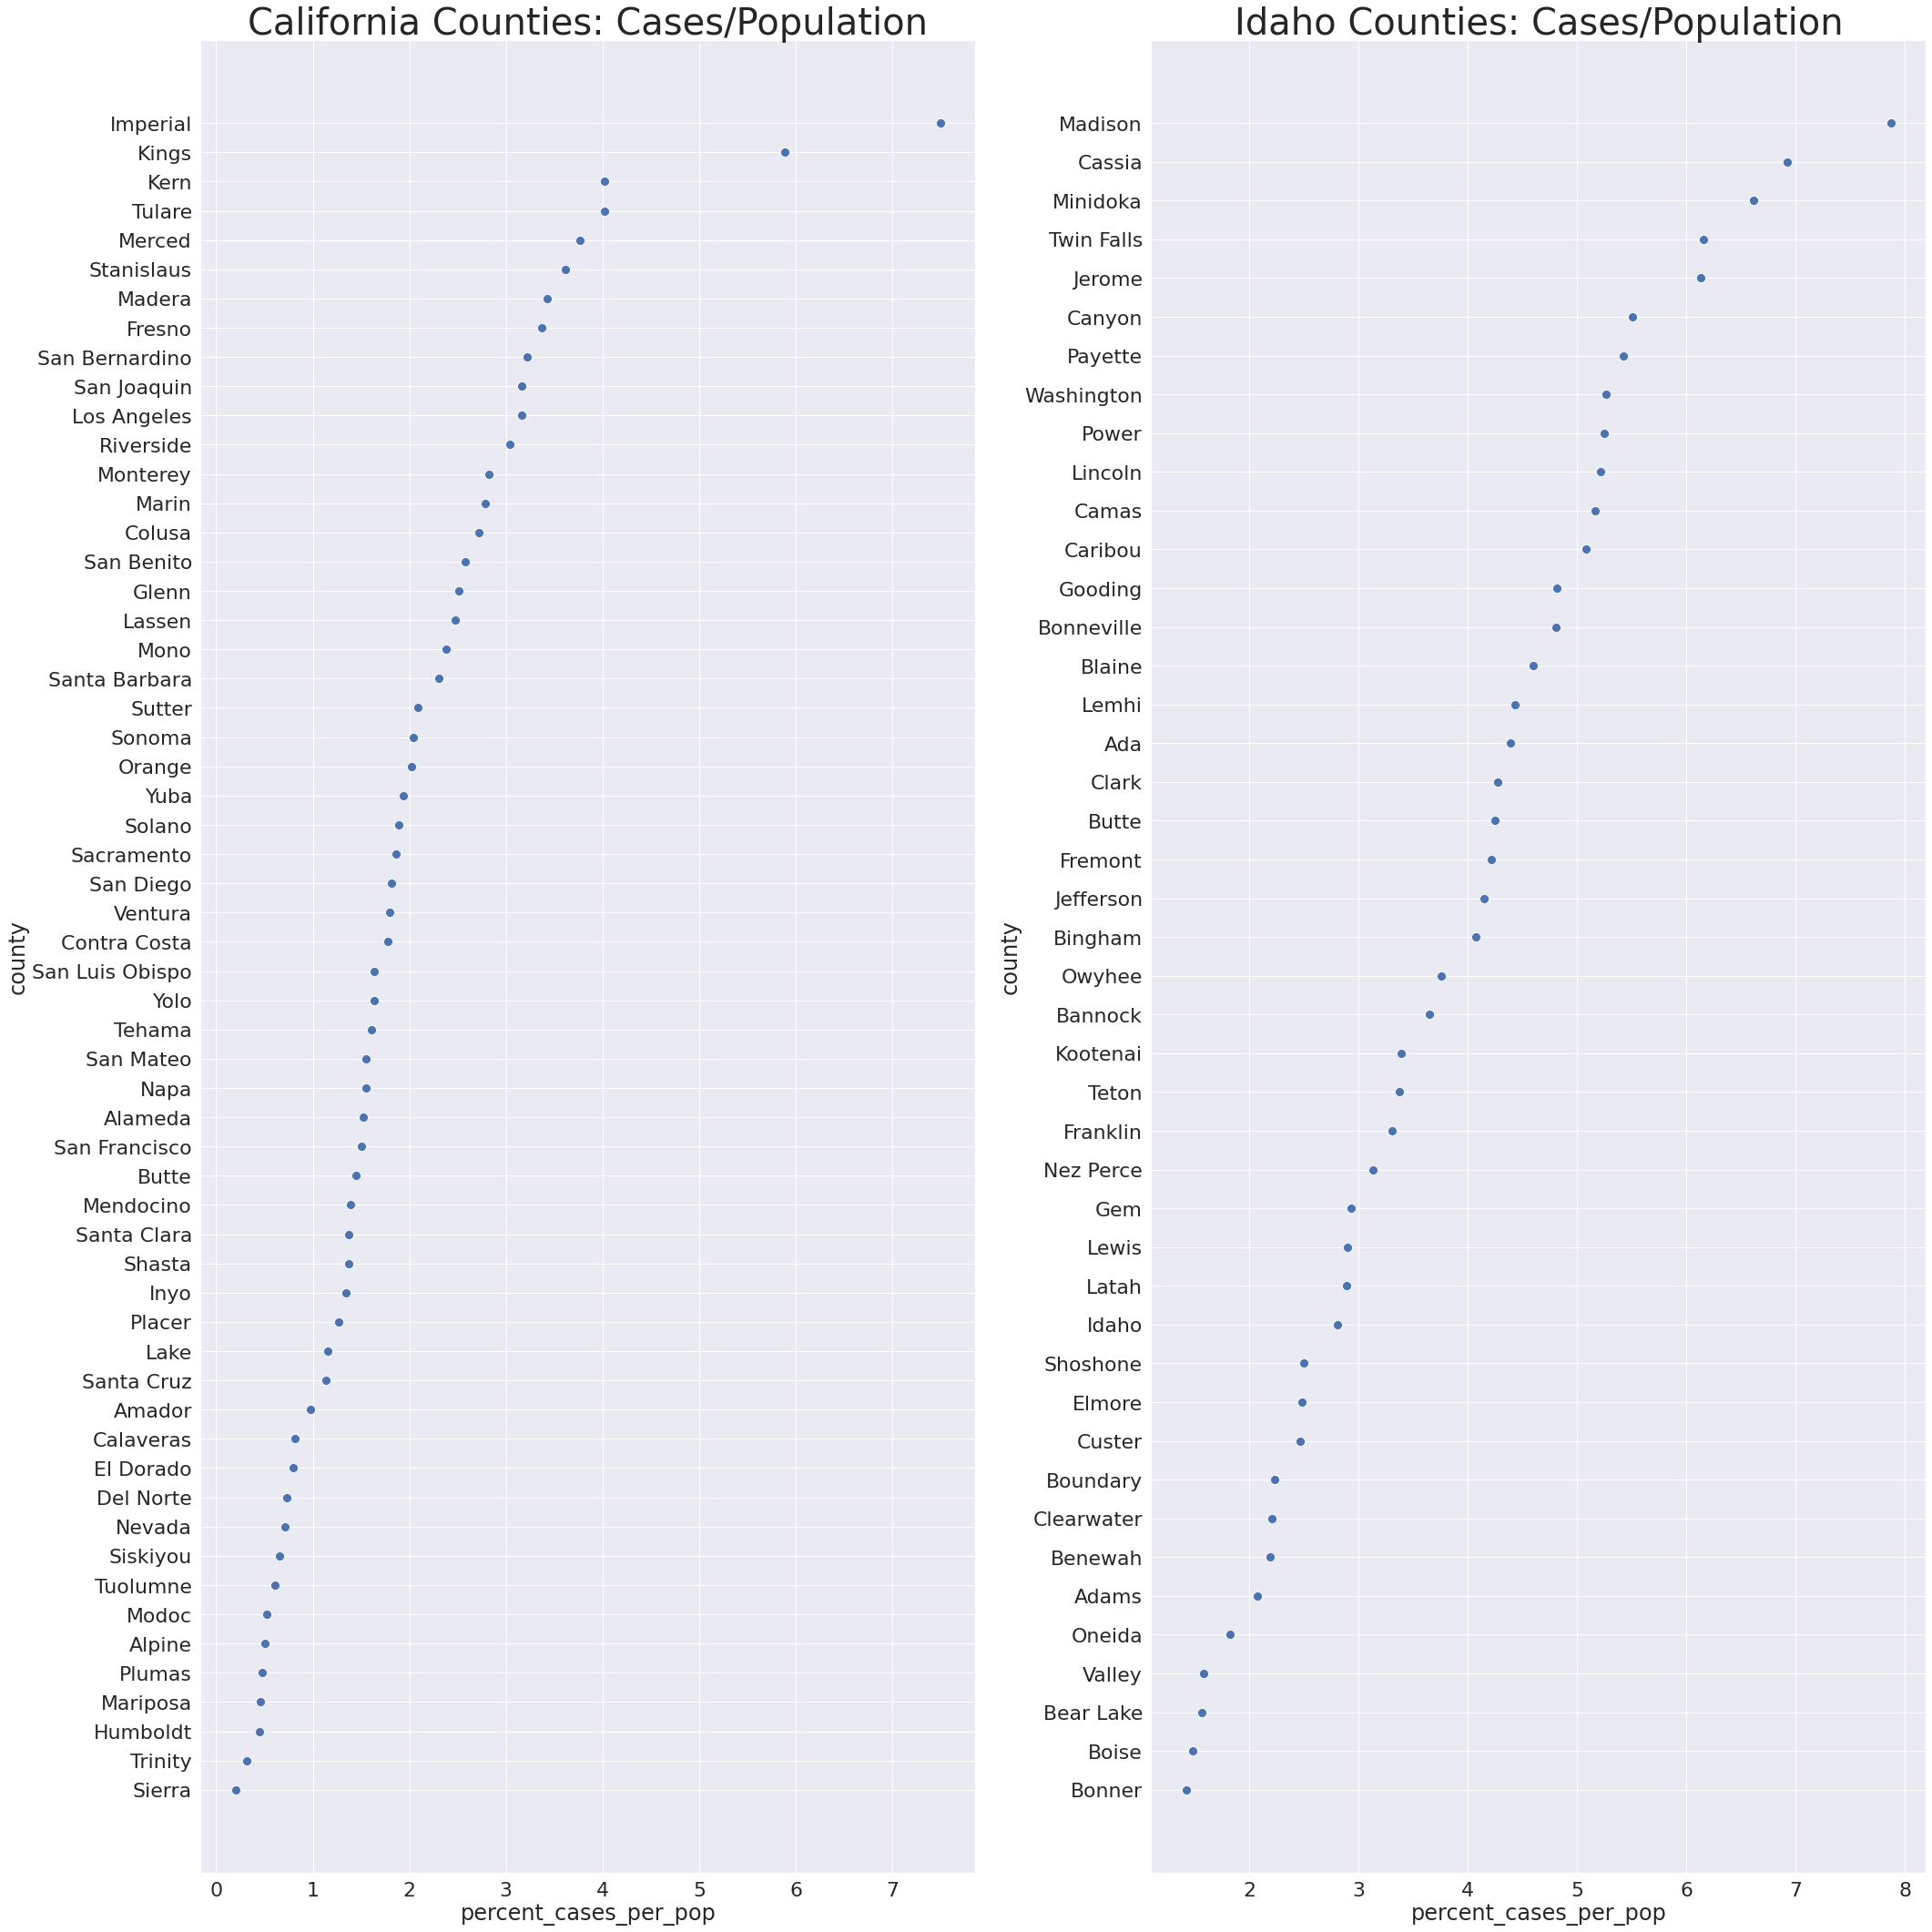

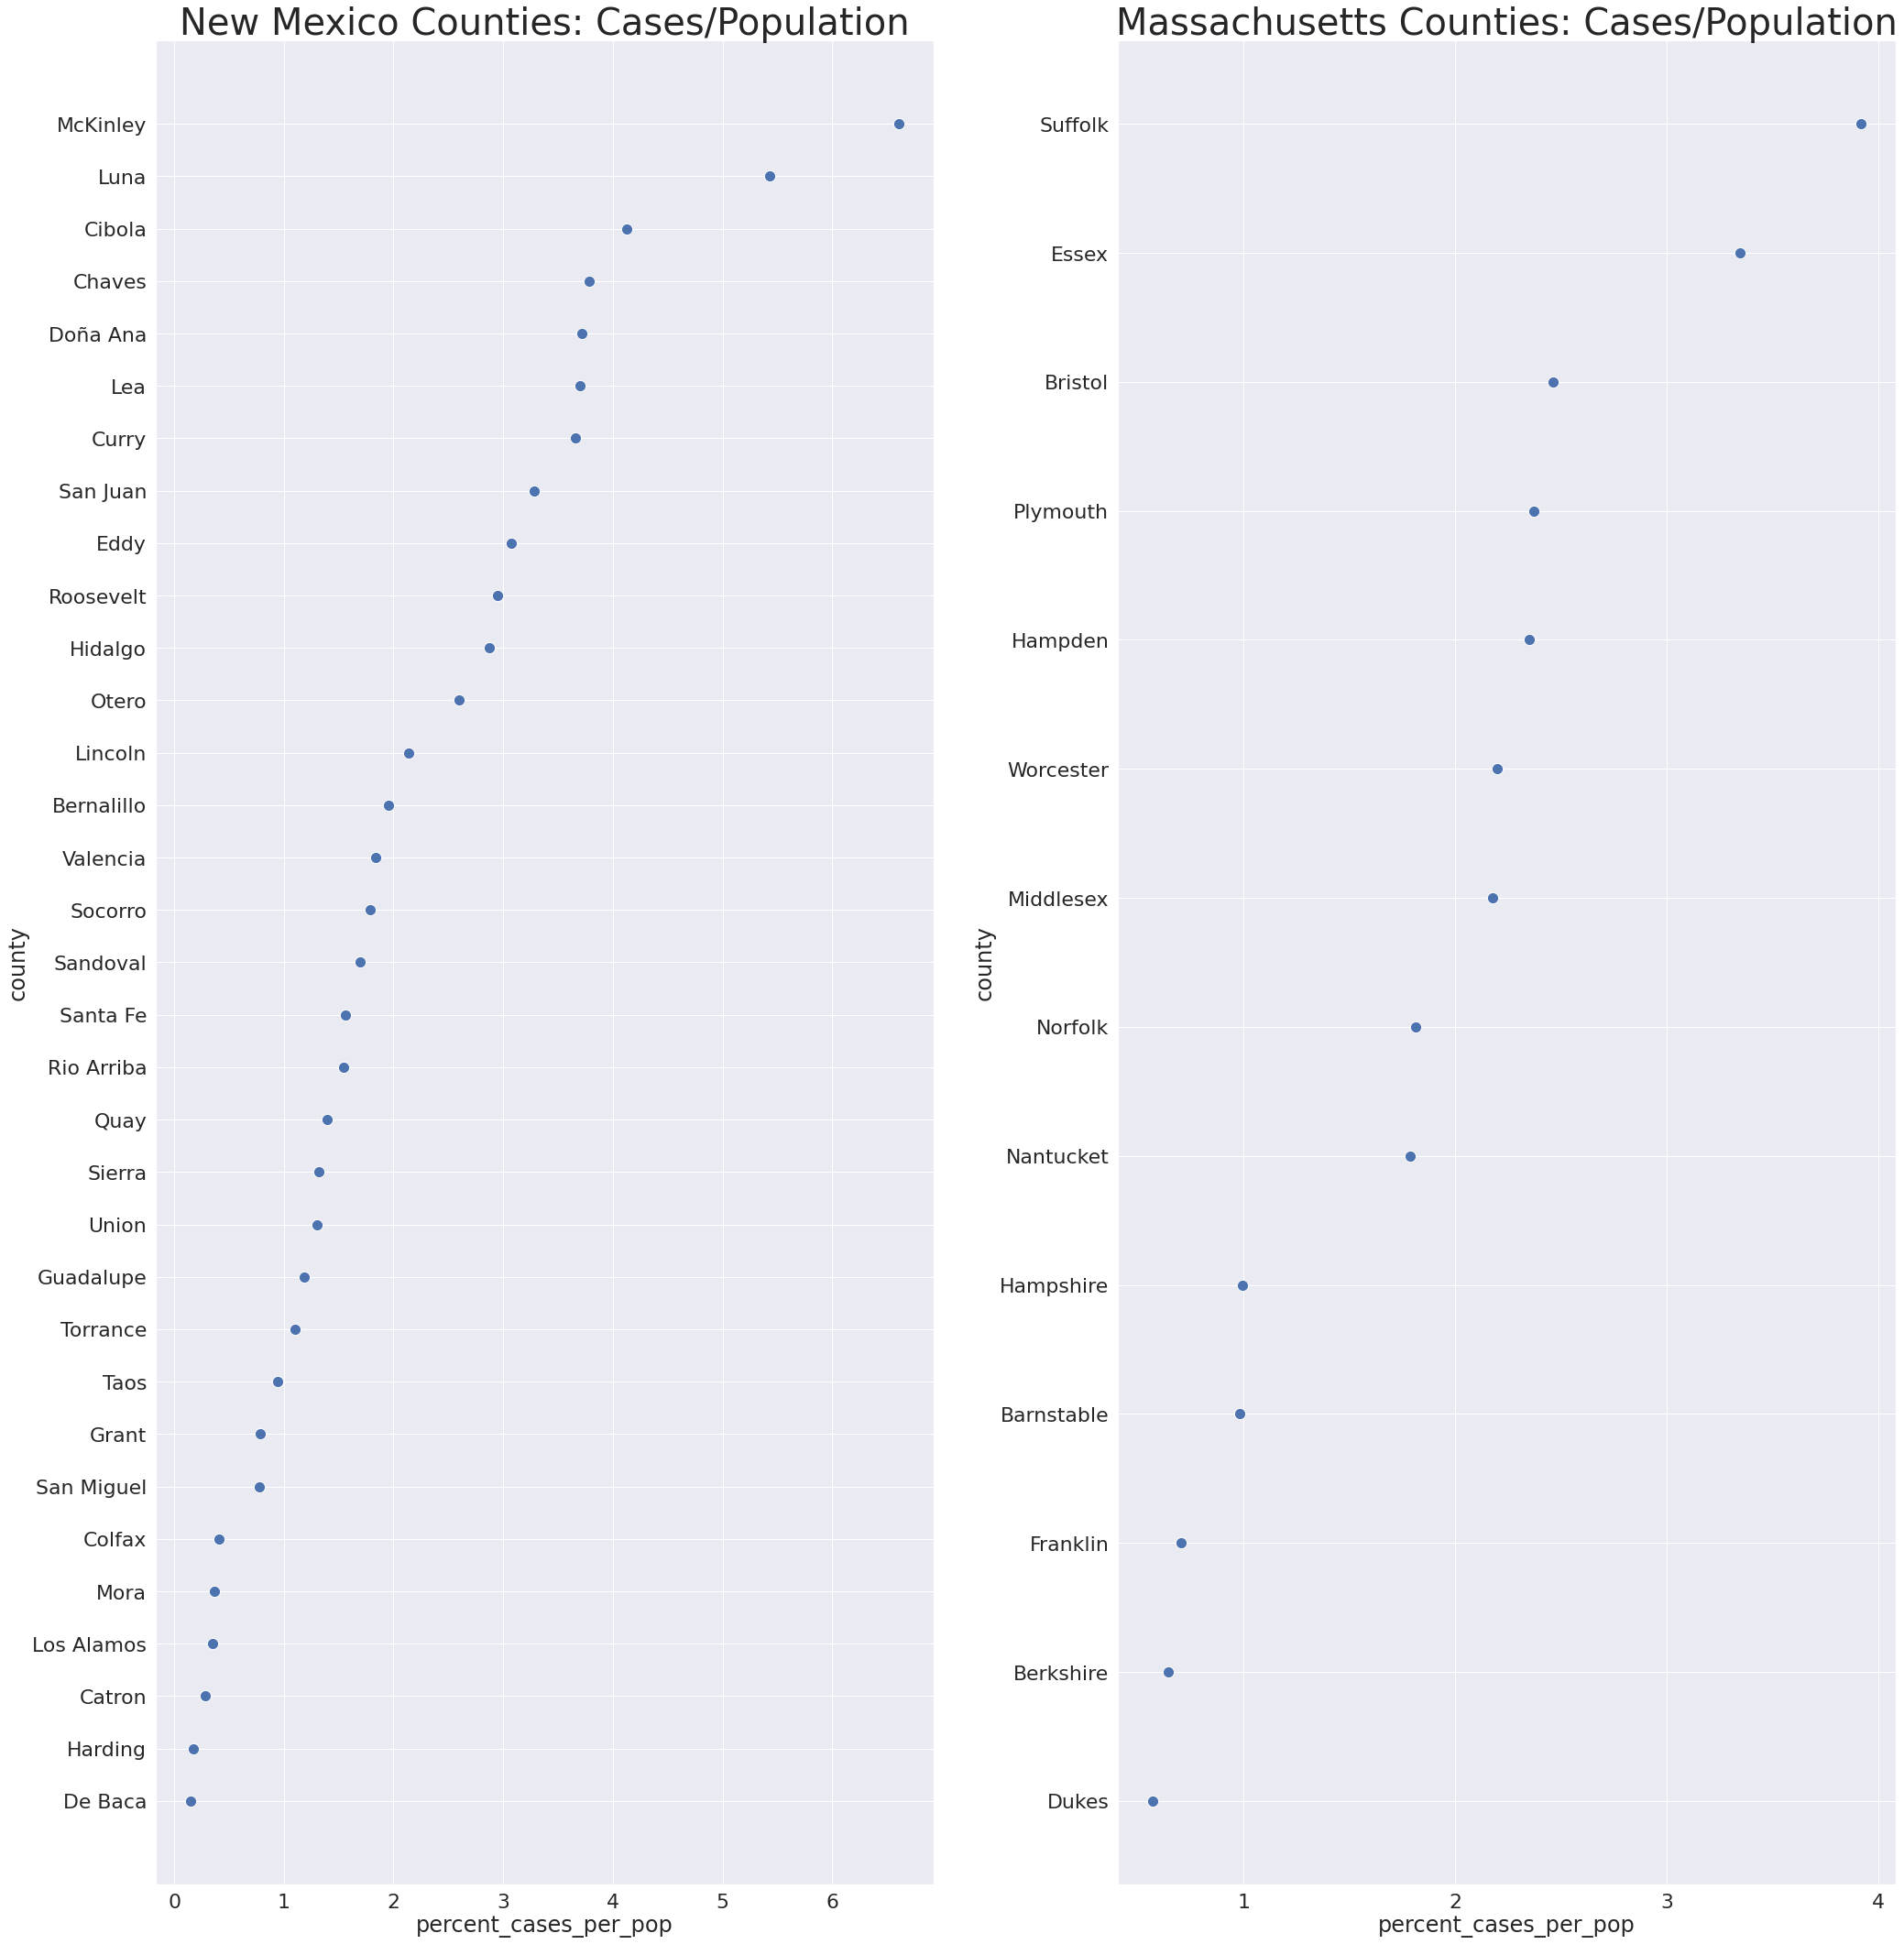

In [23]:
# Sort each dataframe by cases per population
ca_socio_df = ca_socio_df.sort_values(by=['percent_cases_per_pop'],ascending=False)
id_socio_df = id_socio_df.sort_values(by=['percent_cases_per_pop'],ascending=False)
nm_socio_df = nm_socio_df.sort_values(by=['percent_cases_per_pop'],ascending=False)
ma_socio_df = ma_socio_df.sort_values(by=['percent_cases_per_pop'],ascending=False)

''' First row of scatterplots '''

fig, ax = plt.subplots(1,2)
# California scatterplot
sns.scatterplot(data=ca_socio_df, x="percent_cases_per_pop", y="county", s=100, ax=ax[0])
# Idaho scatterplot
sns.scatterplot(data=id_socio_df, x="percent_cases_per_pop", y="county", s=100, ax=ax[1])

# Finish scatterplot set up and show plots
for i in range(len(ax)):
    ax[i].set_title(titles[i] + ": Cases/Population", fontsize=40)
    ax[i].xaxis.set_major_locator(ticker.MultipleLocator(1))
fig.show()
plt.tight_layout(h_pad=0.5)
f1 = plt.gcf()

''' Second row of scatterplots'''

fig, ax = plt.subplots(1,2)
# New Mexico scatterplot
sns.scatterplot(data=nm_socio_df, x="percent_cases_per_pop", y="county", s=150, ax=ax[0])
# Massachusetts scatterplot
sns.scatterplot(data=ma_socio_df, x="percent_cases_per_pop", y="county", s=150, ax=ax[1])

# Finish scatterplot set up and show plots
for i in range(len(ax)):
    ax[i].set_title(titles[i+2] + ": Cases/Population", fontsize=40)
    ax[i].xaxis.set_major_locator(ticker.MultipleLocator(1))
fig.show()
plt.tight_layout()
f2 = plt.gcf()

### Relationship with socieconomic factors
We will now look at `percent_cases_per_pop` in these 4 states in conjunction with socioeconomic factors. In order to better visualize these trends, we are displaying double bar graphs of each state and sorted into descending order of cases per pop with counties with the lowest percentages at the top whereas counties with the highest percentages of cases per pop are at the bottom of each graph. We are looking to see if there is a similar trend seen between the percent cases per pop and each socioeconomic factor examined. We are not looking at specific counties, rather we are focusing on general trends seen across the counties in each state.

#### Double bar graph of cases/population and rural/population
Here, we are examining `percent_cases_per_pop` displayed in comparison to `percent_rural` which is the percent rural a county is considered. Each graph is sorted in descending order based on `percent_cases_per_pop`. Based off of these visualizations, we did not see a relationship between `percent_cases_per_pop` and `percent_rural`.

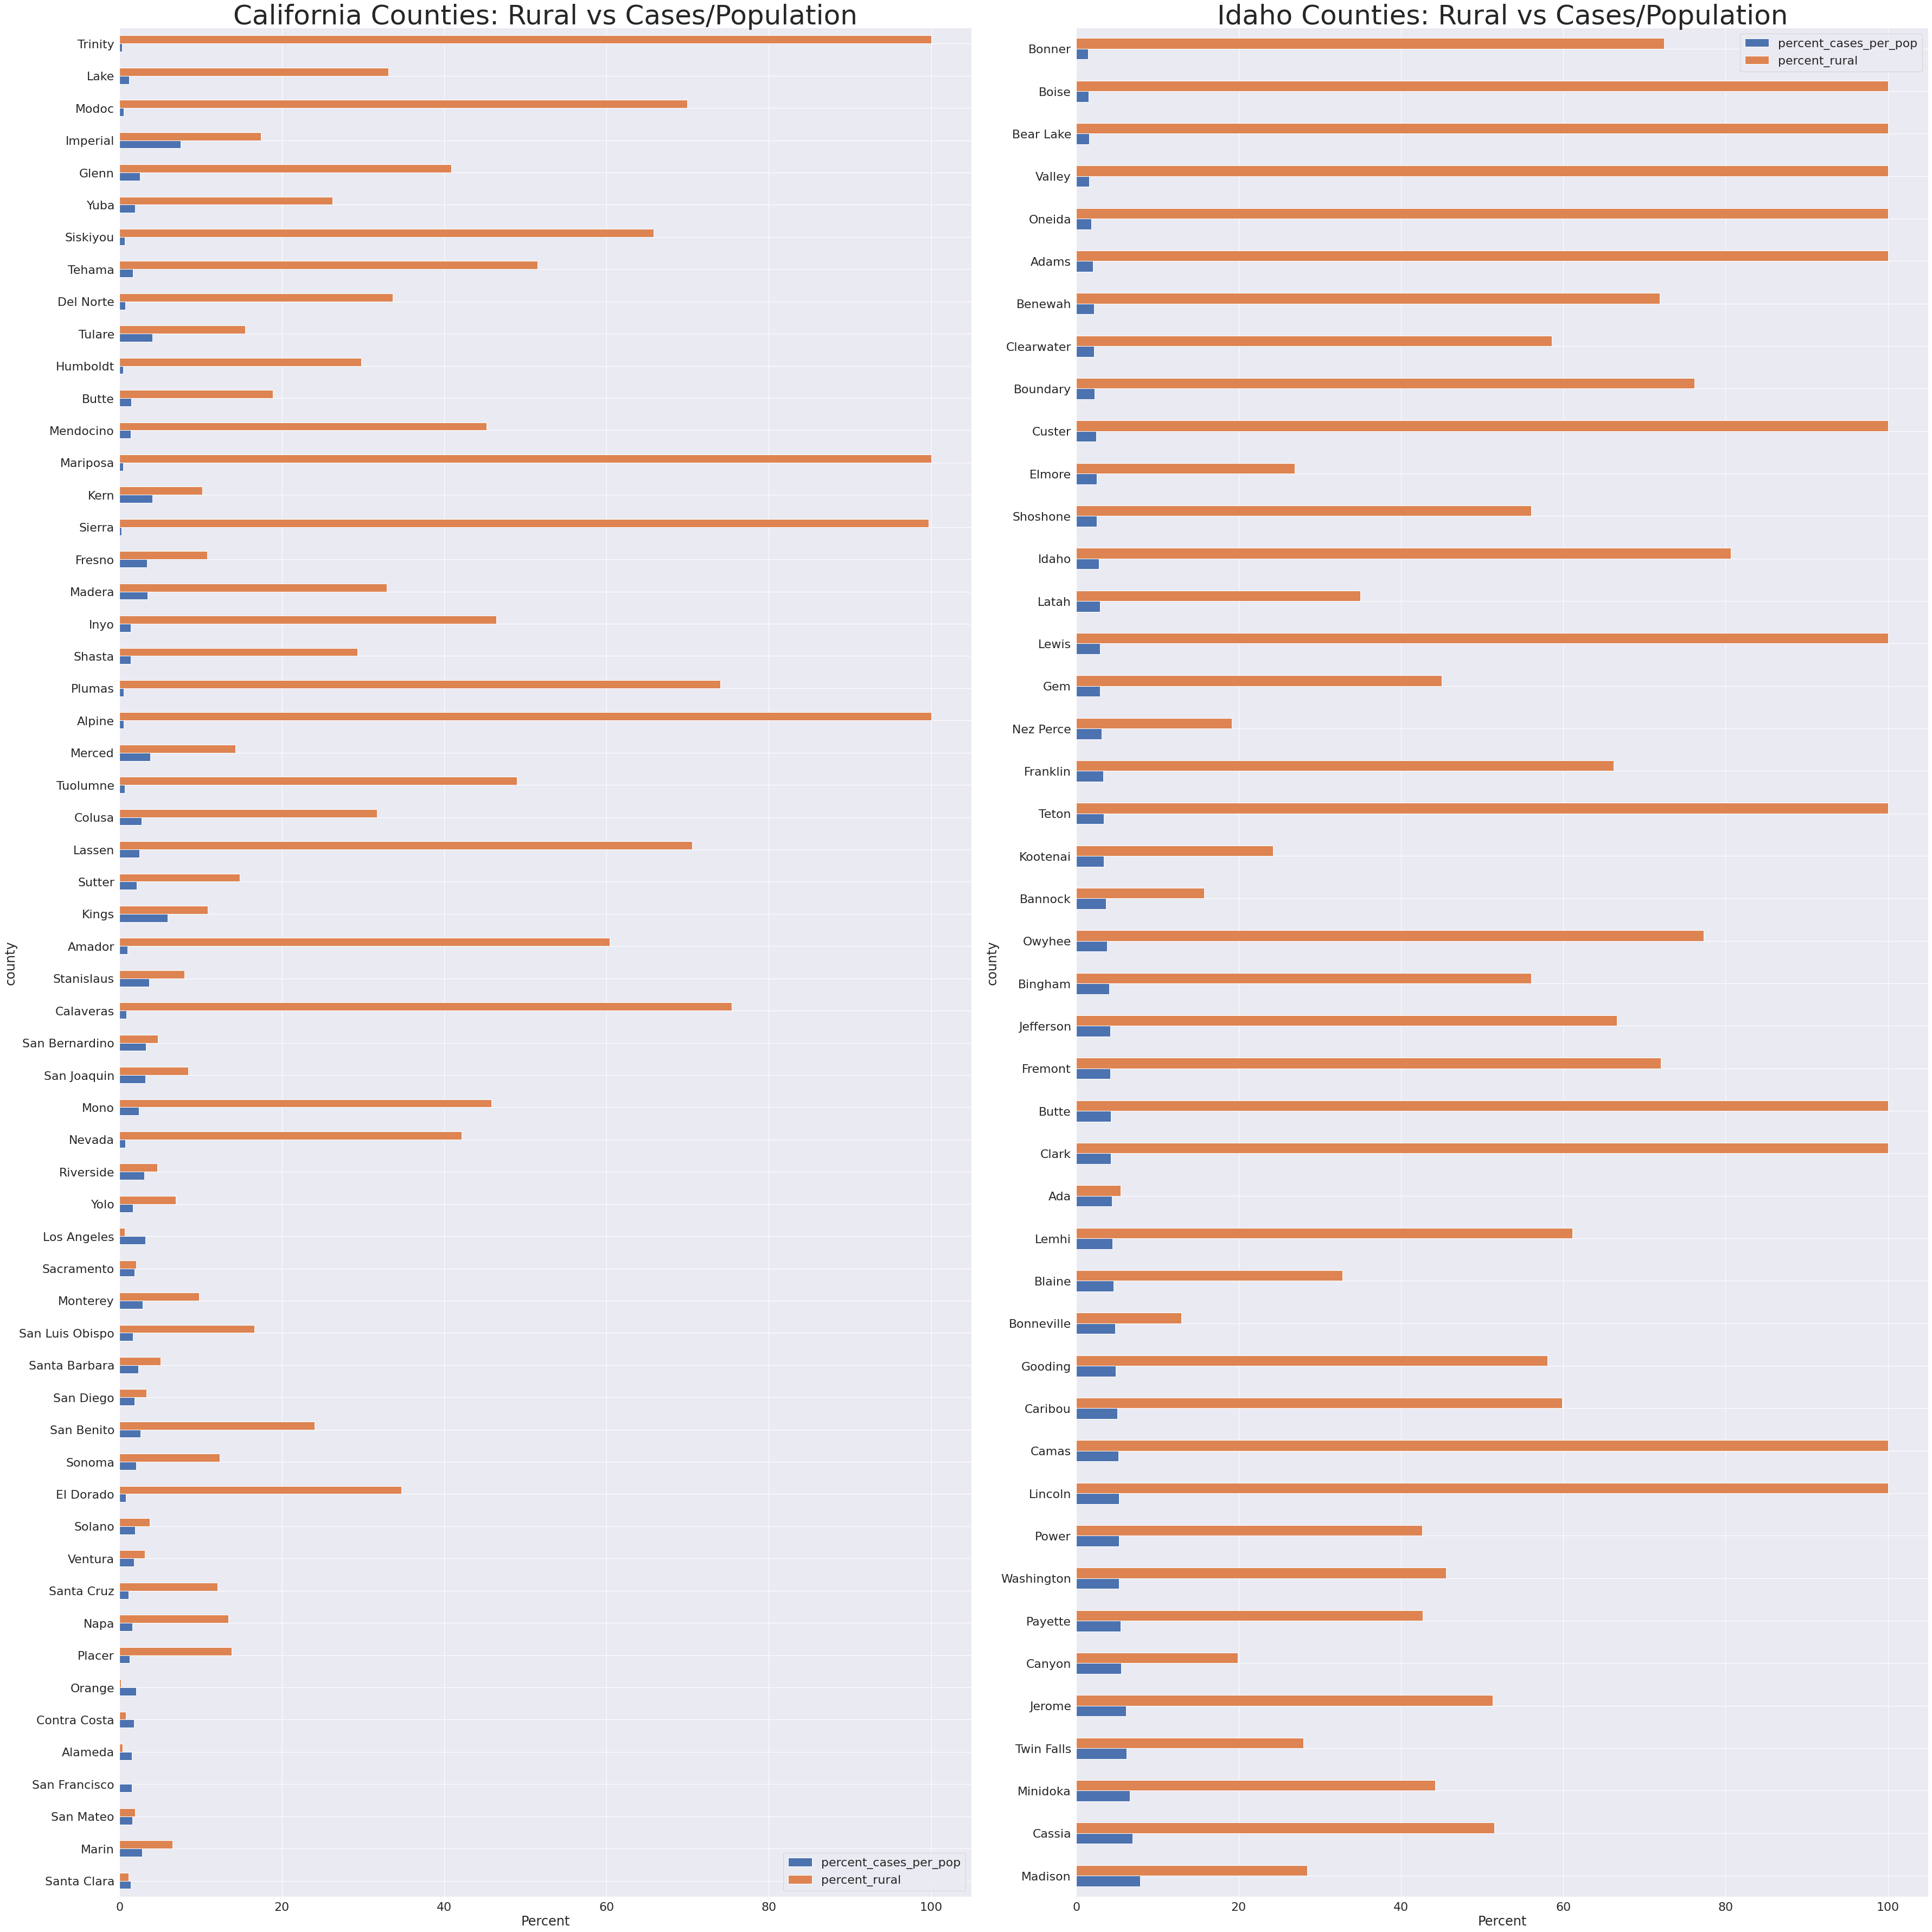

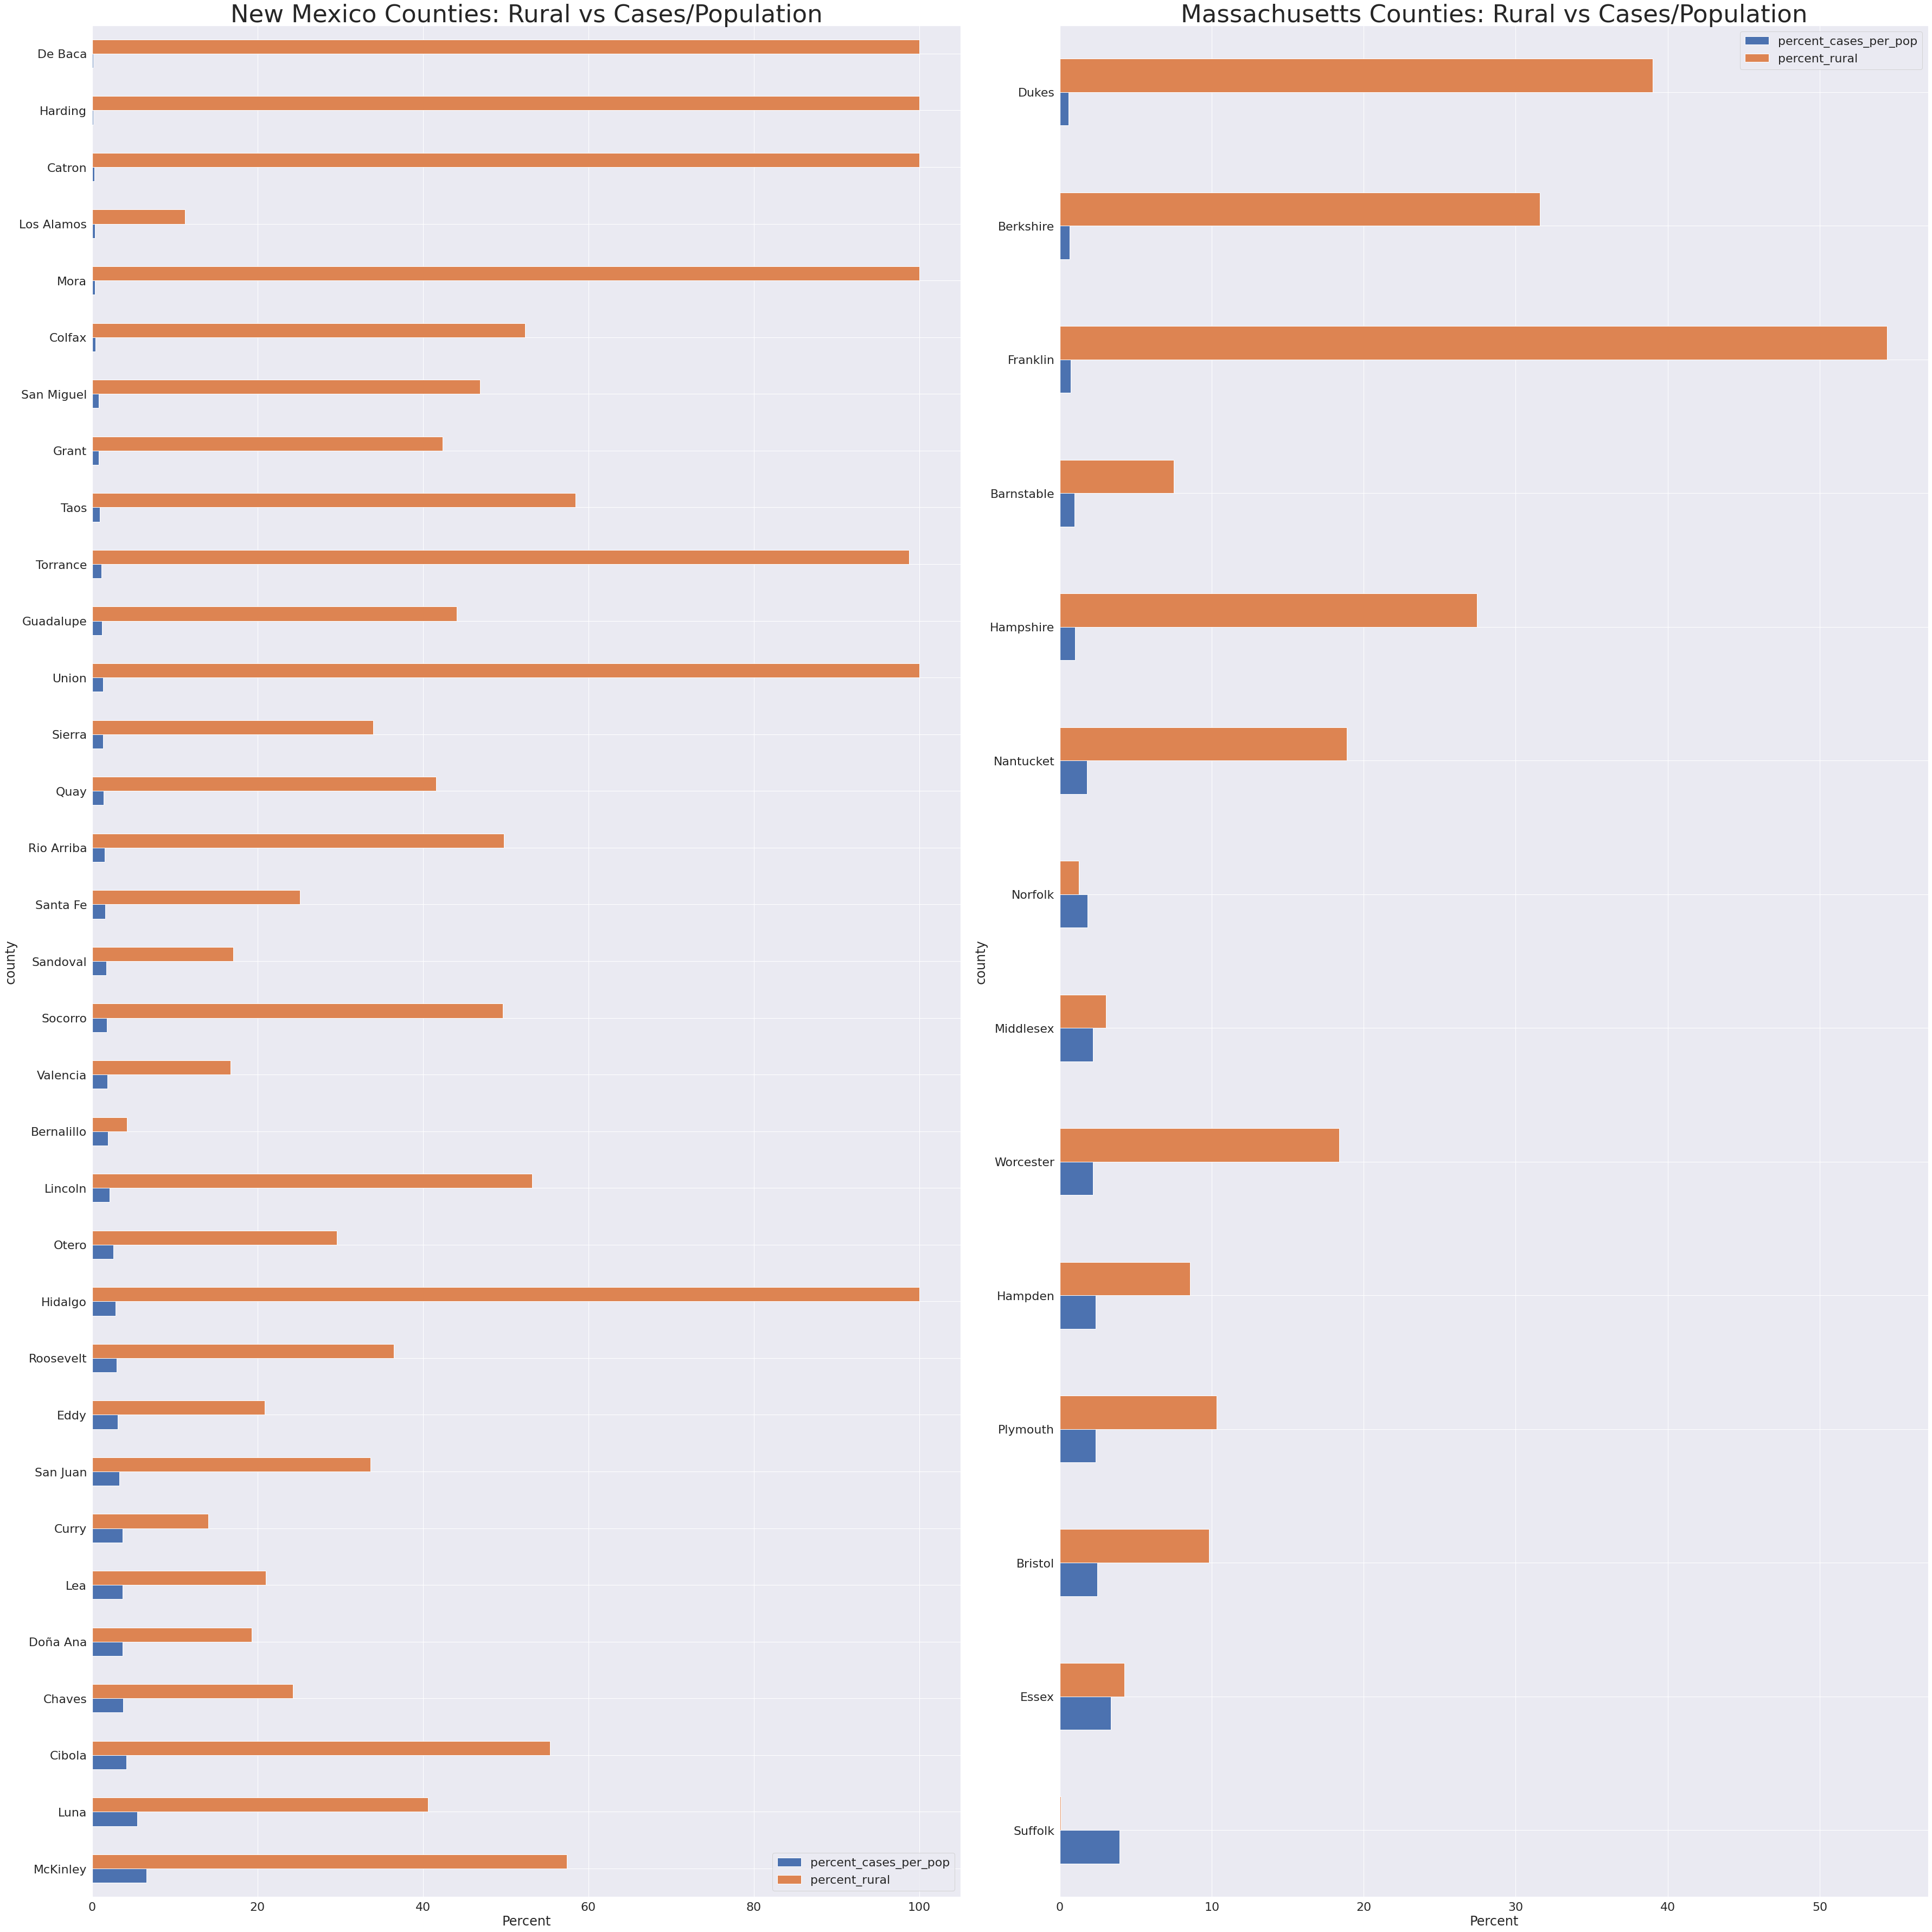

In [70]:
''' First row of double bar graphs '''
fig, ax = plt.subplots(1,2)
ca_socio_df.plot(x="county", y=["percent_cases_per_pop", "percent_rural"], kind="barh", ax=ax[0])
id_socio_df.plot(x="county", y=["percent_cases_per_pop", "percent_rural"], kind="barh", ax=ax[1])
# Finish scatterplot set up and show plots
for i in range(len(ax)):
    ax[i].set_xlabel('Percent')
    ax[i].set_title(titles[i] + ": Rural vs Cases/Population", fontsize=50)
fig.show()
plt.tight_layout()
f5 = plt.gcf()

''' Second row of double bar graphs '''
fig, ax = plt.subplots(1,2)
nm_socio_df.plot(x="county", y=["percent_cases_per_pop", "percent_rural"], kind="barh", ax=ax[0])
ma_socio_df.plot(x="county", y=["percent_cases_per_pop", "percent_rural"], kind="barh", ax=ax[1])
# Finish scatterplot set up and show plots
for i in range(len(ax)):
    ax[i].set_xlabel('Percent')
    ax[i].set_title(titles[i+2] + ": Rural vs Cases/Population", fontsize=45)
fig.show()
plt.tight_layout()
f6 = plt.gcf()

#### Double bar graph of cases/population and below poverty/population
Here, we are examining `percent_cases_per_pop` displayed in comparison to `percent_below_poverty` which is the percentage of the county's population that is below the poverty line. Each graph is sorted in descending order based on `percent_cases_per_pop`. Based off of these visualizations, we did not see a relationship between `percent_cases_per_pop` and `percent_below_poverty`.

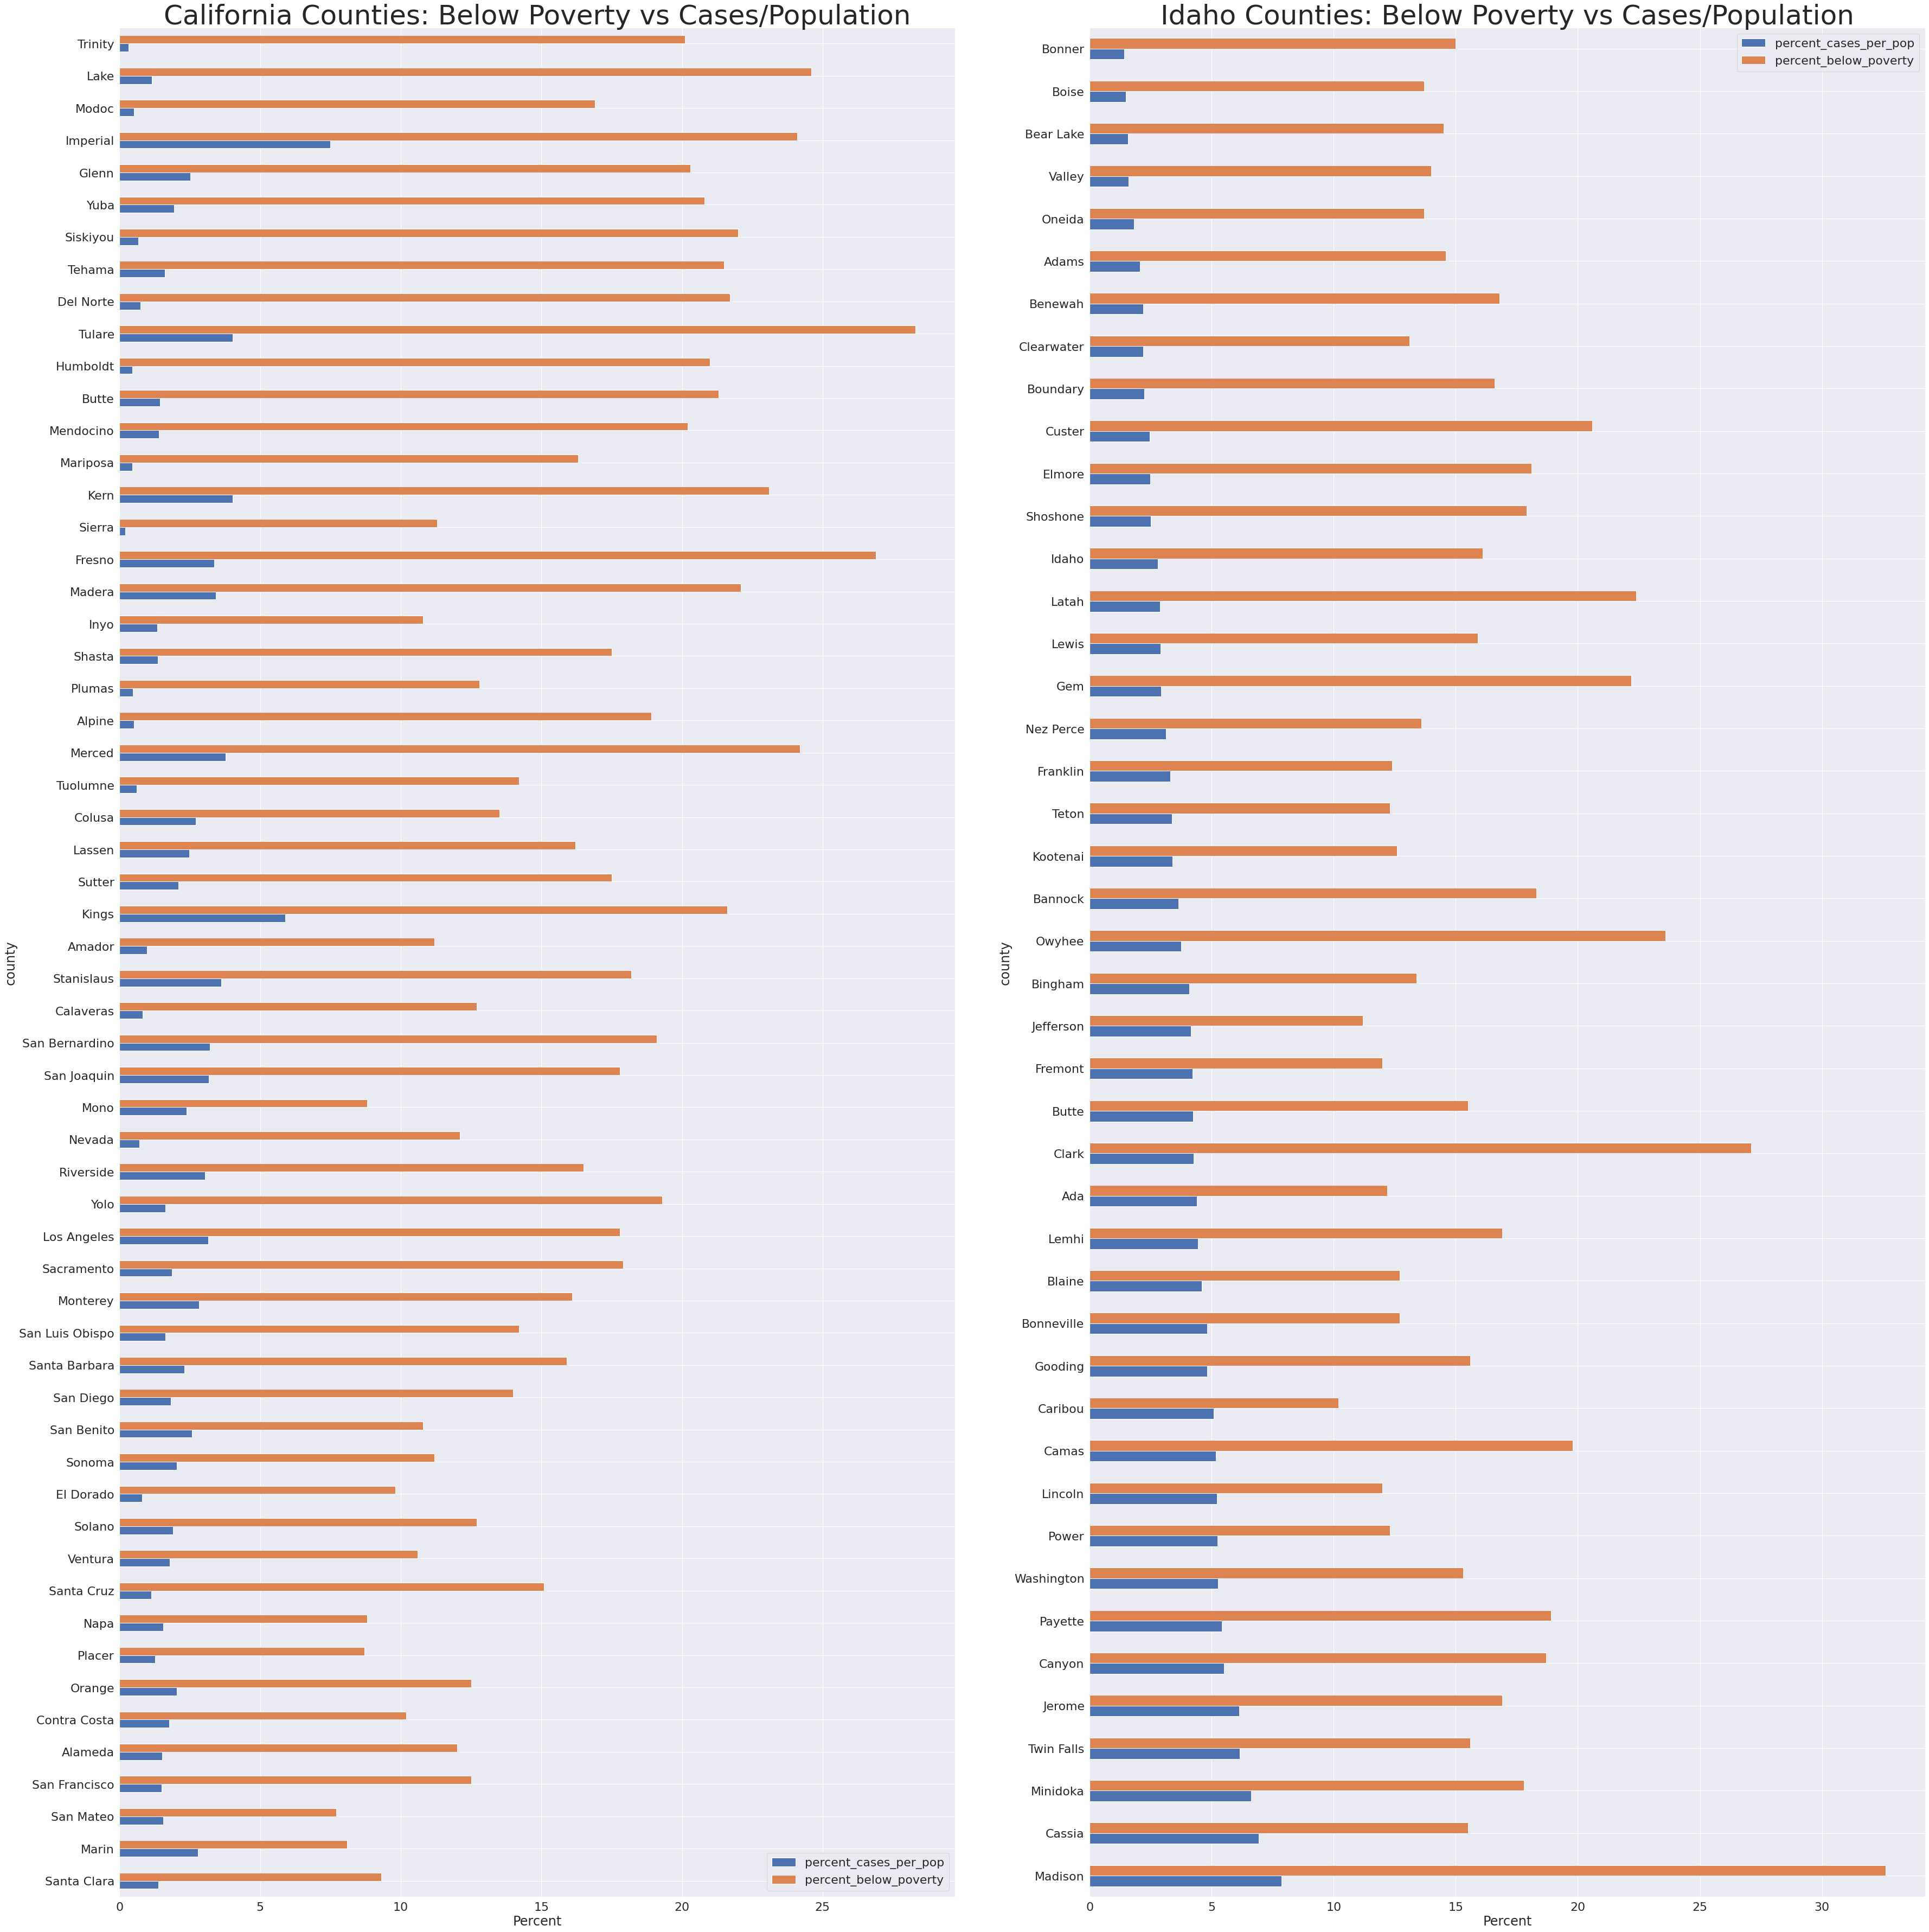

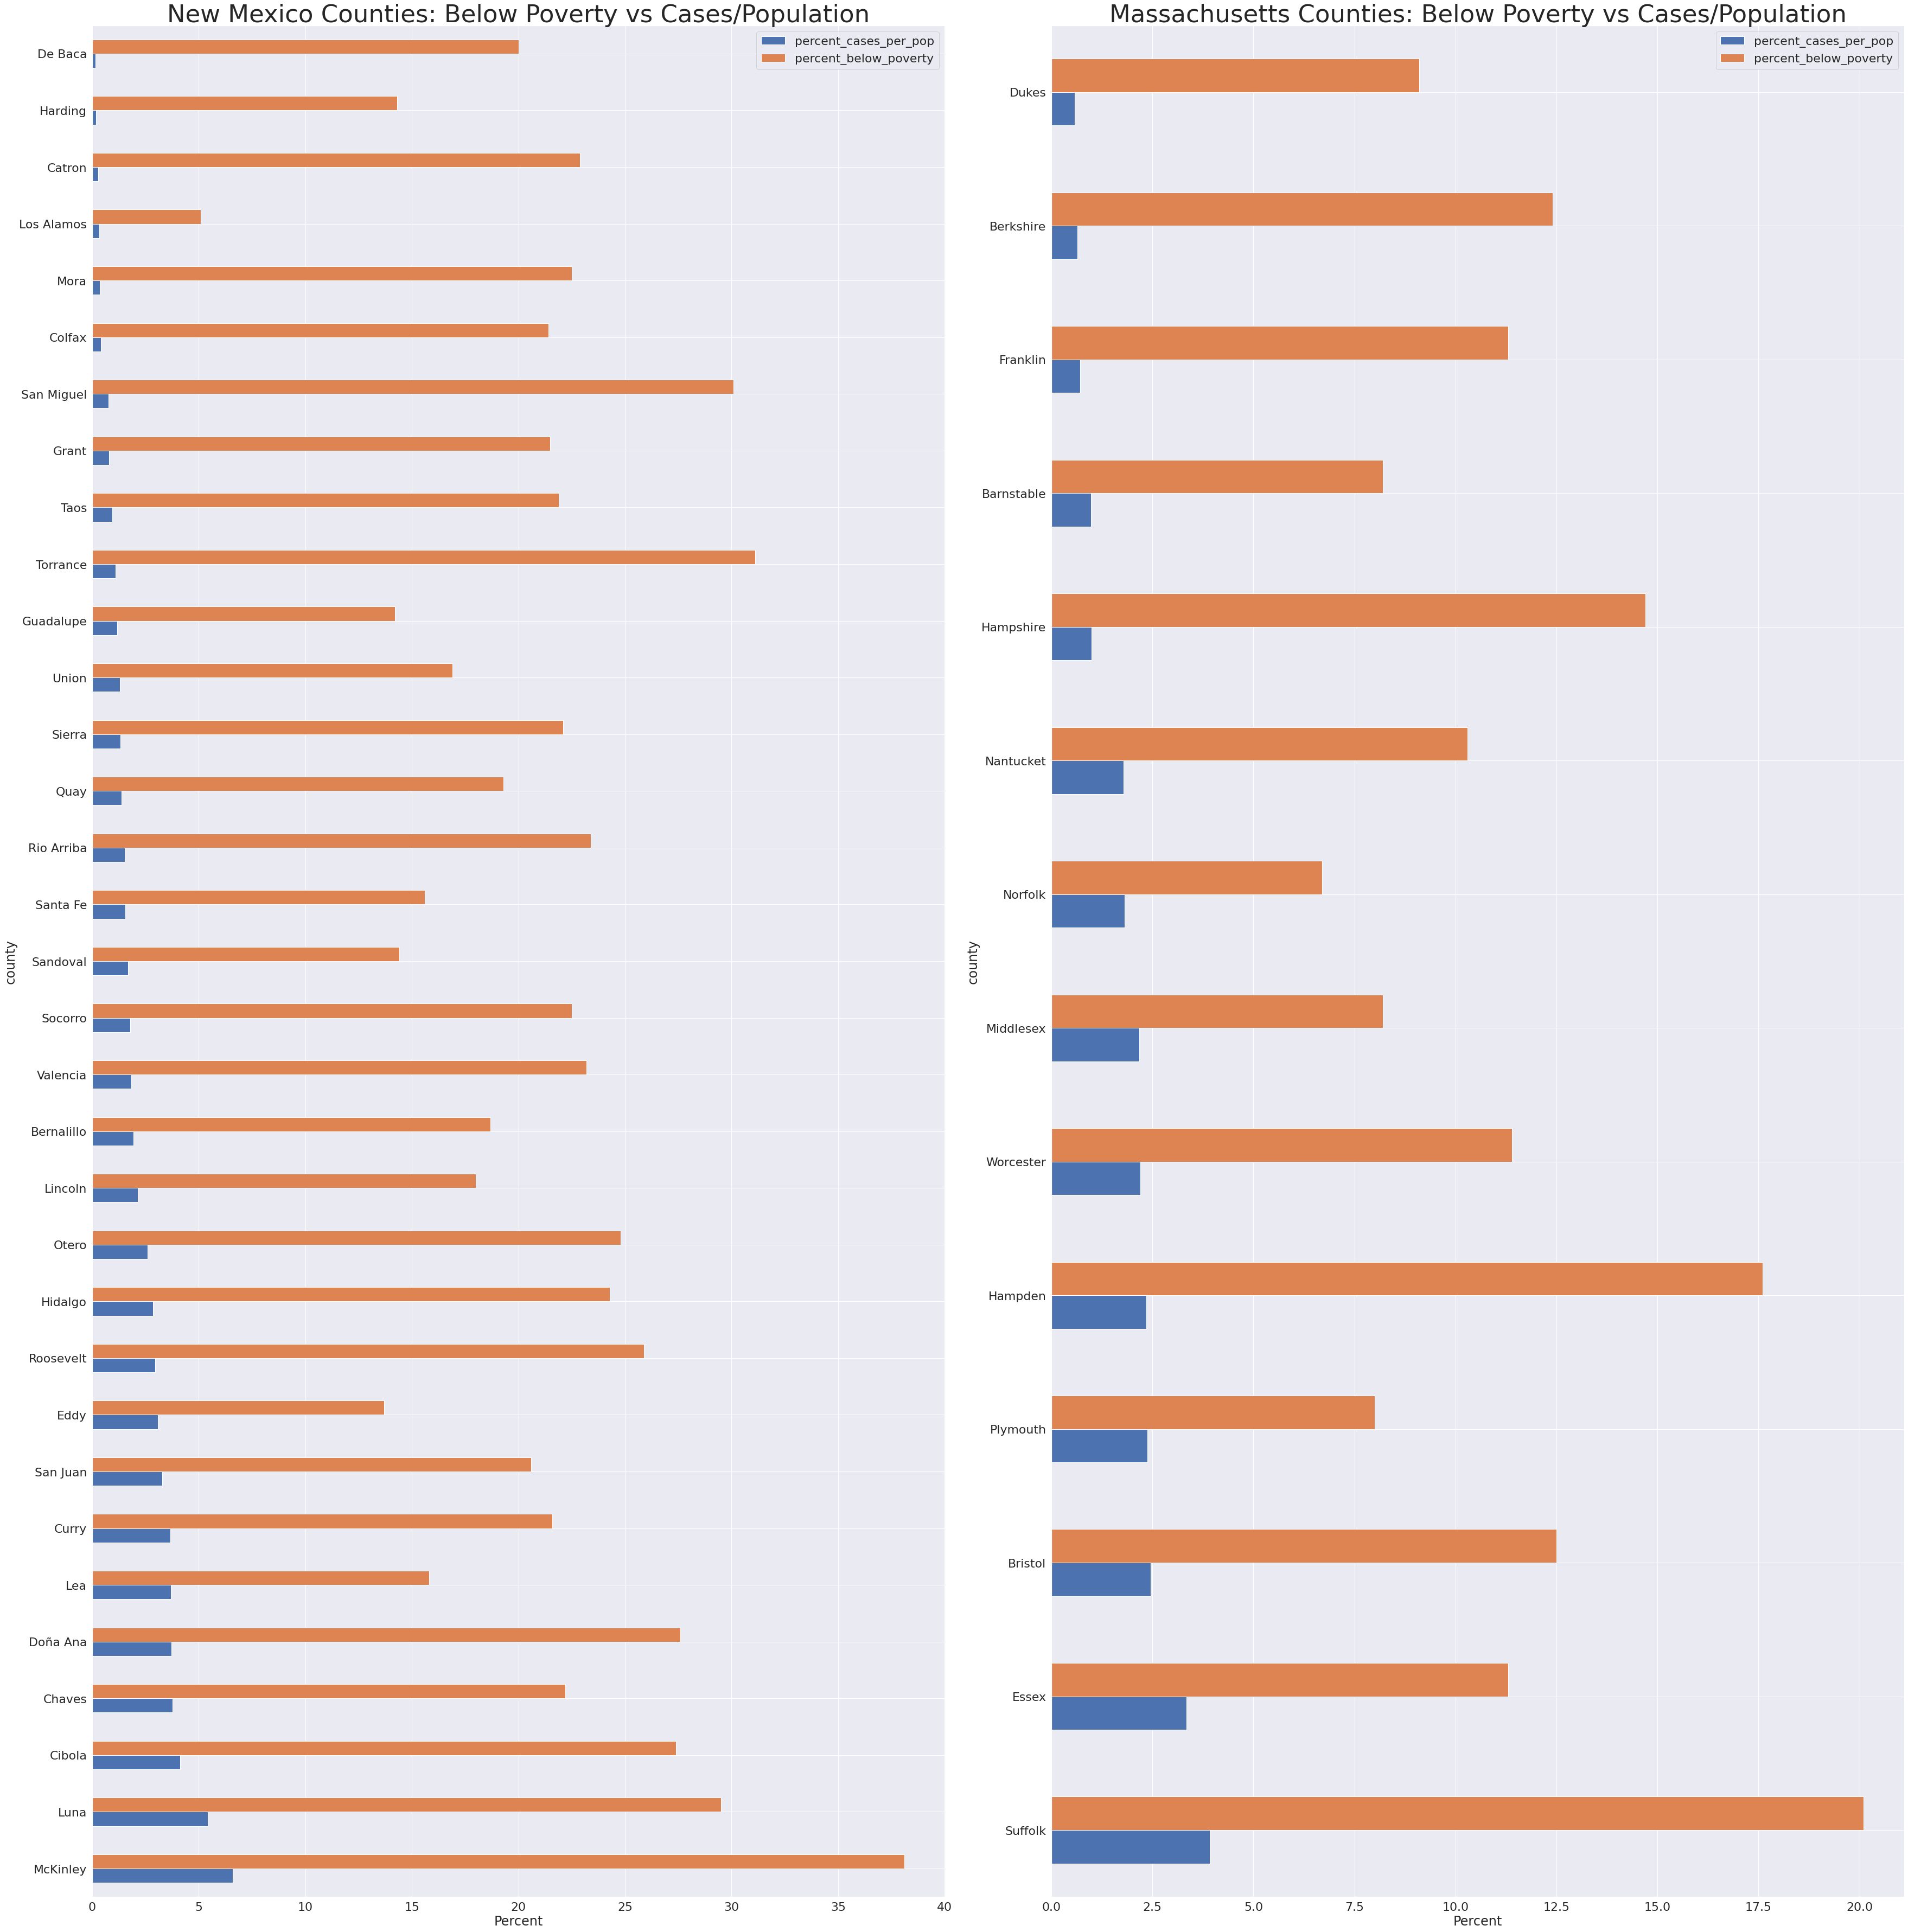

In [69]:
''' First row of double bar graphs '''
fig, ax = plt.subplots(1,2)
ca_socio_df.plot(x="county", y=["percent_cases_per_pop", "percent_below_poverty"], kind="barh", ax=ax[0])
id_socio_df.plot(x="county", y=["percent_cases_per_pop", "percent_below_poverty"], kind="barh", ax=ax[1])
# Finish scatterplot set up and show plots
for i in range(len(ax)):
    ax[i].set_xlabel('Percent')
    ax[i].set_title(titles[i] + ": Below Poverty vs Cases/Population", fontsize=50)
fig.show()
plt.tight_layout()
f7 = plt.gcf()

''' Second row of double bar graphs '''
fig, ax = plt.subplots(1,2)
nm_socio_df.plot(x="county", y=["percent_cases_per_pop", "percent_below_poverty"], kind="barh", ax=ax[0])
ma_socio_df.plot(x="county", y=["percent_cases_per_pop", "percent_below_poverty"], kind="barh", ax=ax[1])
# Finish scatterplot set up and show plots
for i in range(len(ax)):
    ax[i].set_xlabel('Percent')
    ax[i].set_title(titles[i+2] + ": Below Poverty vs Cases/Population", fontsize=45)
fig.show()
plt.tight_layout()
f8 = plt.gcf()

#### Income
Here, we are examining `percent_cases_per_pop` displayed in comparison to `median_household_income`. Since these two variables are not both percentages we could not use a double bar graph. Instead, we are graphing each variable side-by-side on separate graphs. This way we are able to look at the trend of each variable and successfully identify a correlation. Both graphs are sorted in descending order based on `percent_cases_per_pop`. Based off of these visualizations, we did not see a relationship between `percent_cases_per_pop` and `median_household_income`.

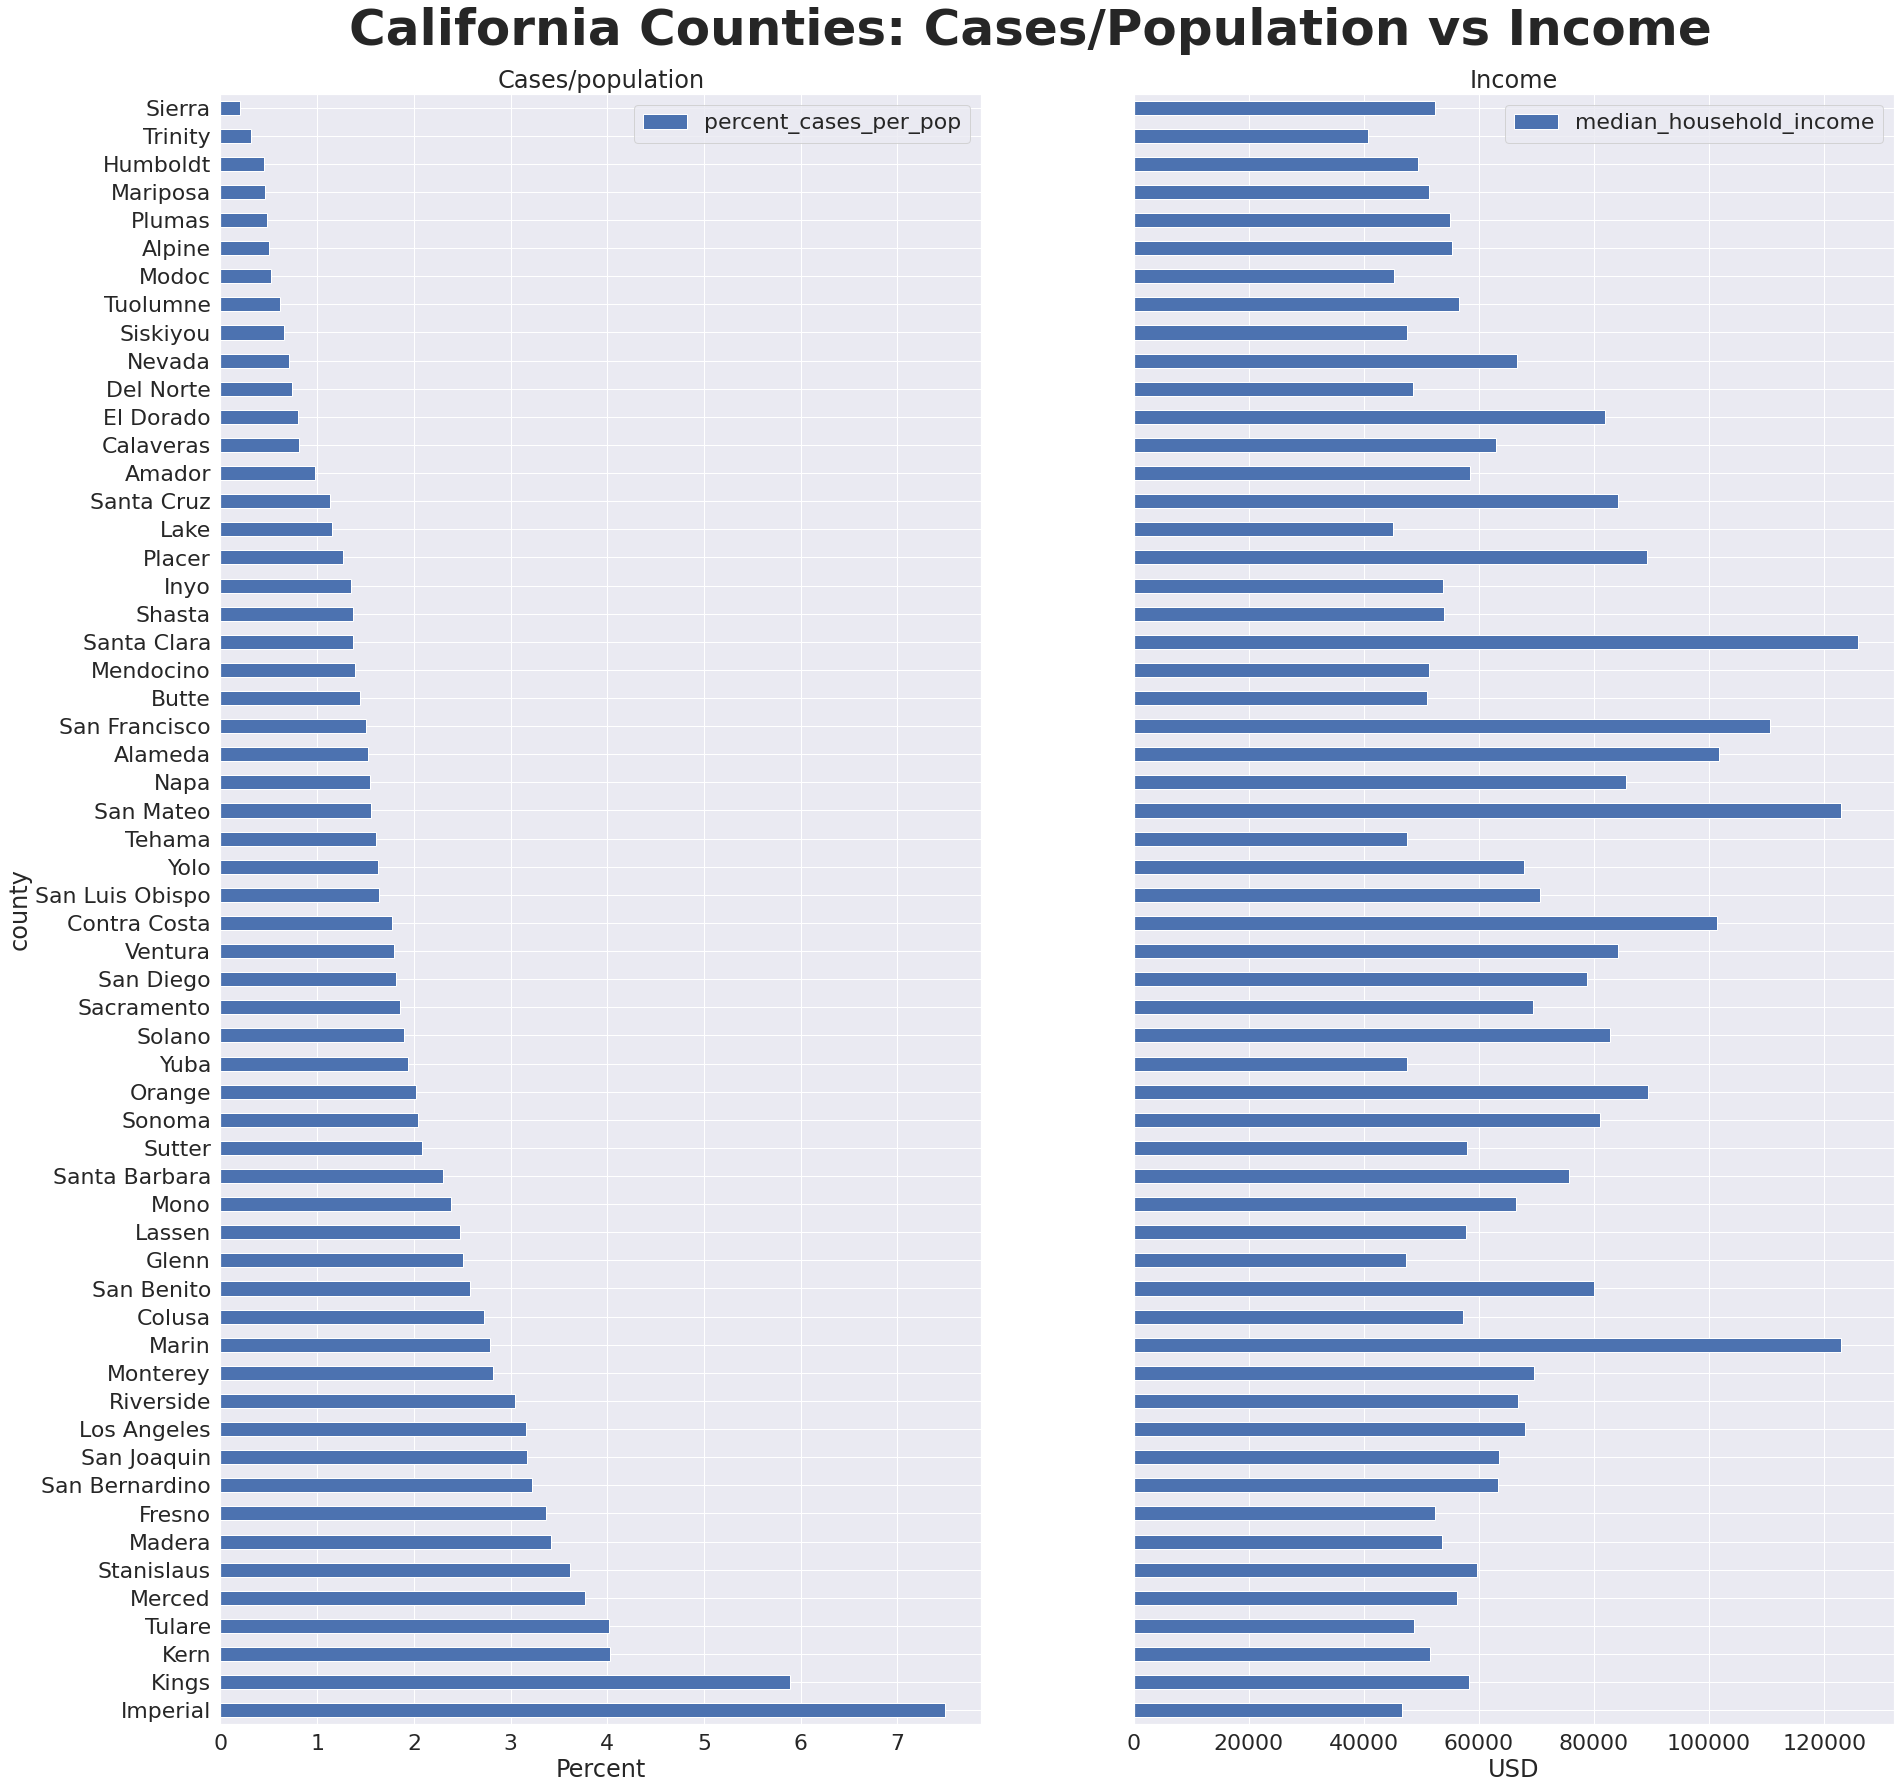

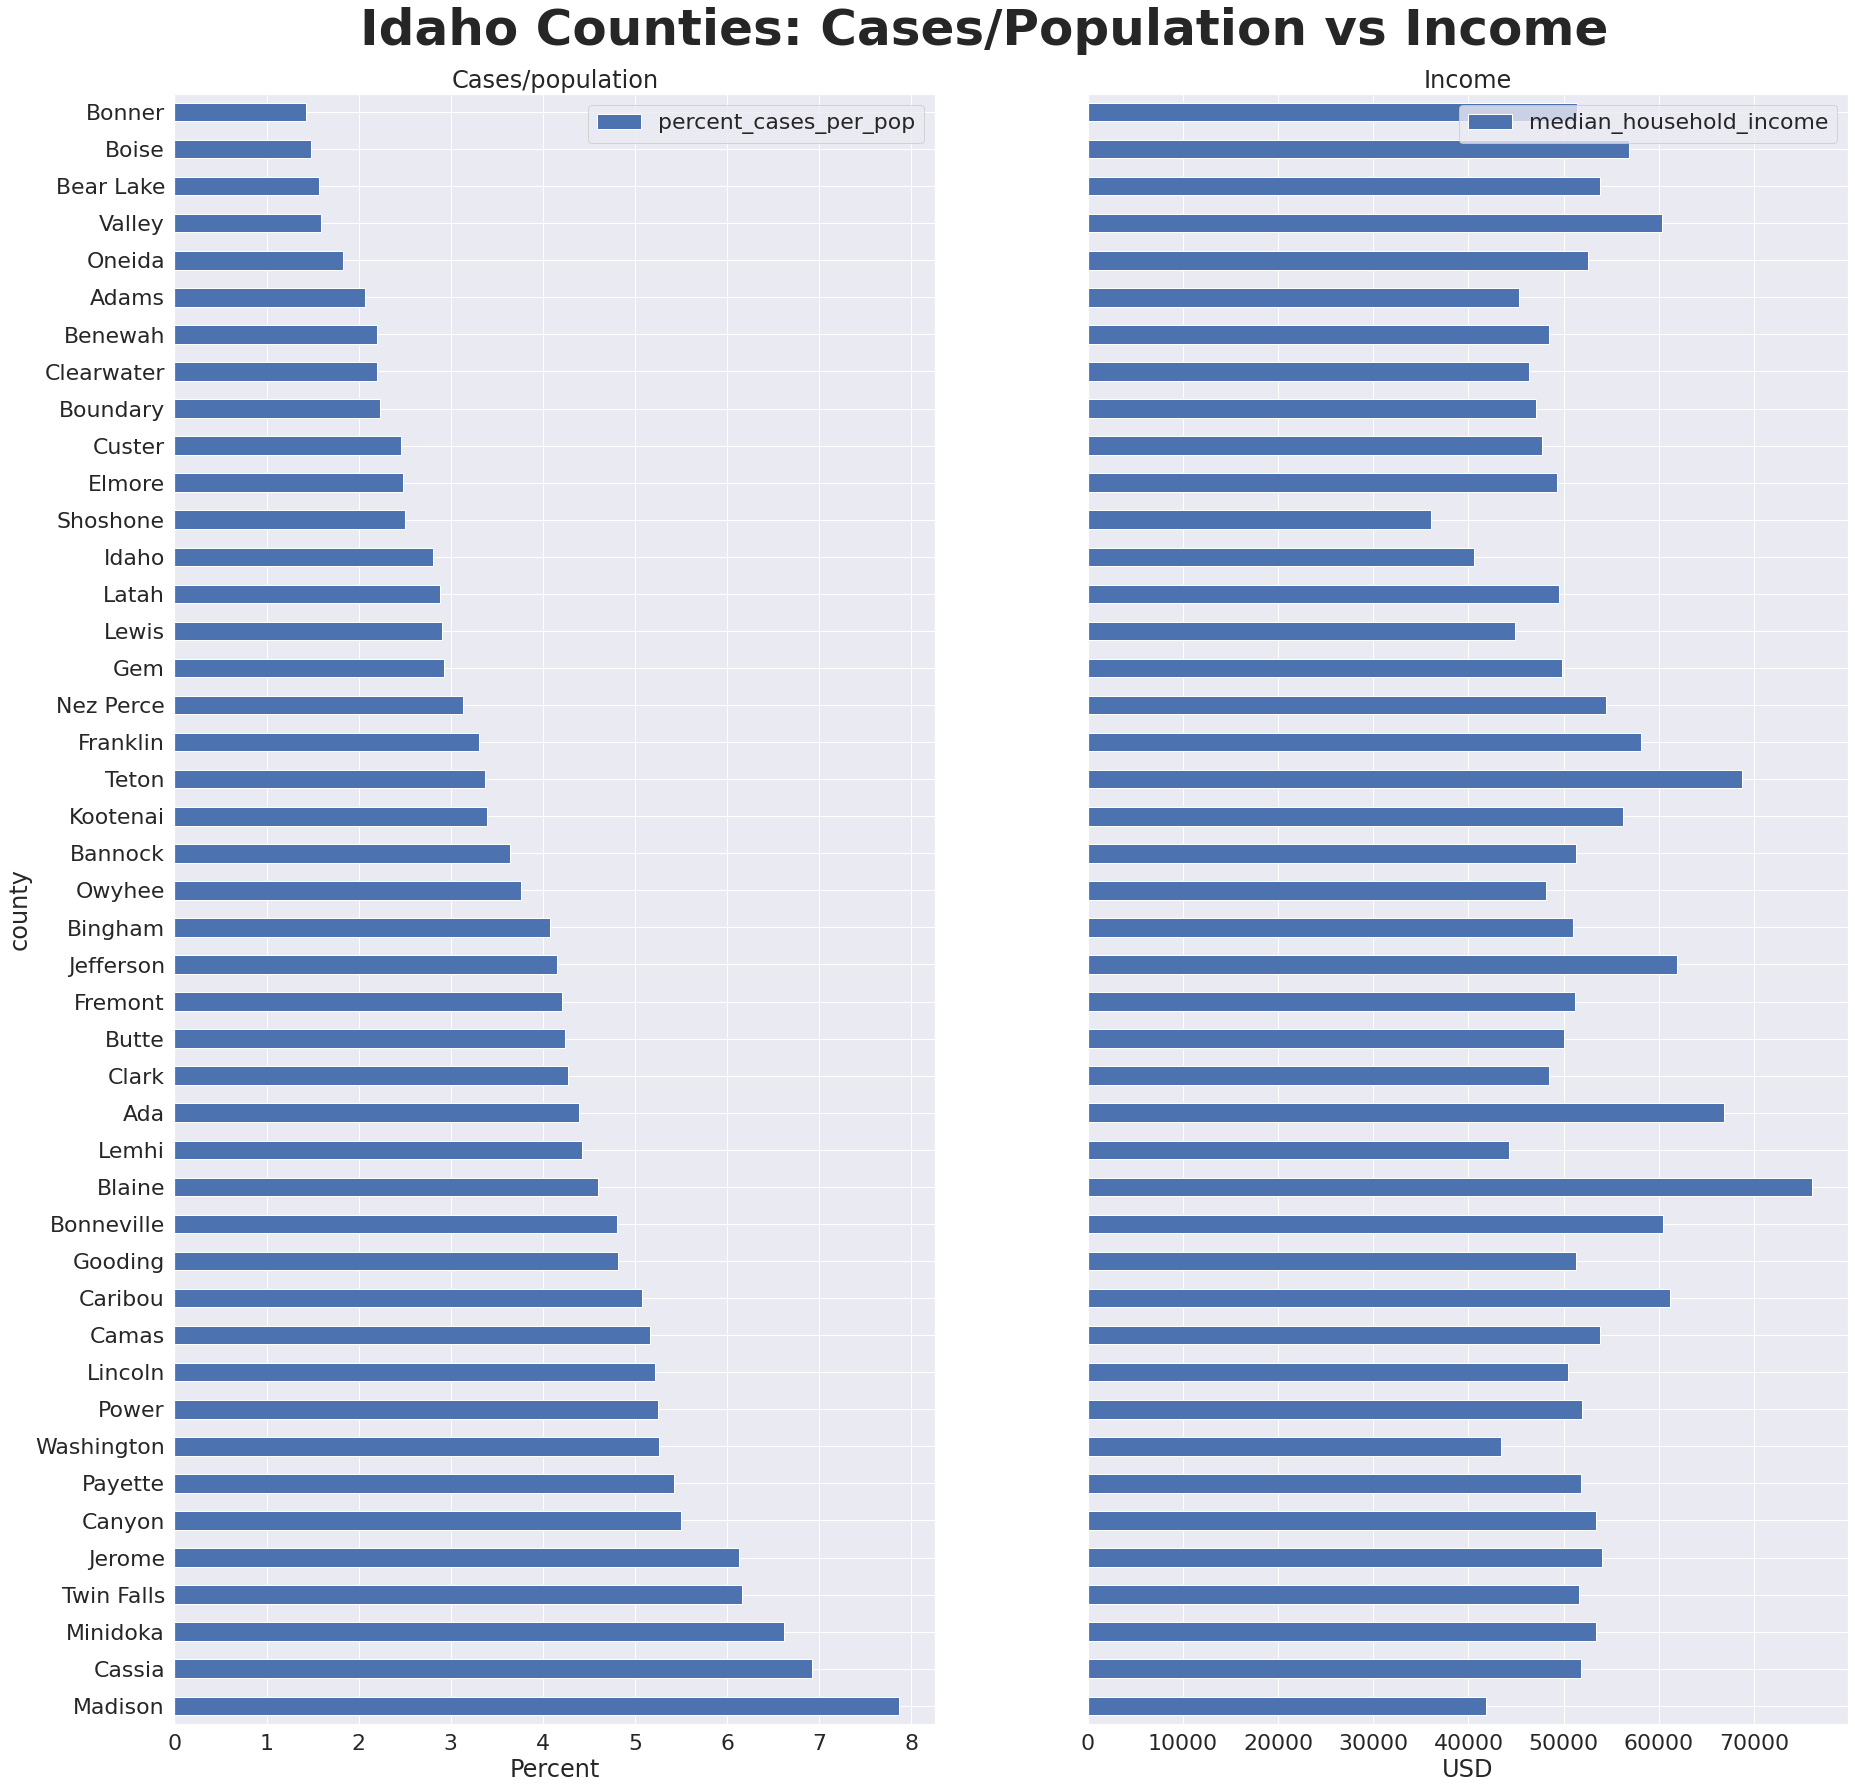

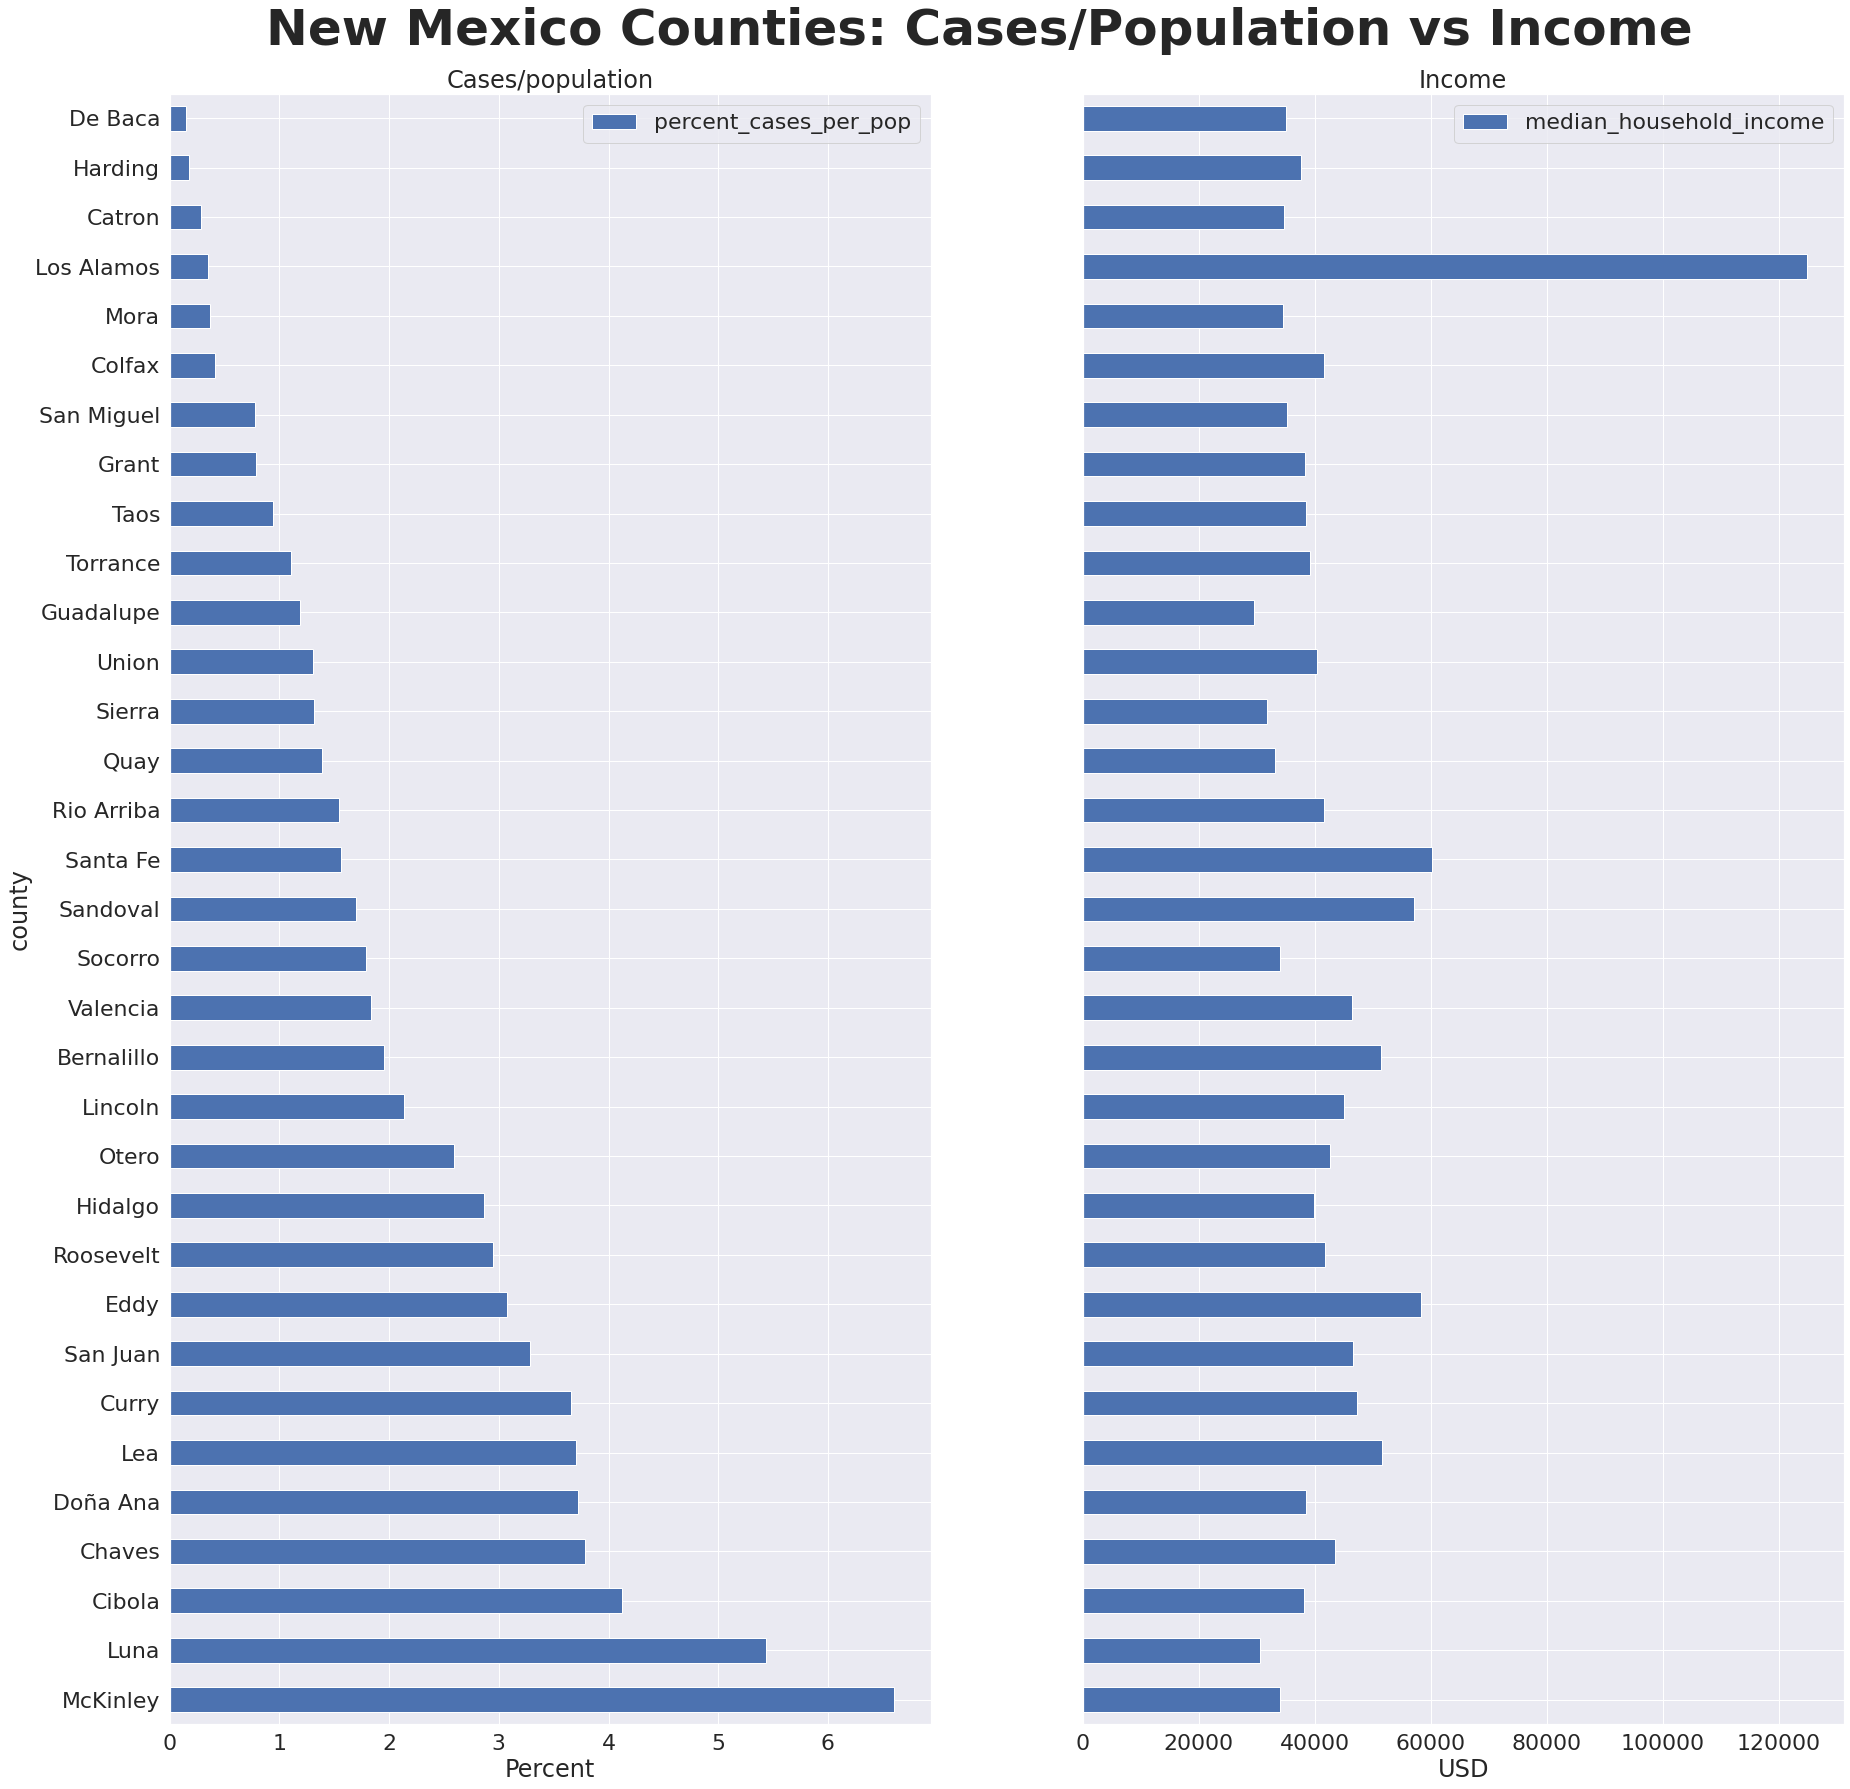

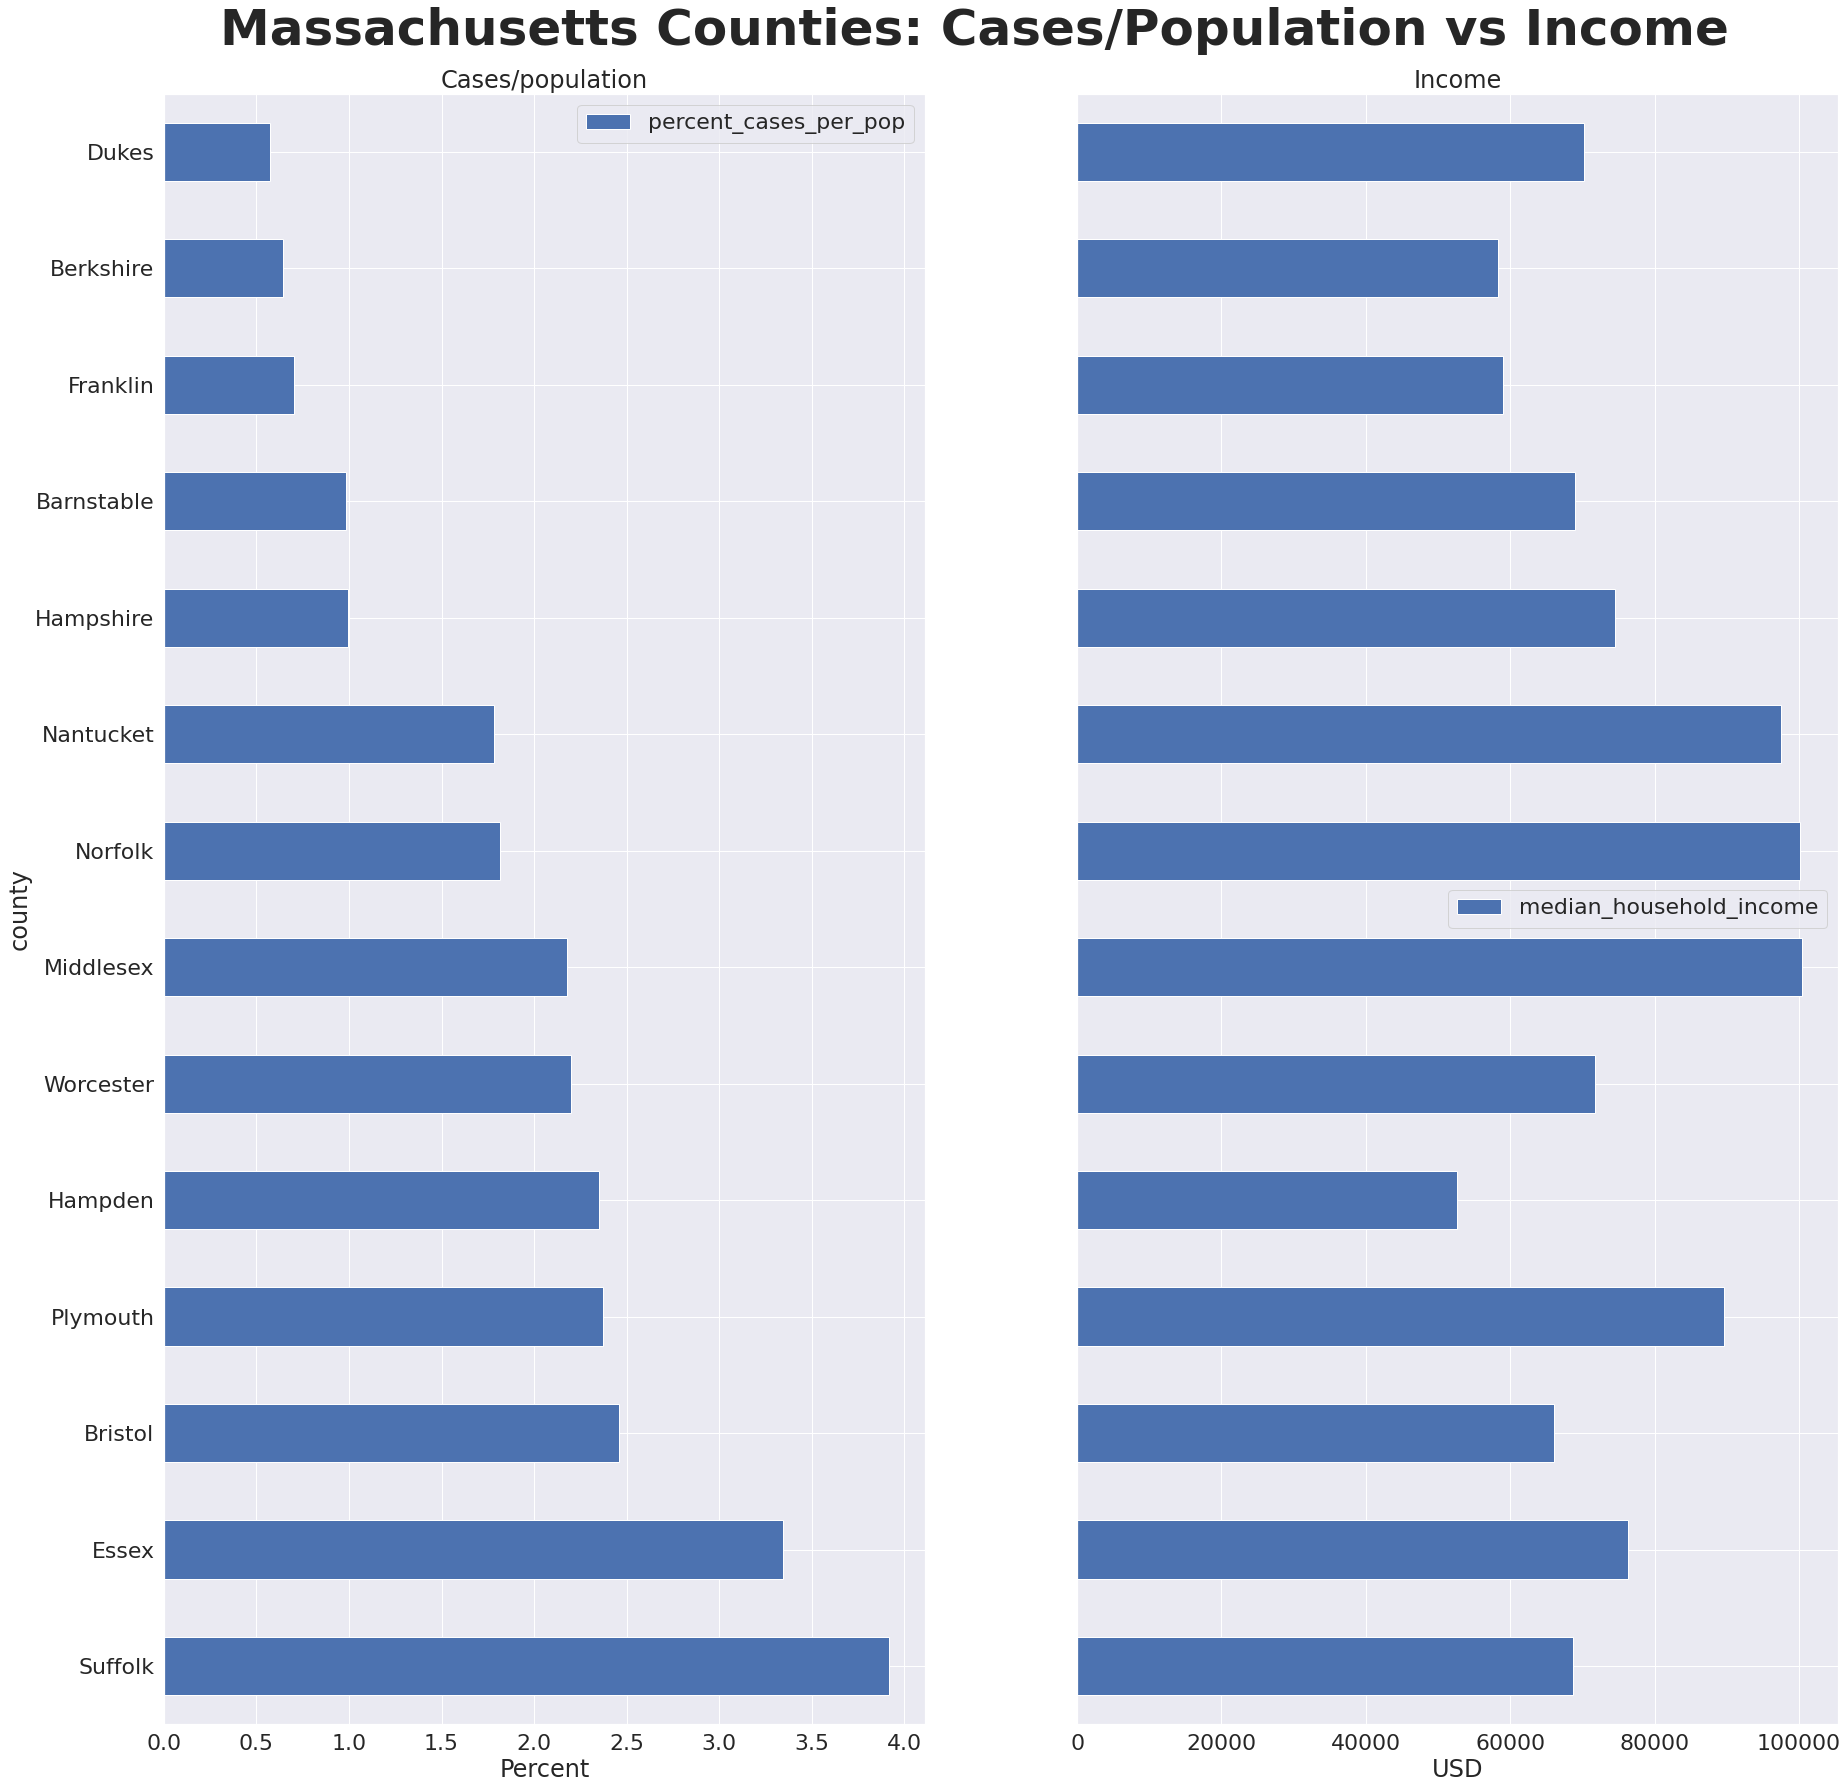

In [26]:
''' California bar graphs '''
fig_income_CA, ax = plt.subplots(1,2, sharey=True)
fig_income_CA.suptitle(titles[0] + ': Cases/Population vs Income',fontweight ="bold", fontsize=50, y=0.92)
ca_socio_df.plot(x="county", y="percent_cases_per_pop", kind="barh", title="Cases/population", ax=ax[0])
ax[0].set_xlabel("Percent")
ca_socio_df.plot(x="county", y="median_household_income", kind="barh", title="Income", ax=ax[1])
ax[1].set_xlabel("USD")
# Finish scatterplot set up and show plots
fig_income_CA.show()
f8 = plt.gcf()

''' Idaho bar graphs '''
fig_income_ID, ax = plt.subplots(1,2, sharey=True)
fig_income_ID.suptitle(titles[1] + ': Cases/Population vs Income',fontweight ="bold", fontsize=50, y=0.92)
id_socio_df.plot(x="county", y="percent_cases_per_pop", kind="barh", title="Cases/population", ax=ax[0])
ax[0].set_xlabel("Percent")
id_socio_df.plot(x="county", y="median_household_income", kind="barh", title="Income", ax=ax[1])
ax[1].set_xlabel("USD")
# Finish scatterplot set up and show plots
fig_income_ID.show()
f9 = plt.gcf()

''' New Mexico bar graphs '''
fig_income_NM, ax = plt.subplots(1,2, sharey=True)
fig_income_NM.suptitle(titles[2] + ': Cases/Population vs Income',fontweight ="bold", fontsize=50, y=0.92)
nm_socio_df.plot(x="county", y="percent_cases_per_pop", kind="barh", title="Cases/population", ax=ax[0])
ax[0].set_xlabel("Percent")
nm_socio_df.plot(x="county", y="median_household_income", kind="barh", title="Income", ax=ax[1])
ax[1].set_xlabel("USD")
# Finish scatterplot set up and show plots
fig_income_NM.show()
f10 = plt.gcf()

''' Massachusetts bar graphs '''
fig_income_MA, ax = plt.subplots(1,2, sharey=True)
fig_income_MA.suptitle(titles[3] + ': Cases/Population vs Income',fontweight ="bold", fontsize=50, y=0.92)
ma_socio_df.plot(x="county", y="percent_cases_per_pop", kind="barh", title="Cases/population", ax=ax[0])
ax[0].set_xlabel("Percent")
ma_socio_df.plot(x="county", y="median_household_income", kind="barh", title="Income", ax=ax[1])
ax[1].set_xlabel("USD")
# Finish scatterplot set up and show plots
fig_income_MA.show()
f11 = plt.gcf()

So far we have looked at the socioeconomic ratios `percent_rural` (rural/population) and `percent_below_poverty` (below poverty/population) as well as `median_household_income` for each county. We compared this to `percent_cases_per_pop` (the ratio of cases/population for each county) using bar graphs and double bar graphs. The counties were sorted so the counties with a higher ratio of COVID cases are displayed at the top of the scatterplot and at the bottom of the bar graph. This allowed us to compare if there was an similar increasing trend in any of the socioeconomic ratios/factors that we listed above. 

Based on our EDA, although some states displayed an increase of COVID cases in less rural counties, there does not appear to be a significant relationship between percentage of COVID cases and socioeconomic factors. This holds true across each state representing the four regions that make up the United States. 

### Examining deaths per cases 

Since there did not appear to be a clear relationship with socioeconomic factors and `percent_cases_per_pop` (cases/population), we decided to explore `percent_deaths_per_cases` (deaths/cases) to see if we found a relationship with this ratio. We are beginning our EDA into `percent_deaths_per_cases` by only looking at the state of California. If any relationships are found here, we will expand our EDA into the other 3 regions we previously explored.

#### Setup
We resorted our dataset to be sorted in descending order by `percent_deaths_per_cases`. This is so we can visualize our data for `percent_deaths_per_cases` in the same way that we visualized our data previously for `percent_cases_per_pop`.

In [27]:
ca_socio_df = ca_socio_df.sort_values(by=['percent_deaths_per_cases'],ascending=False)

#### California: Percent Deaths of Cases vs Percent Cases of Population
Below, we compare death/cases with cases/population to see if there is a relationship by comparing the trends. The graph is sorted by deaths per cases to more easily see a common trend, if any. Based off the visualization, we can see that there is a different pattern between the two variables. This is exciting moving forwards as this can lead to different relationships found between `percent_deaths_per_cases` and other socioeconomic factors.

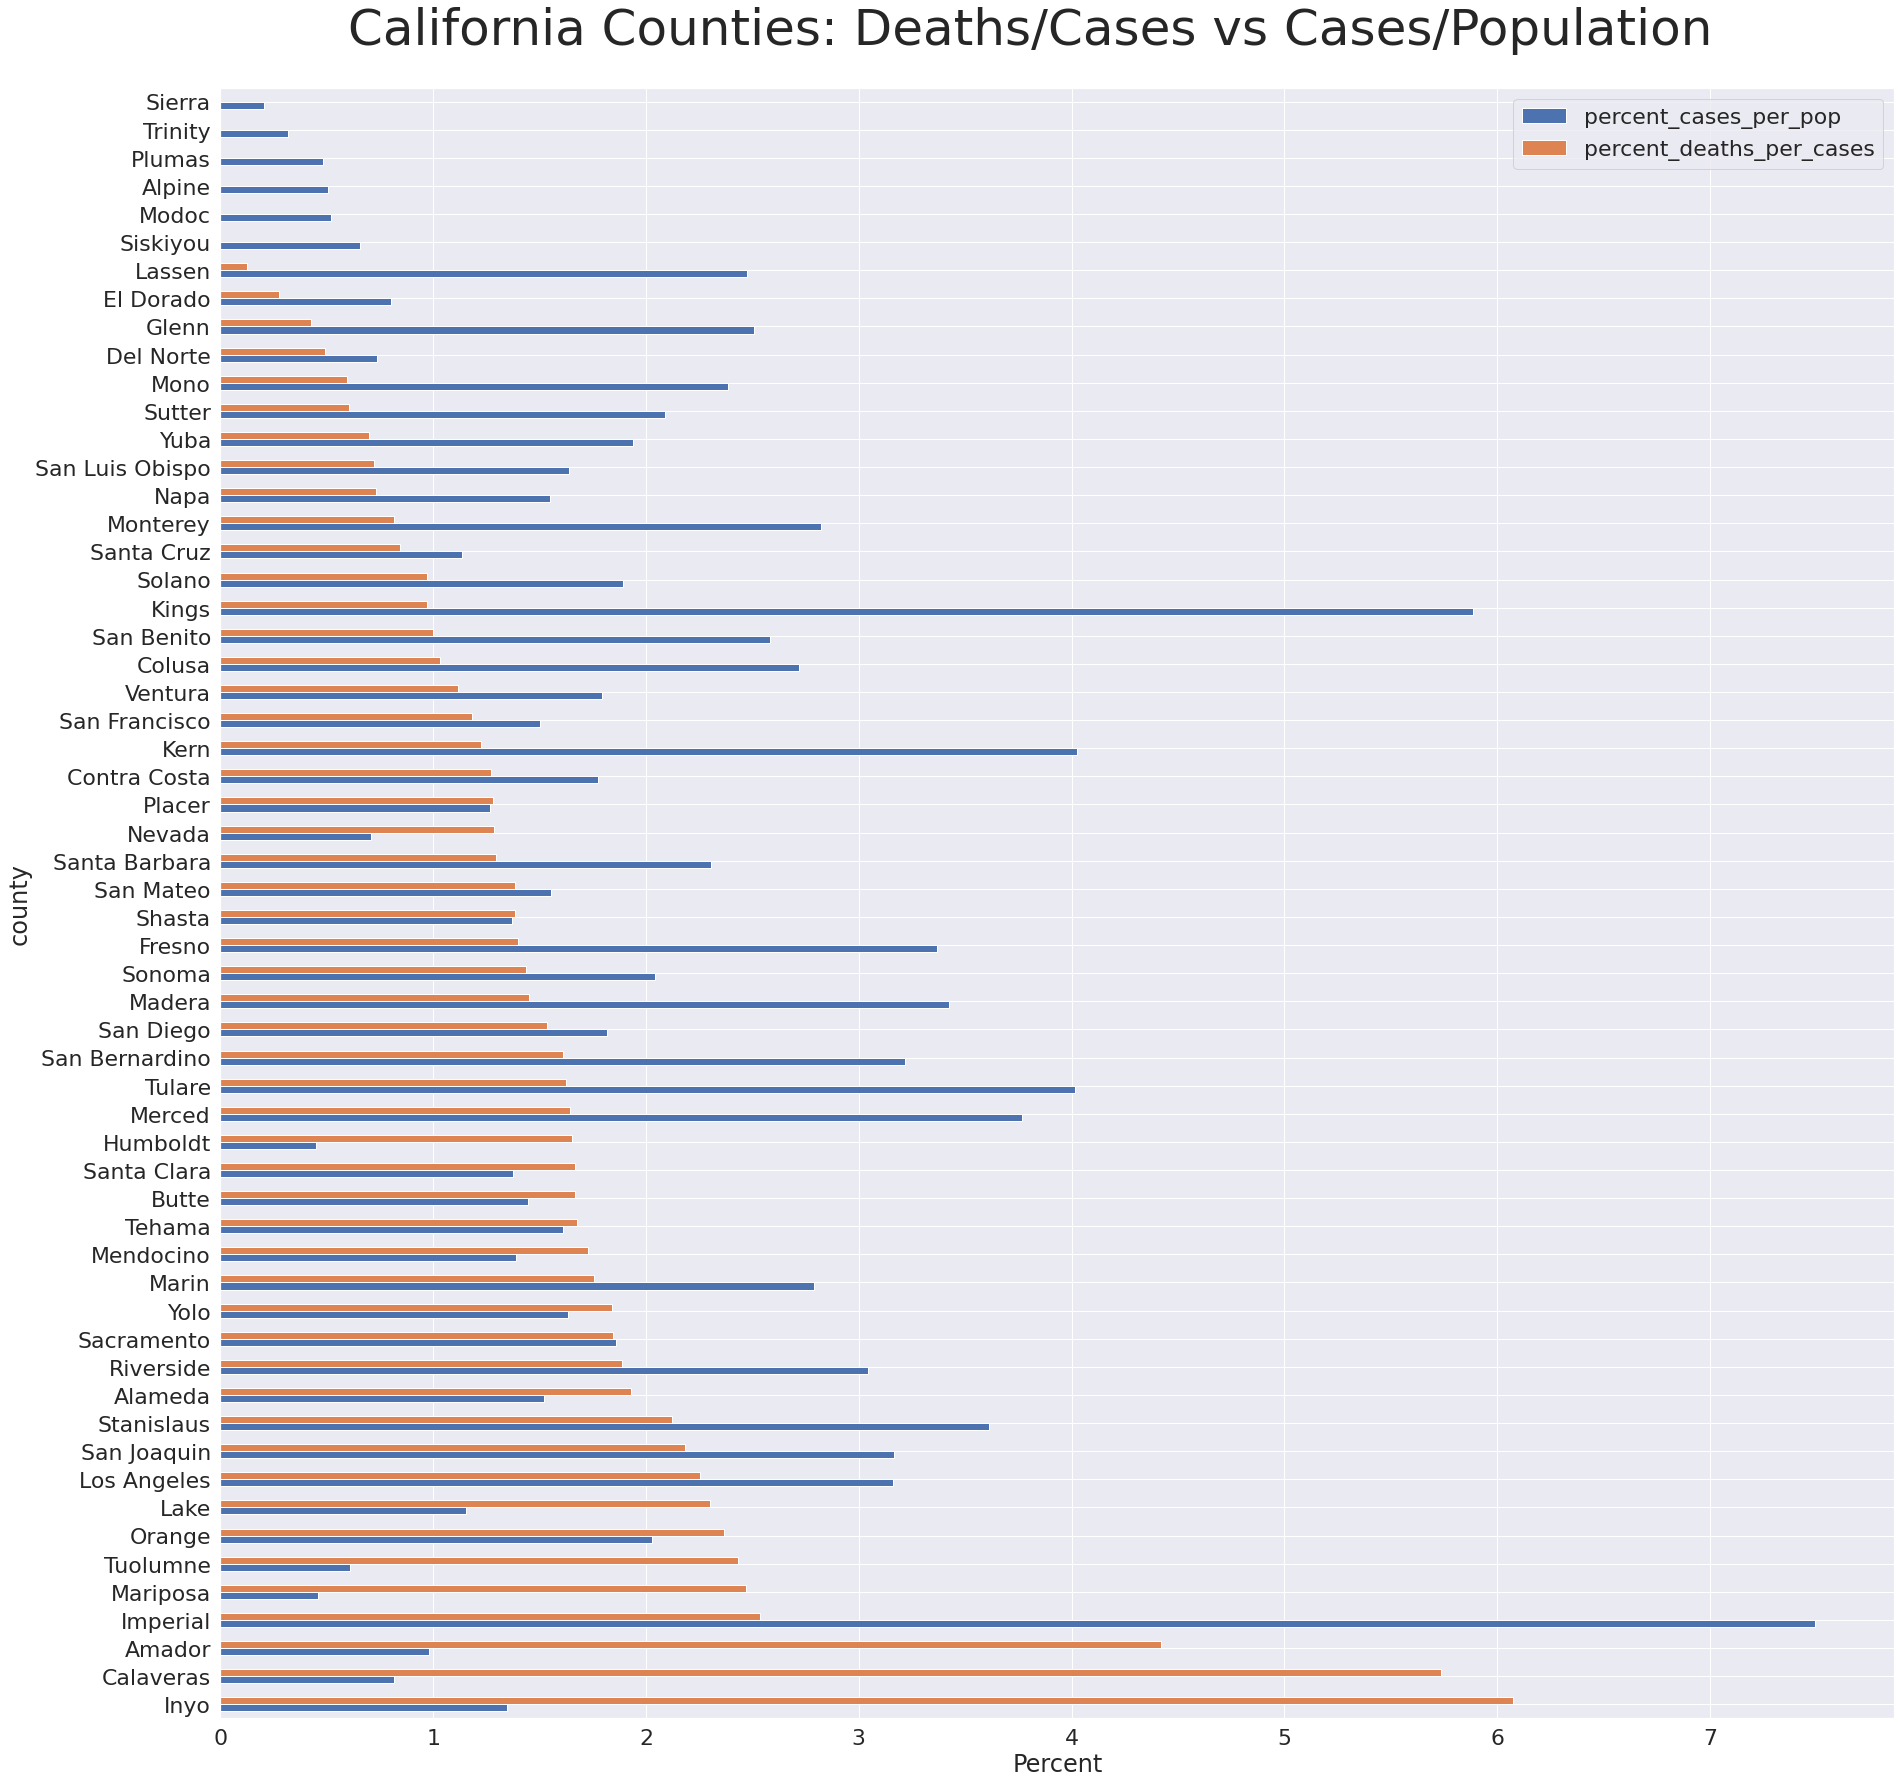

In [28]:
title_text = titles[0]+': Deaths/Cases vs Cases/Population'
ax = ca_socio_df.plot(x="county", y=["percent_cases_per_pop", "percent_deaths_per_cases"], kind='barh')
ax.set_xlabel("Percent")
plt.rcParams["figure.figsize"] = (50,50)
plt.figtext(s=title_text, x = 0.5, y = 0.90, fontsize = 50, ha='center')
f12 = plt.gcf()

#### California: Percent Deaths of Cases vs Percent below Poverty 
We decided to look at one of the socioeconomic factors from our earlier EDA (`percent_below_poverty`) to see if `percent_deaths_per_cases` has any relationship with these types of factors. Since we are exploring the death/cases relationship with other factors, we are only working with California at this time. We decided to only expand our EDA further if we saw a correlation within California. Based off the visualization, there appears to be no relationship between deaths/cases and percent below poverty, so we decided to move on to exploring other socioeconomic factors.

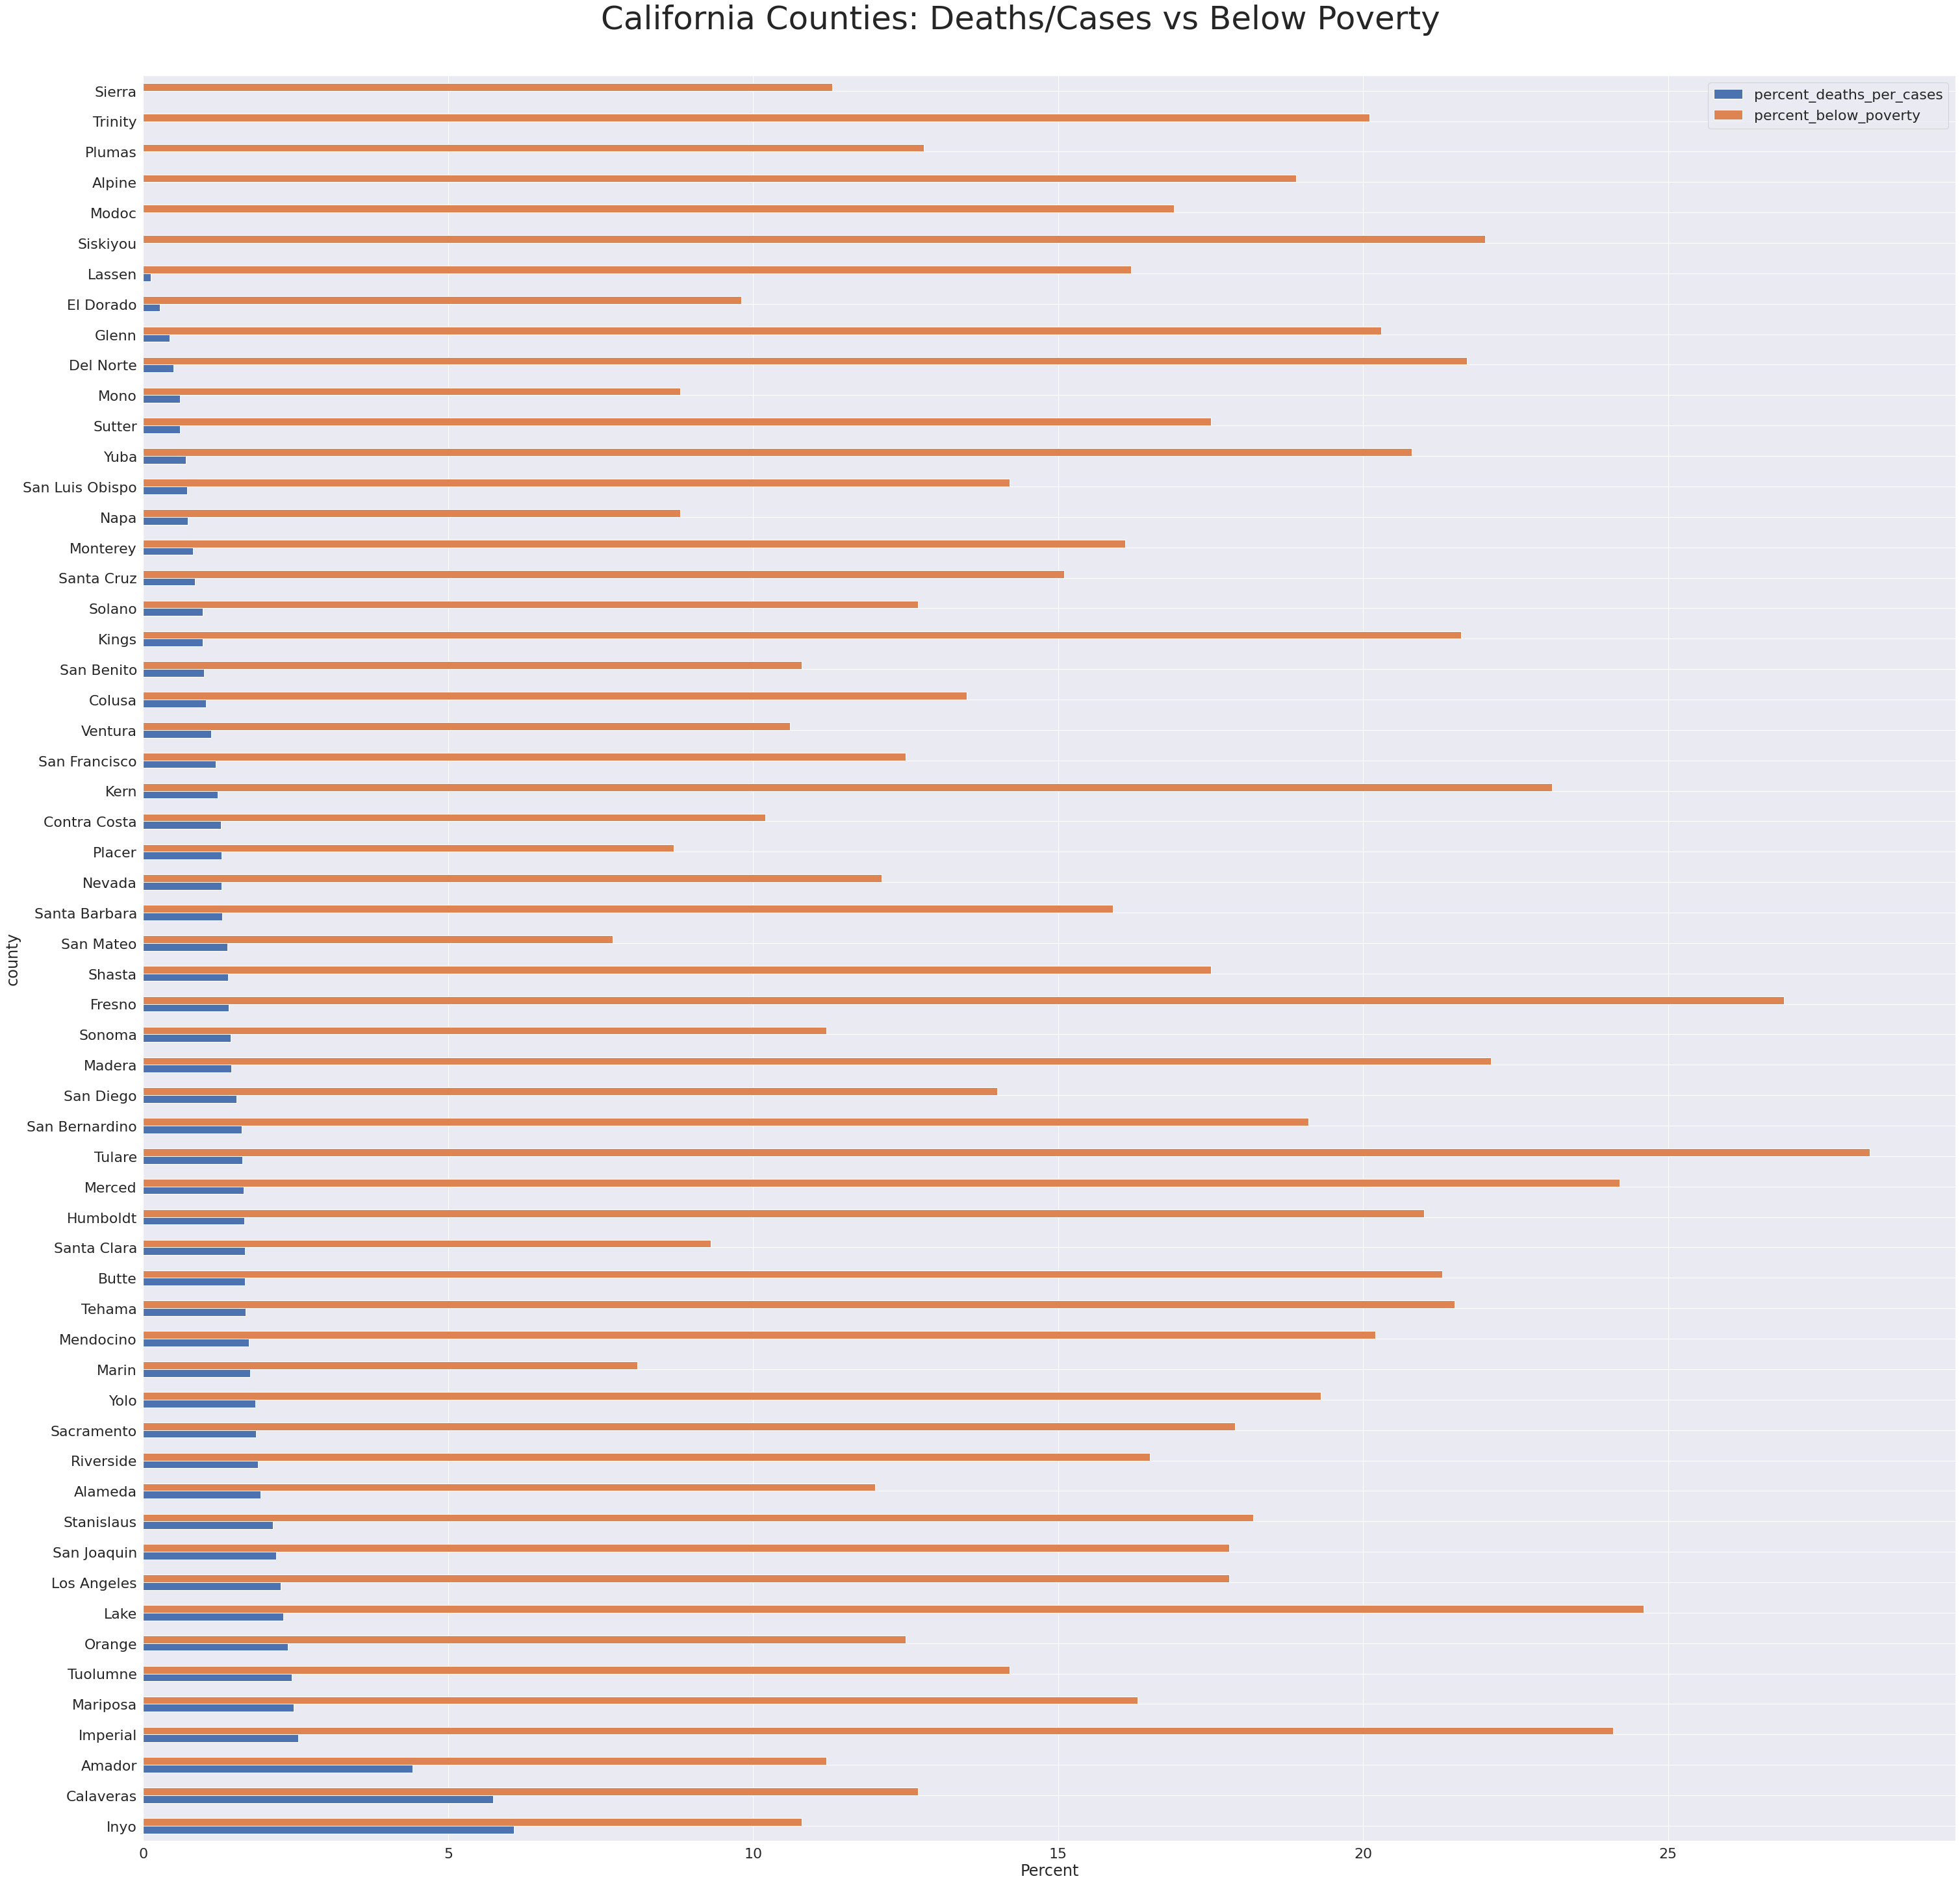

In [29]:
title_text = titles[0]+': Deaths/Cases vs Below Poverty'
ax = ca_socio_df.plot(x="county", y=["percent_deaths_per_cases", "percent_below_poverty"], kind="barh")
ax.set_xlabel("Percent")
plt.rcParams["figure.figsize"] = (50,50)
plt.figtext(s=title_text, x = 0.5, y = 0.90, fontsize = 50, ha='center')
f13 = plt.gcf()

#### Deaths/cases and Underlying Health Conditions
We wanted to see if there was any relationships between underlying health conditions and `percent_deaths_per_cases`. We are interested in looking for a relationship between these variables because we want to see if comorbidity has any effect on the case fatality rate for COVID-19. Further, we also sort the dataset by and display median household income to see if there is a relationship between these underlying health conditions and median household income. This is interesting because these factors can give insight on if household income is related to the presence of underlying health conditions in a county.

##### California: Deaths/cases compared with adults with obesity and household income
Here, we are examining `percent_deaths_per_cases` displayed in comparison to `percent_adults_with_obesity` in a double gar graph. That graph is being displayed in relation to `median_household_income`. In this visualization we are looking for a relationship between `percent_deaths_per_cases` and `percent_adults_with_obesity`. Additionally, we are also looking to see if there is a relationship between one of both of those factors and `median_household_income`. Both graphs are sorted in descending order based on `median_household_income` to better see any income based relationships. Based off of these visualizations, we did not see a relationship between `percent_deaths_per_cases` and `percent_adults_with_obesity` or `percent_deaths_per_cases` and `median_household_income`. However, we can see a general trend where `percent_adults_with_obesity` tends to decrease as `median_household_income` increases. This shows that there is an inverse relationship between `percent_adults_with_obesity` and `median_household_income.

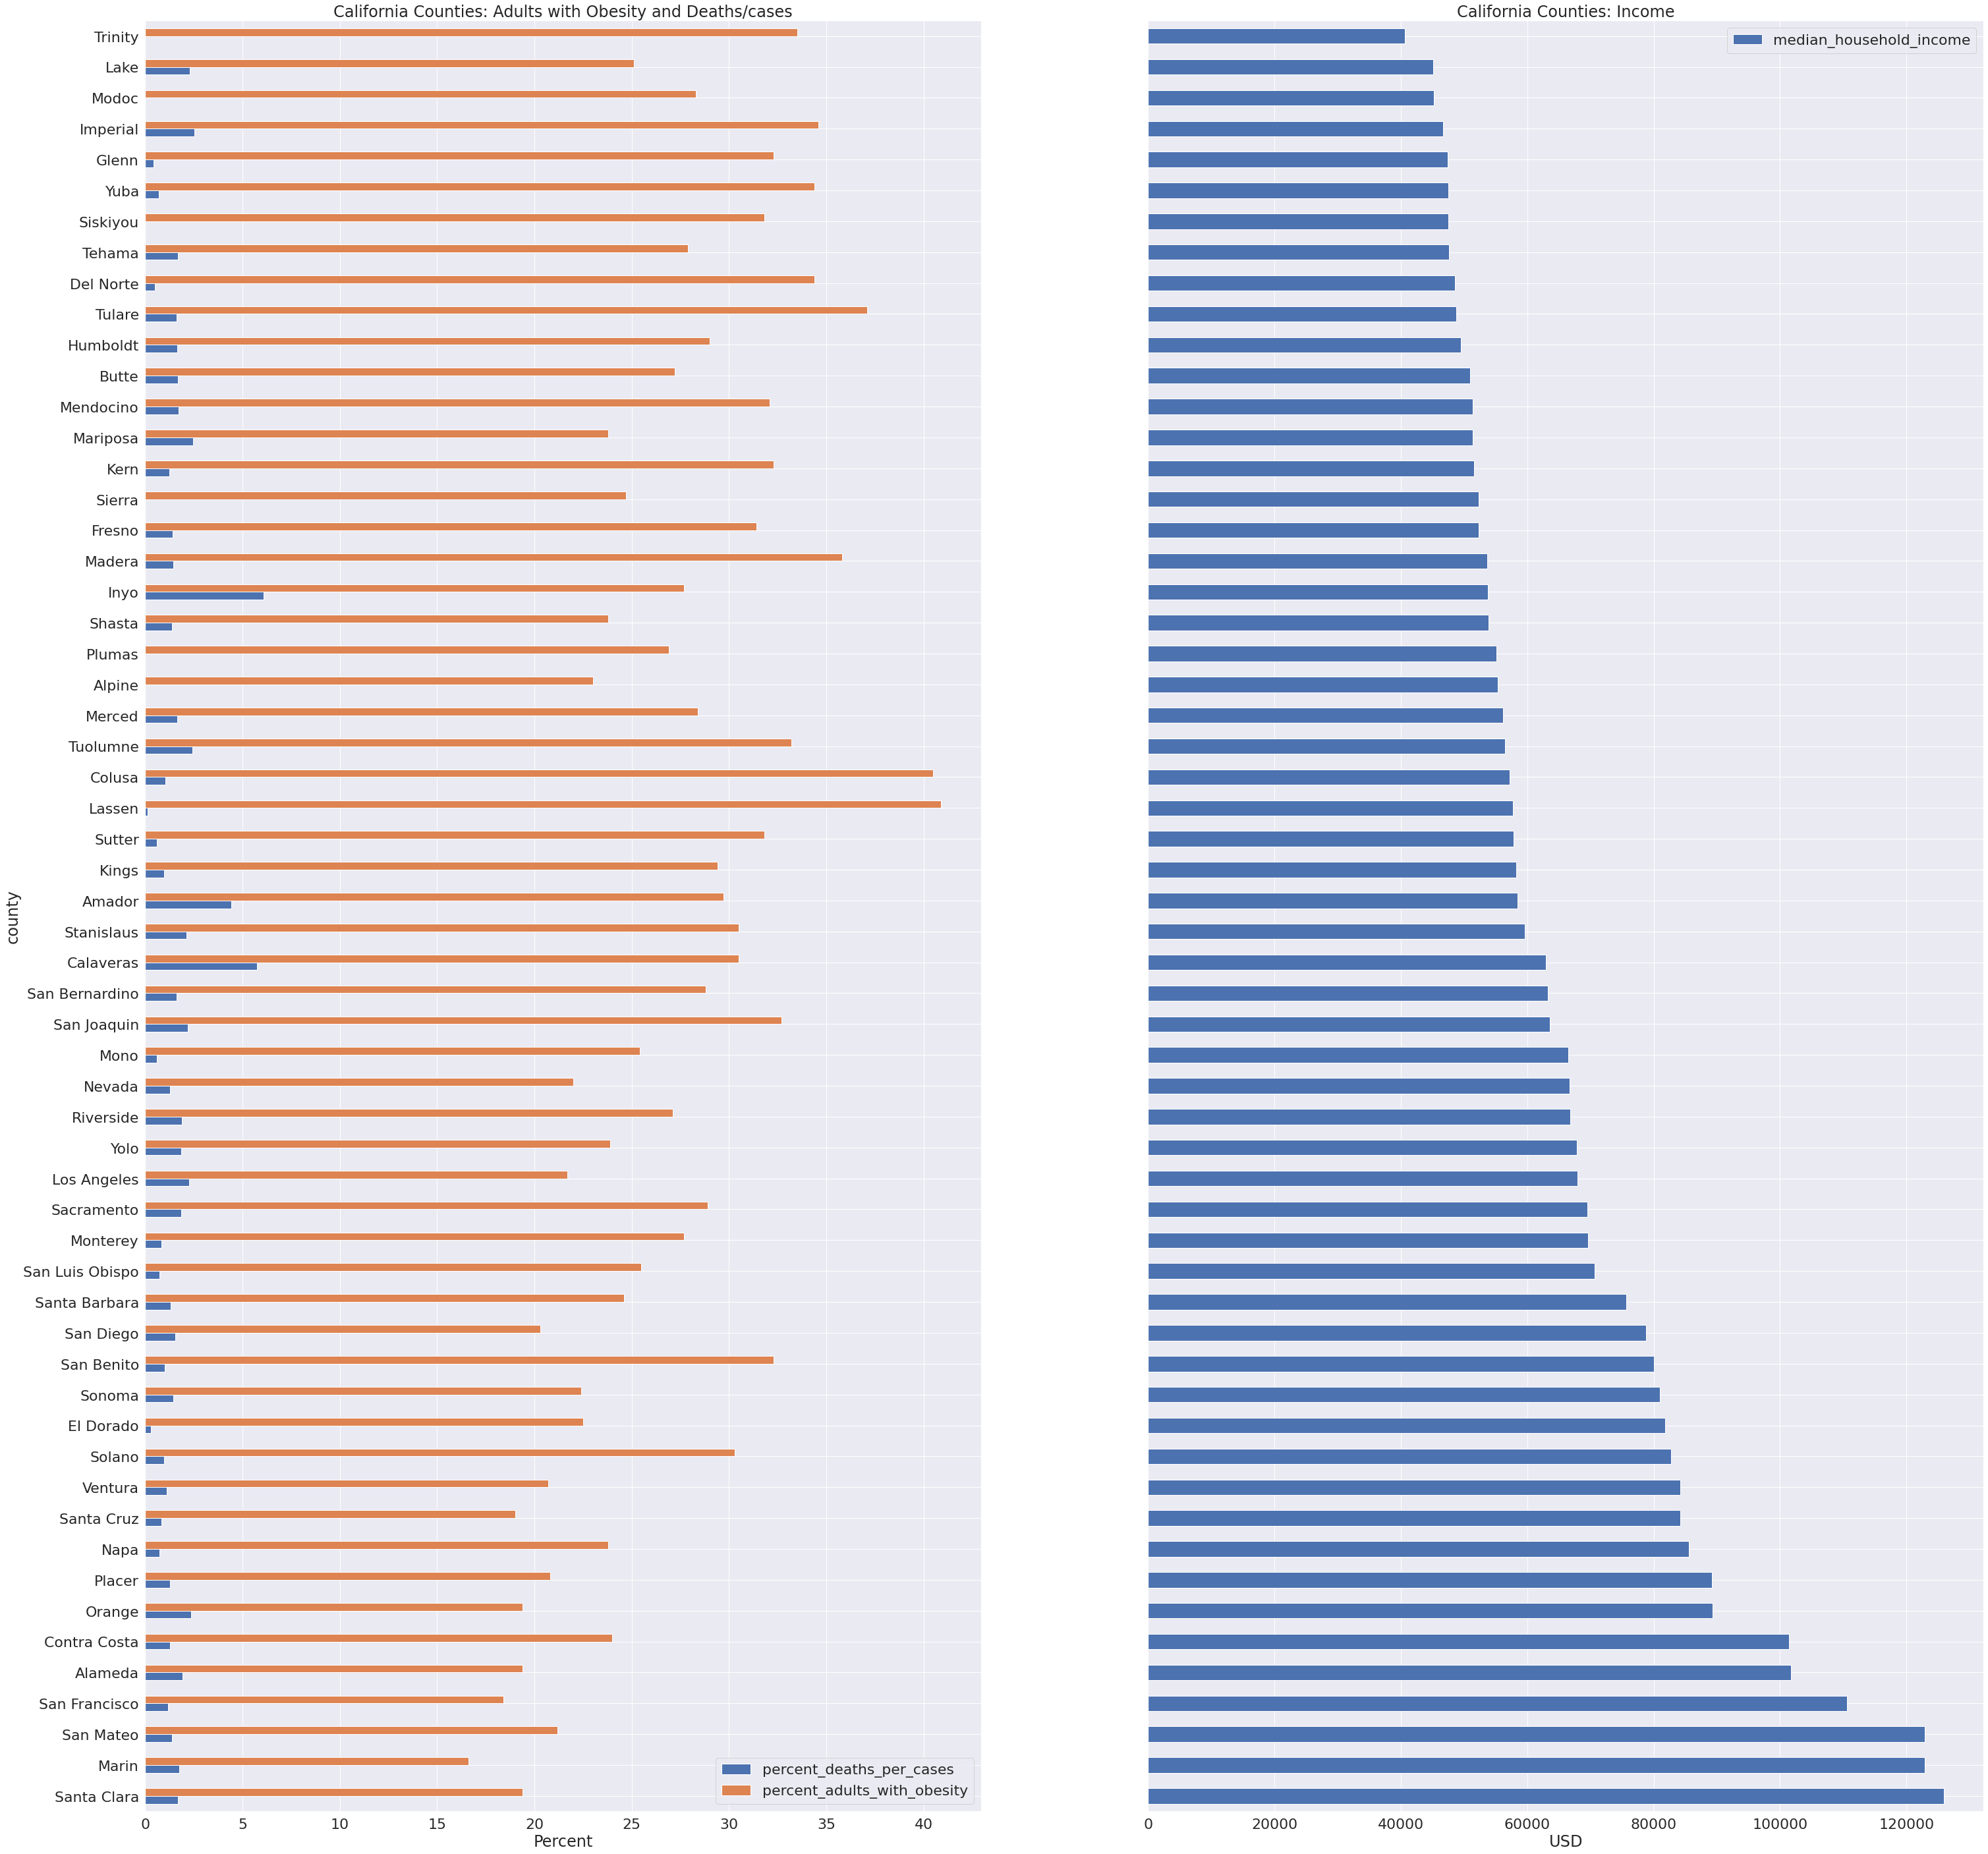

In [30]:
fig, ax = plt.subplots(1,2, sharey=True)
ca_socio_df = ca_socio_df.sort_values(by=['median_household_income'],ascending=False)

obesity_deaths_title = titles[0] + ": Adults with Obesity and Deaths/cases"
ca_socio_df.plot(x="county", y=["percent_deaths_per_cases", "percent_adults_with_obesity"], kind="barh", title=obesity_deaths_title, ax=ax[0])
ax[0].set_xlabel("Percent")

income_title = titles[0] + ": Income"
ca_socio_df.plot(x="county", y="median_household_income", kind="barh", title=income_title, ax=ax[1])
ax[1].set_xlabel("USD")
# Finish scatterplot set up and show plots
fig.show()
f14 = plt.gcf()

##### California: Deaths/cases compared with adults with diabetes and household income
Here, we are examining `percent_deaths_per_cases` displayed in comparison to `percent_adults_with_diabetes` in a double gar graph. That graph is being displayed in relation to `median_household_income`. In this visualization we are looking for a relationship between `percent_deaths_per_cases` and `percent_adults_with_diabetes`. Additionally, we are also looking to see if there is a relationship between one of both of those factors and `median_household_income`. Both graphs are sorted in descending order based on `median_household_income` to better see any income based relationships. Based off of these visualizations, we did not see a relationship between `percent_deaths_per_cases` and `percent_adults_with_diabetes` or `percent_deaths_per_cases` and `median_household_income`. However, we can see a general trend where `percent_adults_with_diabetes` tends to decrease as `median_household_income` increases. This shows that there is an inverse relationship between `percent_adults_with_diabetes` and `median_household_income.

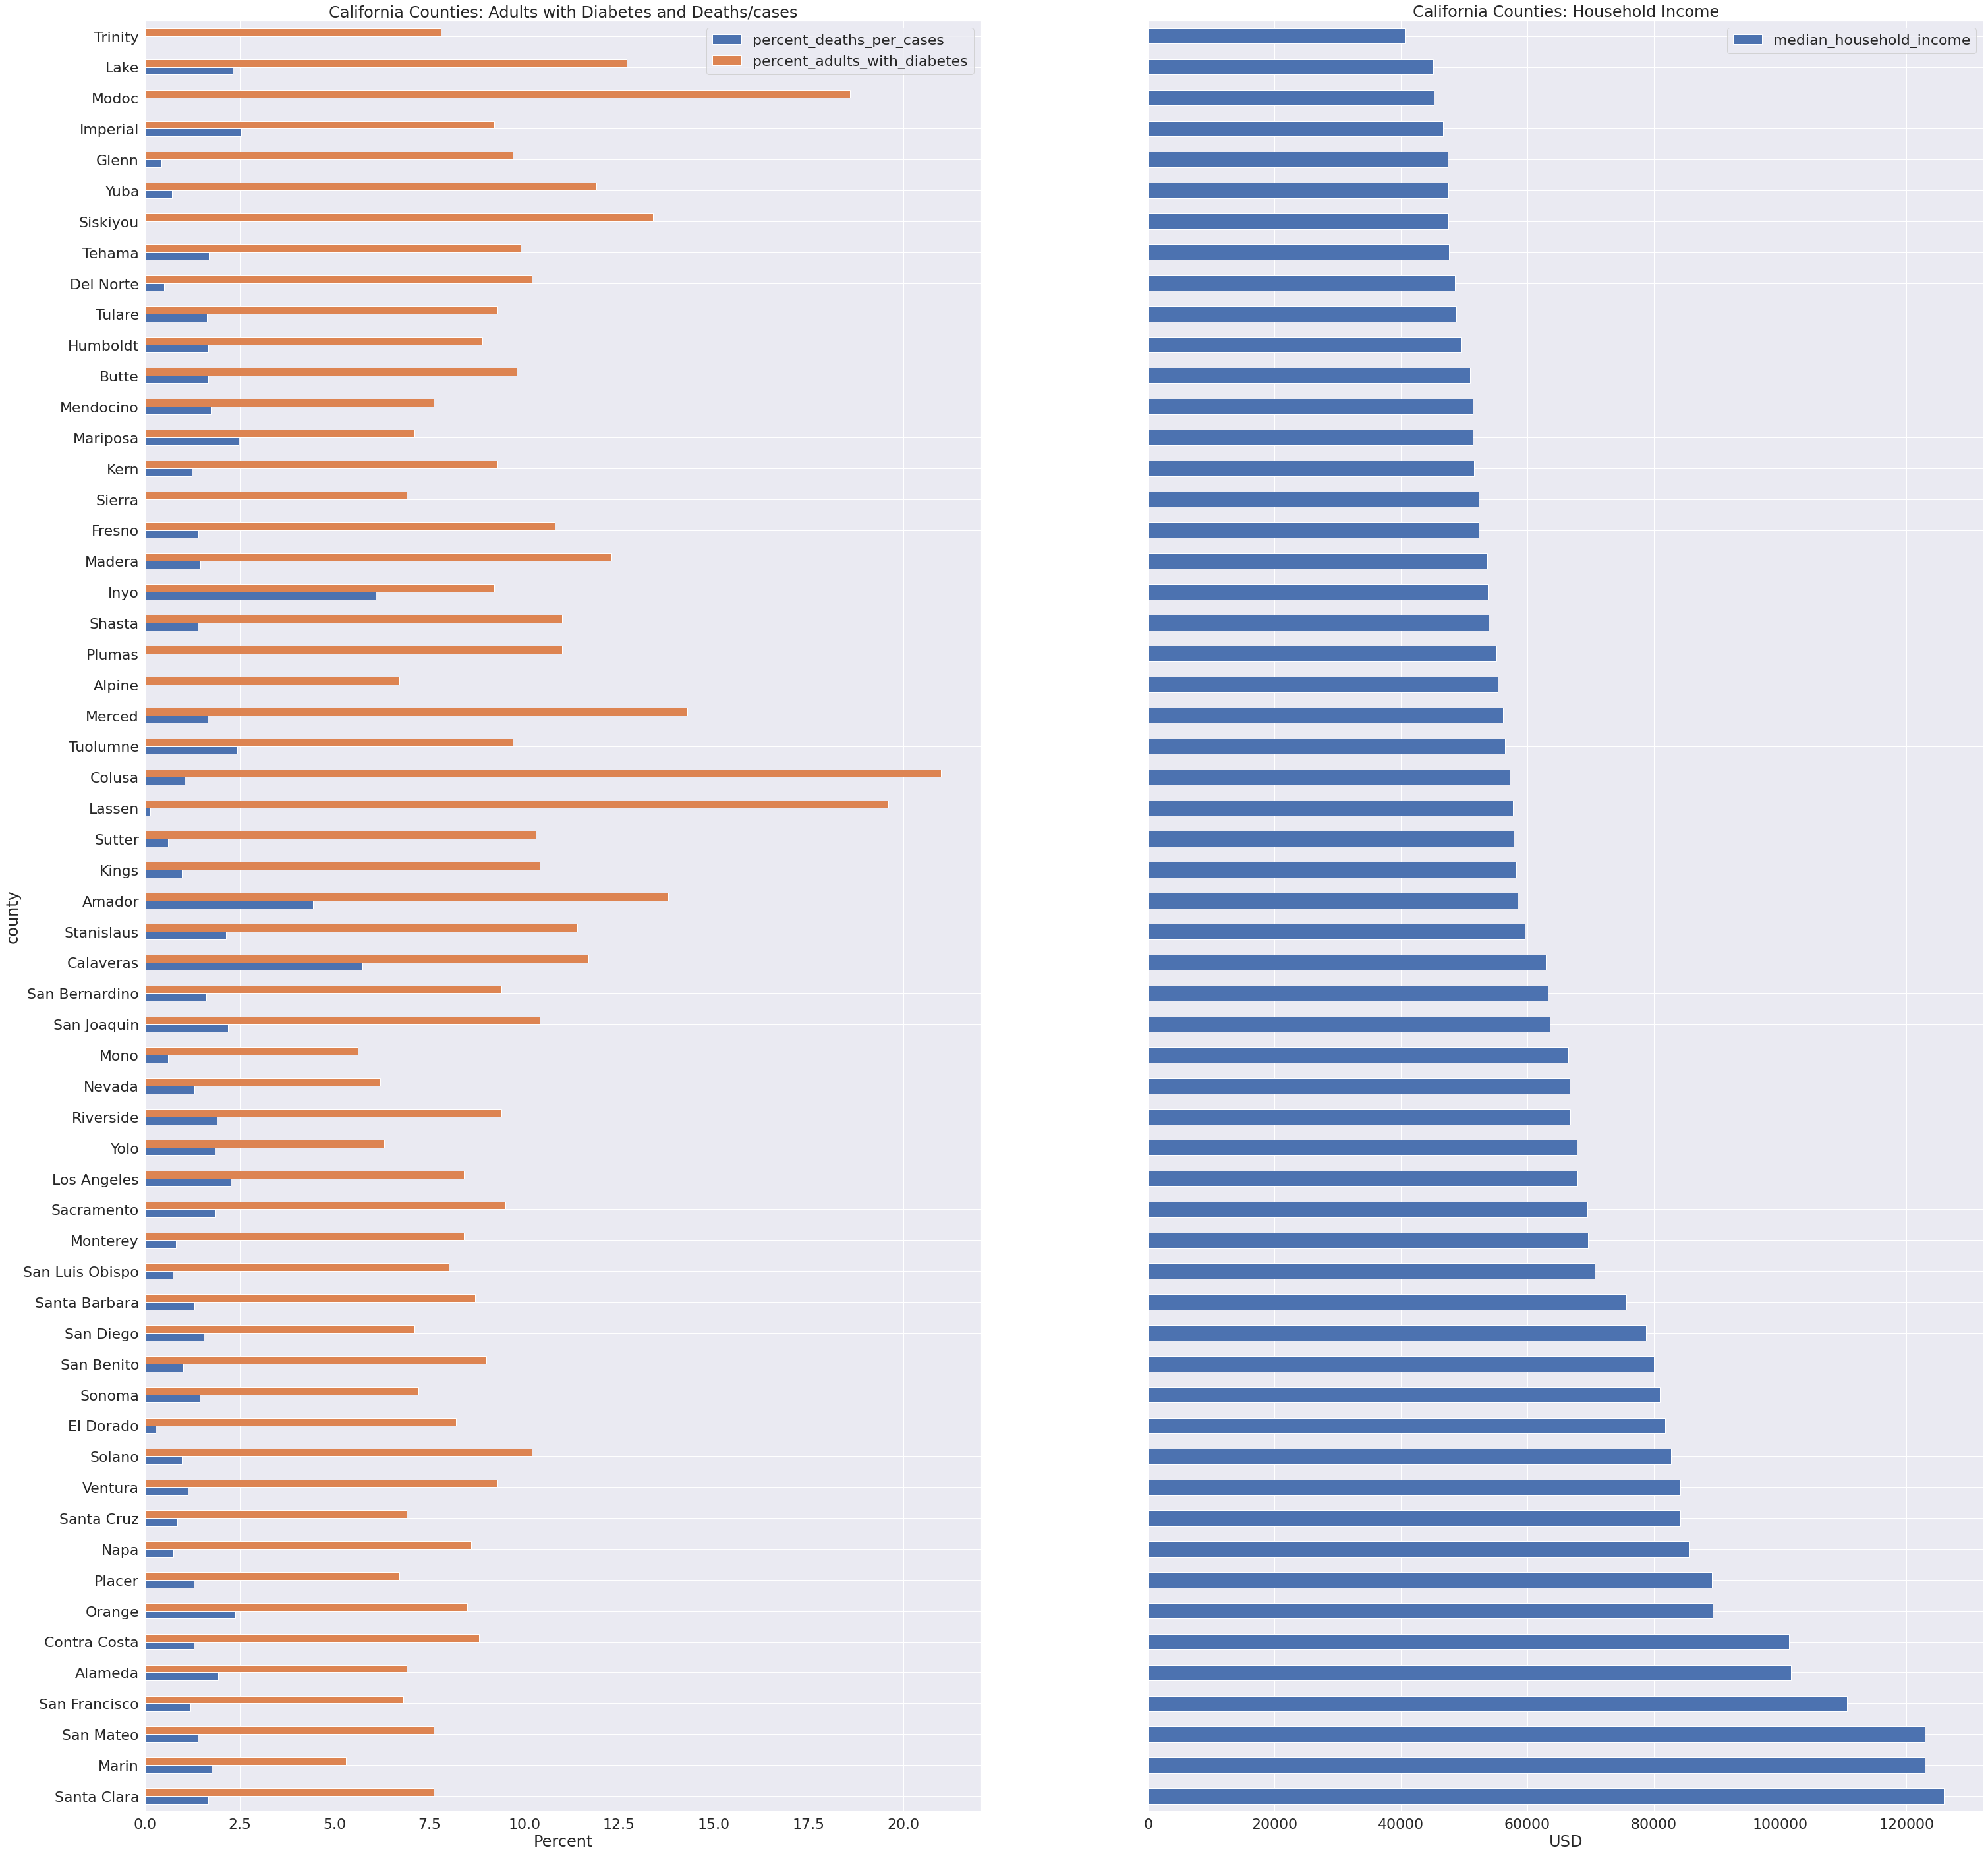

In [31]:
fig, ax = plt.subplots(1,2, sharey=True)

diabetes_deaths_title = titles[0] + ": Adults with Diabetes and Deaths/cases"
ca_socio_df.plot(x="county", y=["percent_deaths_per_cases", "percent_adults_with_diabetes"], kind="barh", title=diabetes_deaths_title, ax=ax[0])
ax[0].set_xlabel("Percent")

income_title = titles[0] + ": Household Income"
ca_socio_df.plot(x="county", y="median_household_income", kind="barh", title=income_title, ax=ax[1])
ax[1].set_xlabel("USD")

# Finish scatterplot set up and show plots
fig.show()
f14 = plt.gcf()

### Socioeconomic EDA Analysis

From comparing `percent_cases_per_pop` (cases/population) and `percent_deaths_per_cases` (deaths/cases) to various socioeconomic factors such as percent below poverty, percentage of the population with various health conditions (obesity/diabetes), household income, and percent rural, we saw no relationship between the ratios and these factors. 

## Race EDA

In [32]:
race = pd.read_csv('race.csv')

In [33]:
race= race.dropna()

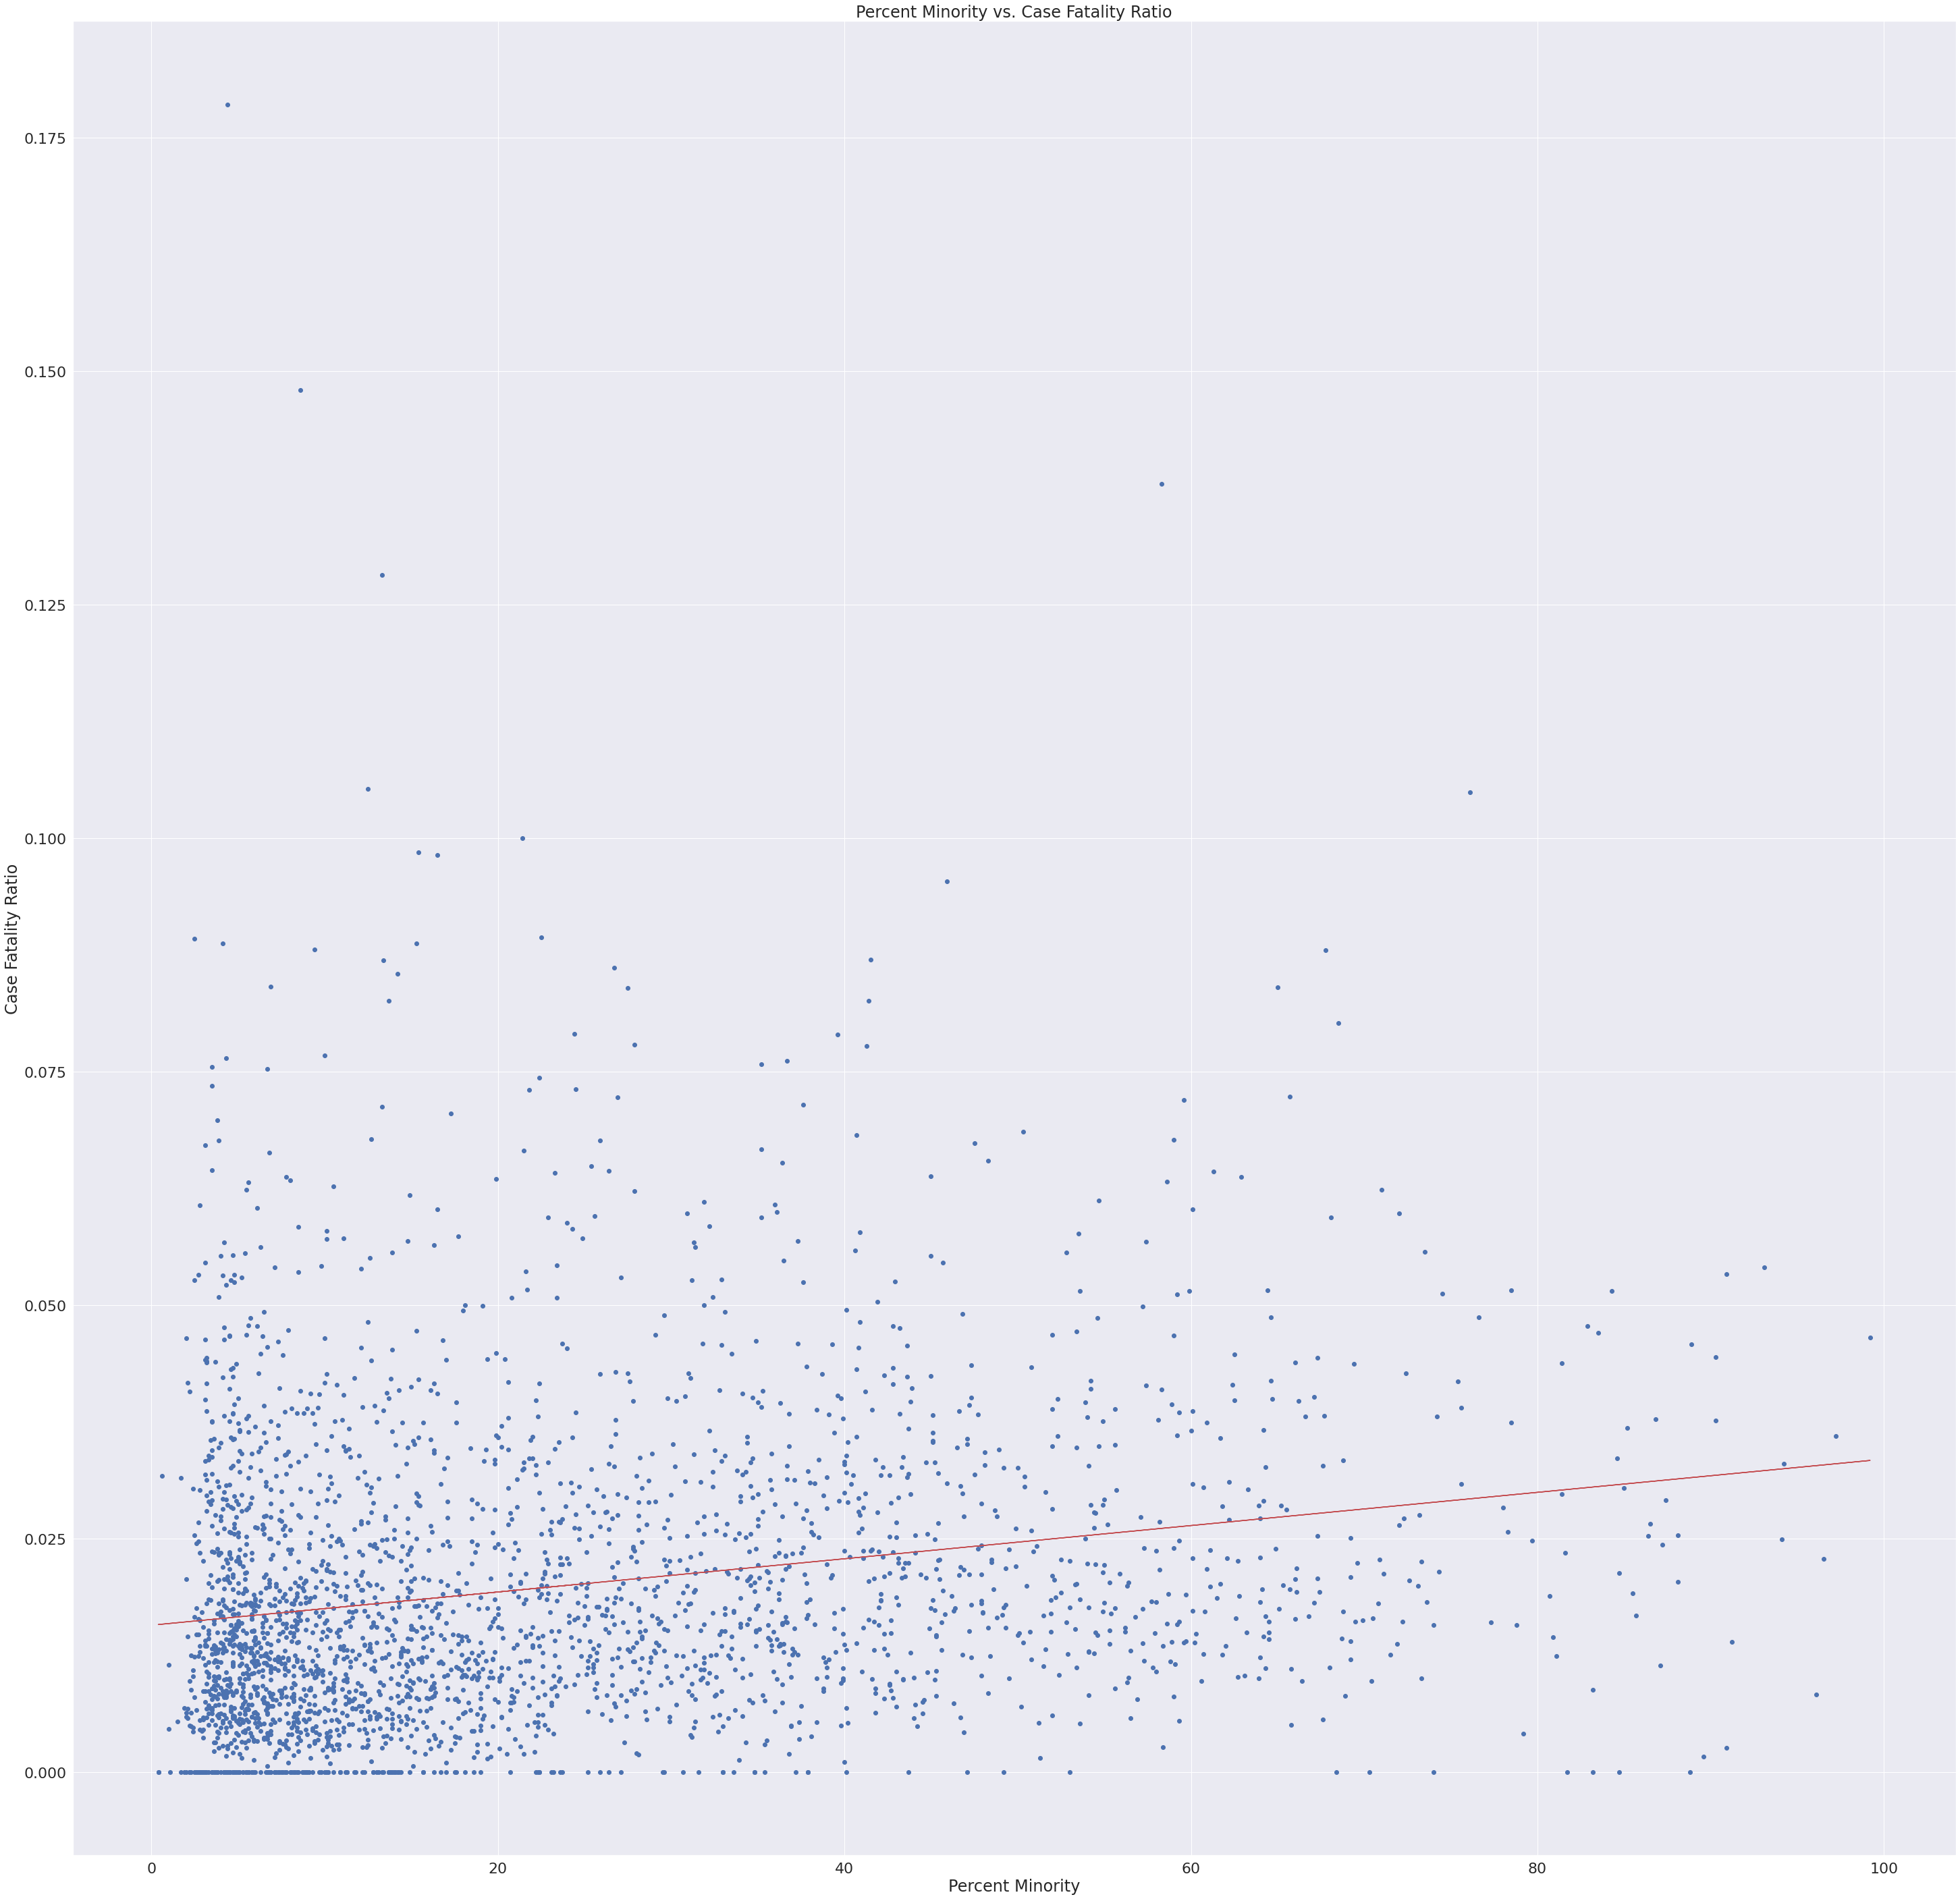

0.00017785959023197876


In [34]:
# Scatter plot of percentage minorities compared to percentage of deaths
plt.scatter(race['percent_minorities'], race['deaths']/race['cases'])
plt.title('Percent Minority vs. Case Fatality Ratio')
plt.xlabel('Percent Minority')
plt.ylabel('Case Fatality Ratio')

x = race['percent_minorities']
y = race['deaths']/race['cases']

b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-', c = 'r')
plt.show()

print(m)

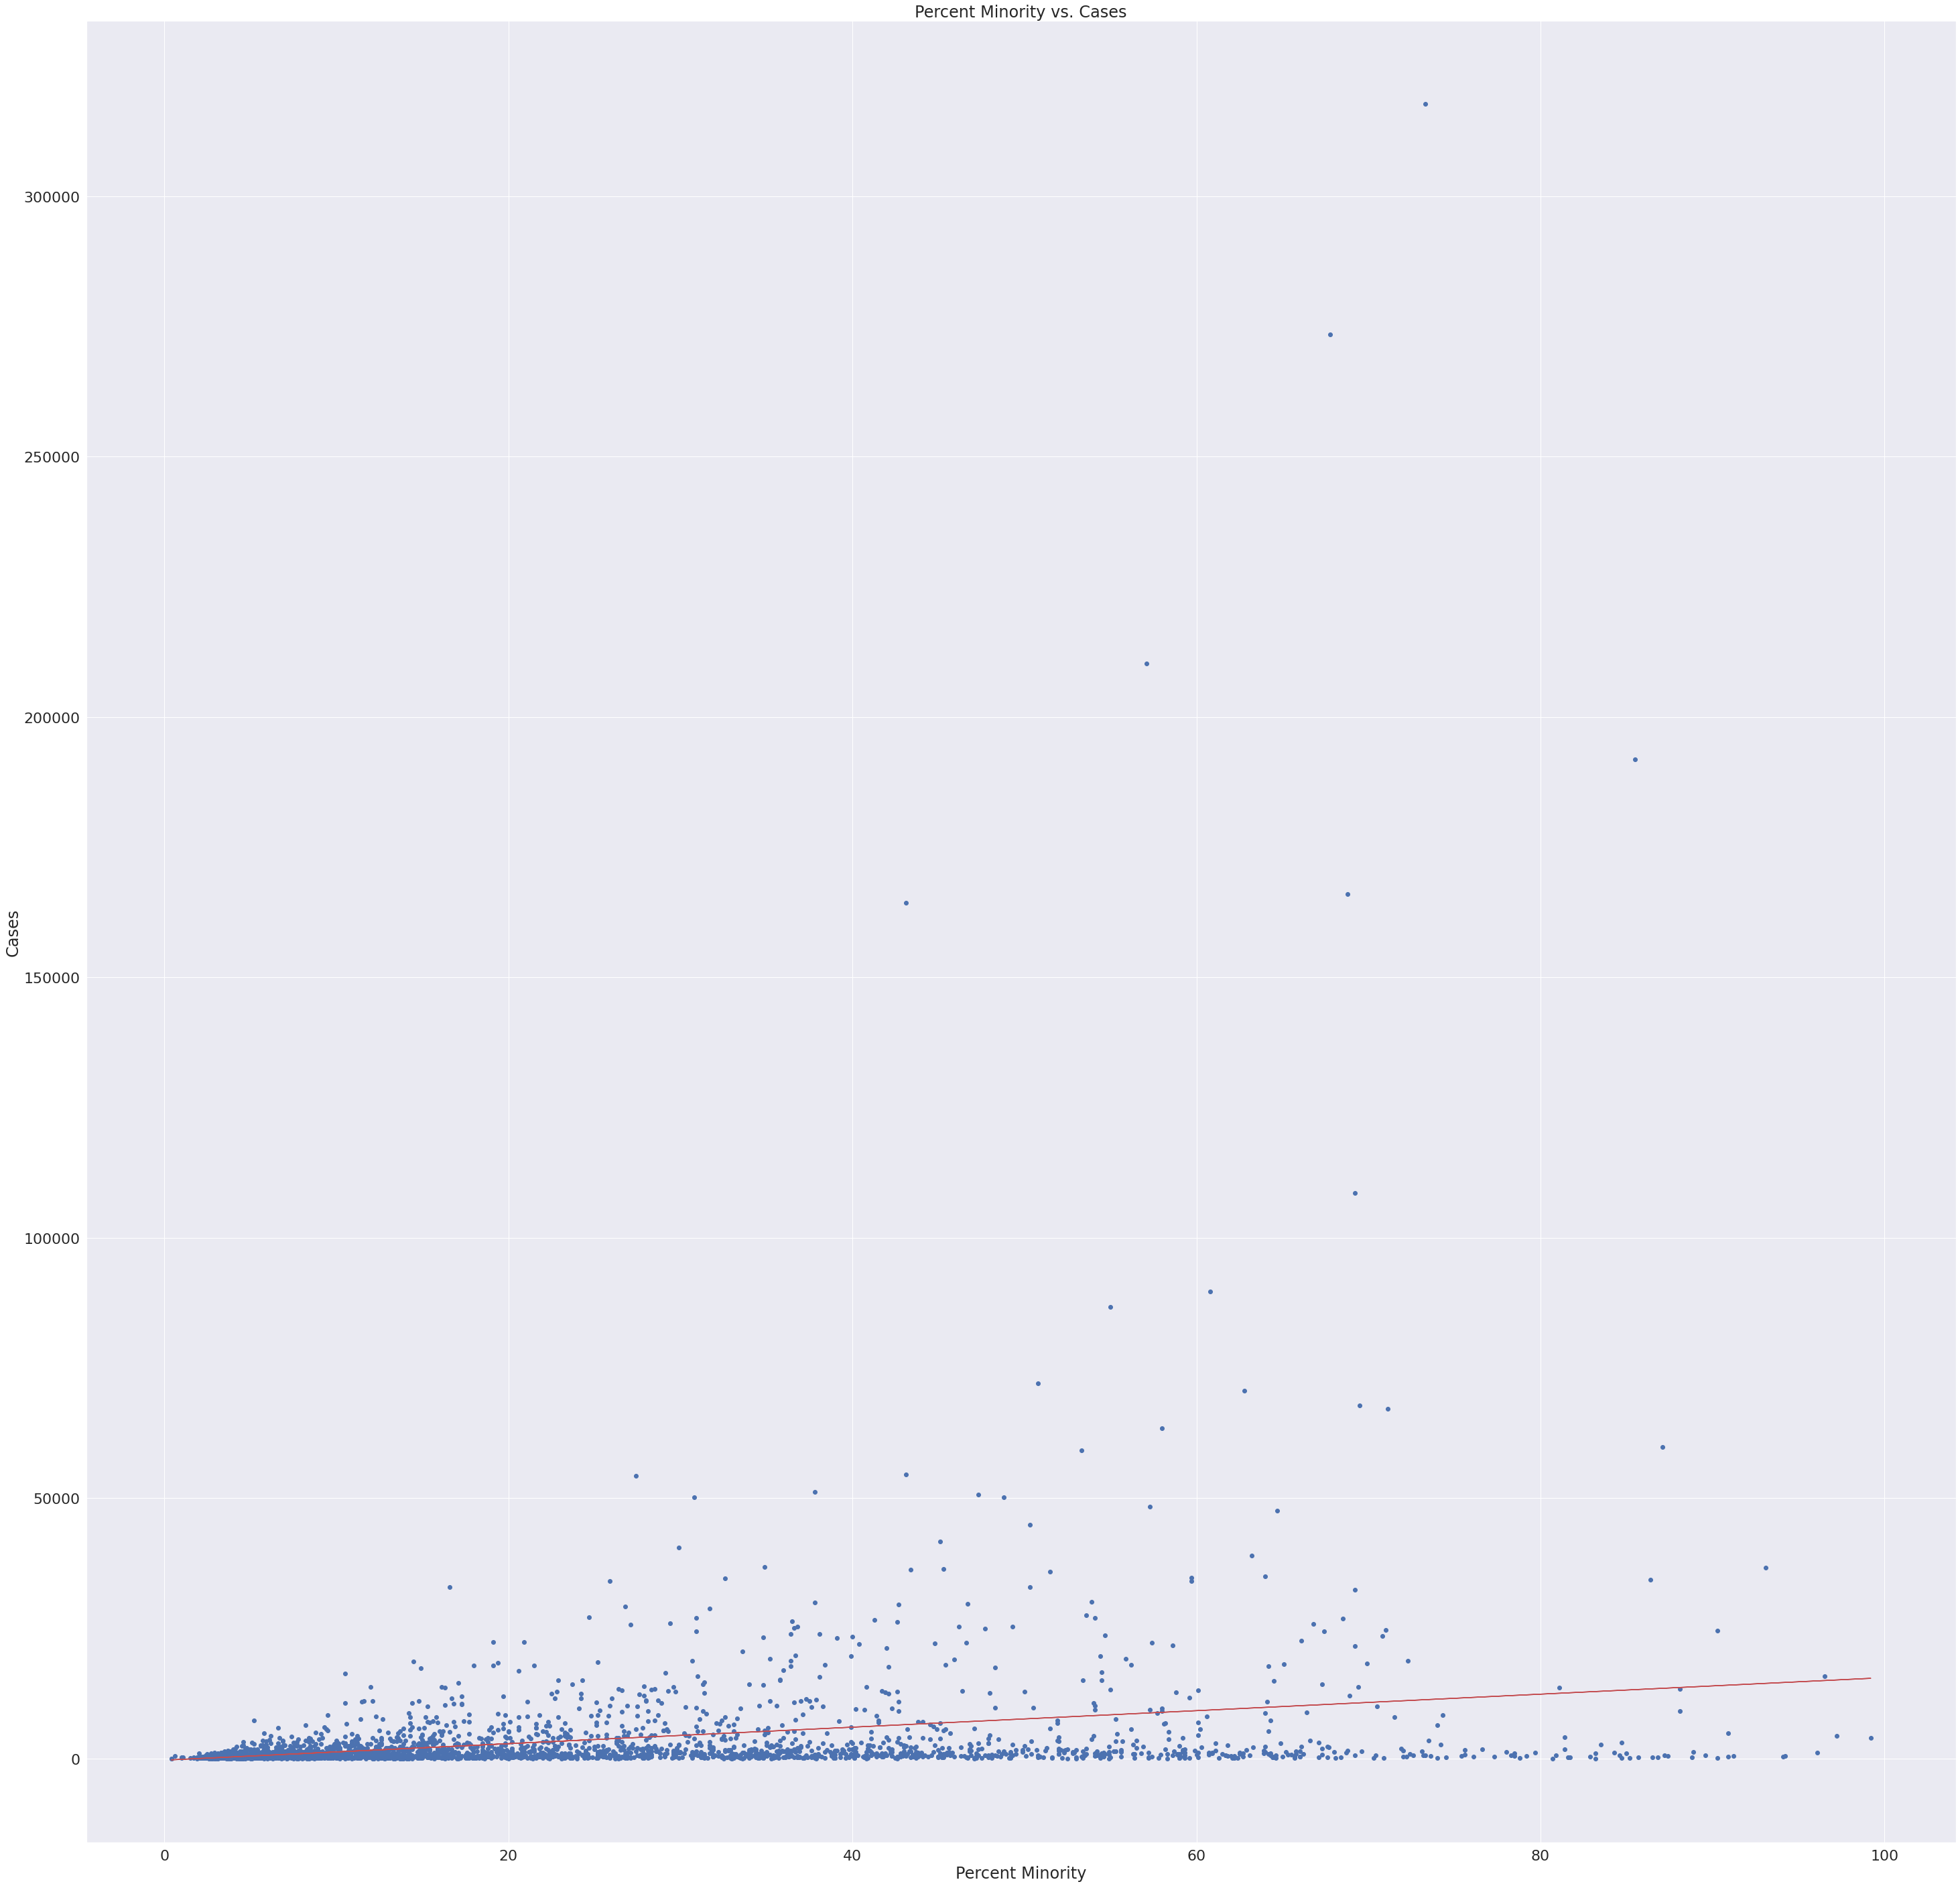

158.41558487744268


In [35]:
plt.scatter(race['percent_minorities'], race['cases'])
plt.title('Percent Minority vs. Cases')
plt.xlabel('Percent Minority')
plt.ylabel('Cases')

x = race['percent_minorities']
y = race['cases']

b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-', c = 'r')
plt.show()

print(m)

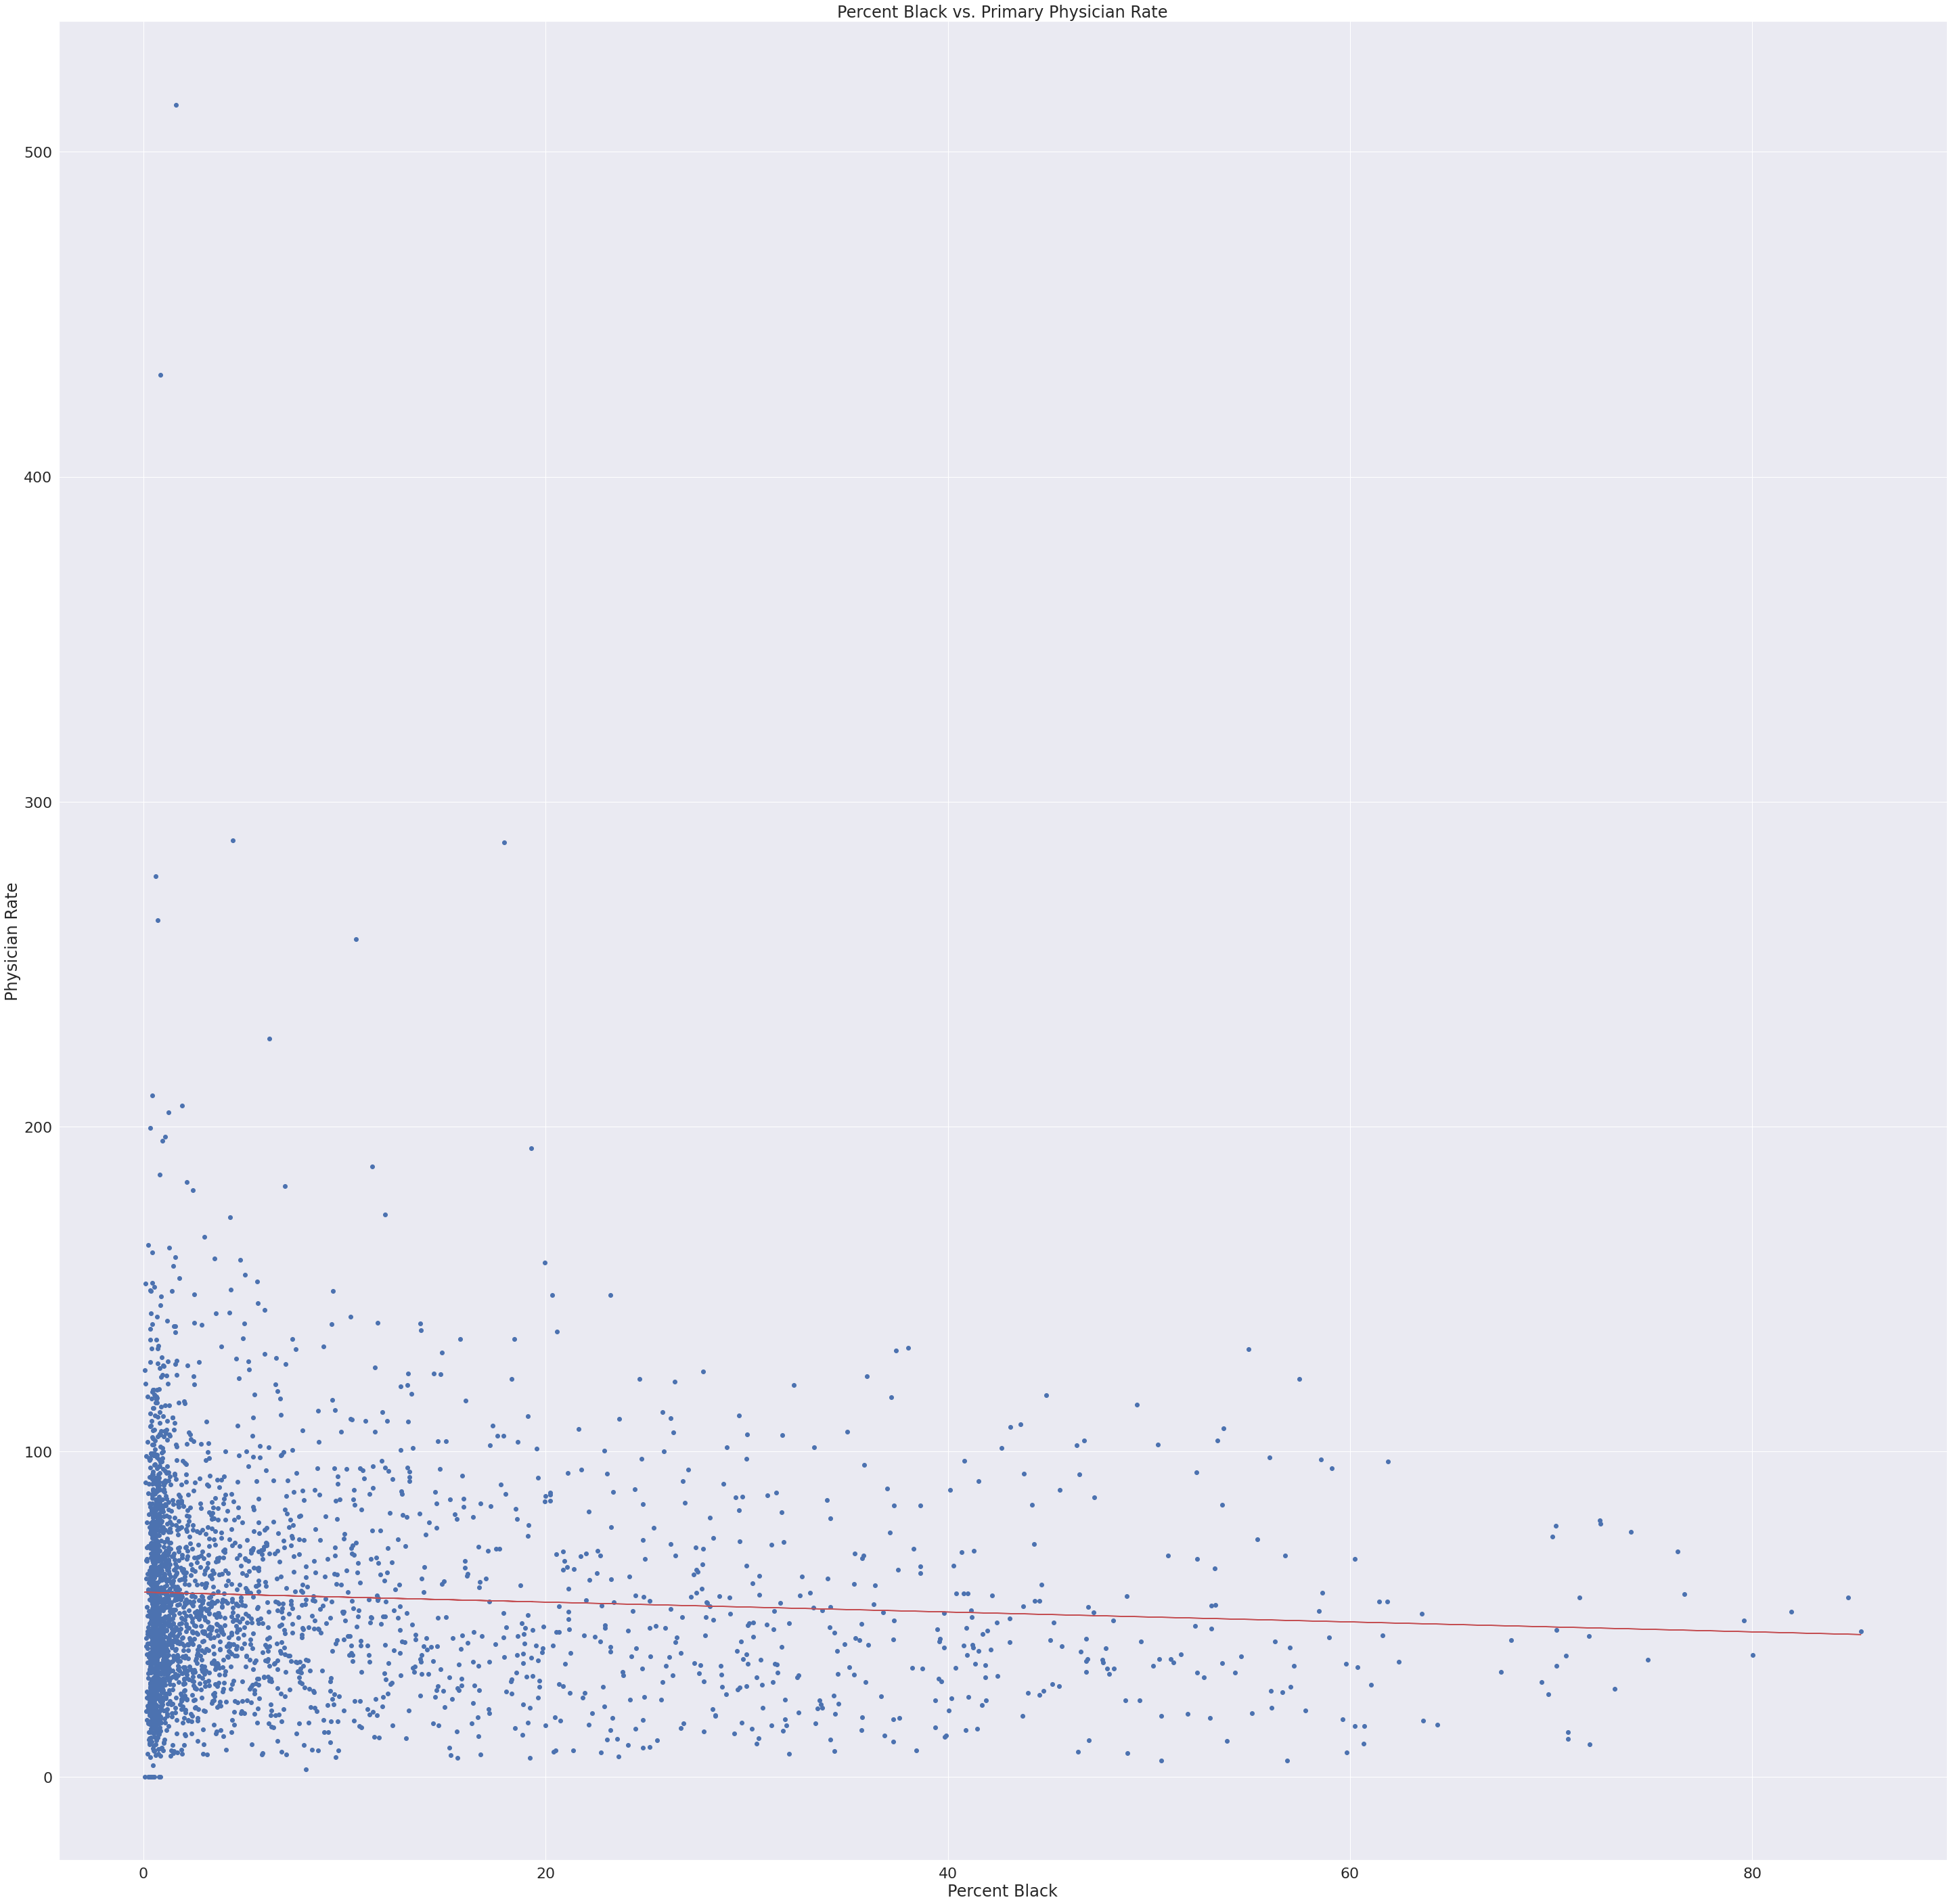

-0.15259438545721207


In [36]:
# Scatter plot of percentage of countries with primary care physicians compared to percentage of African-Americans
plt.scatter(race['percent_black'], race['primary_care_physicians_rate'])
plt.title('Percent Black vs. Primary Physician Rate')
plt.xlabel('Percent Black')
plt.ylabel('Physician Rate')

x = race['percent_black']
y = race['primary_care_physicians_rate']

b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-', c = 'r')
plt.show()

print(m)

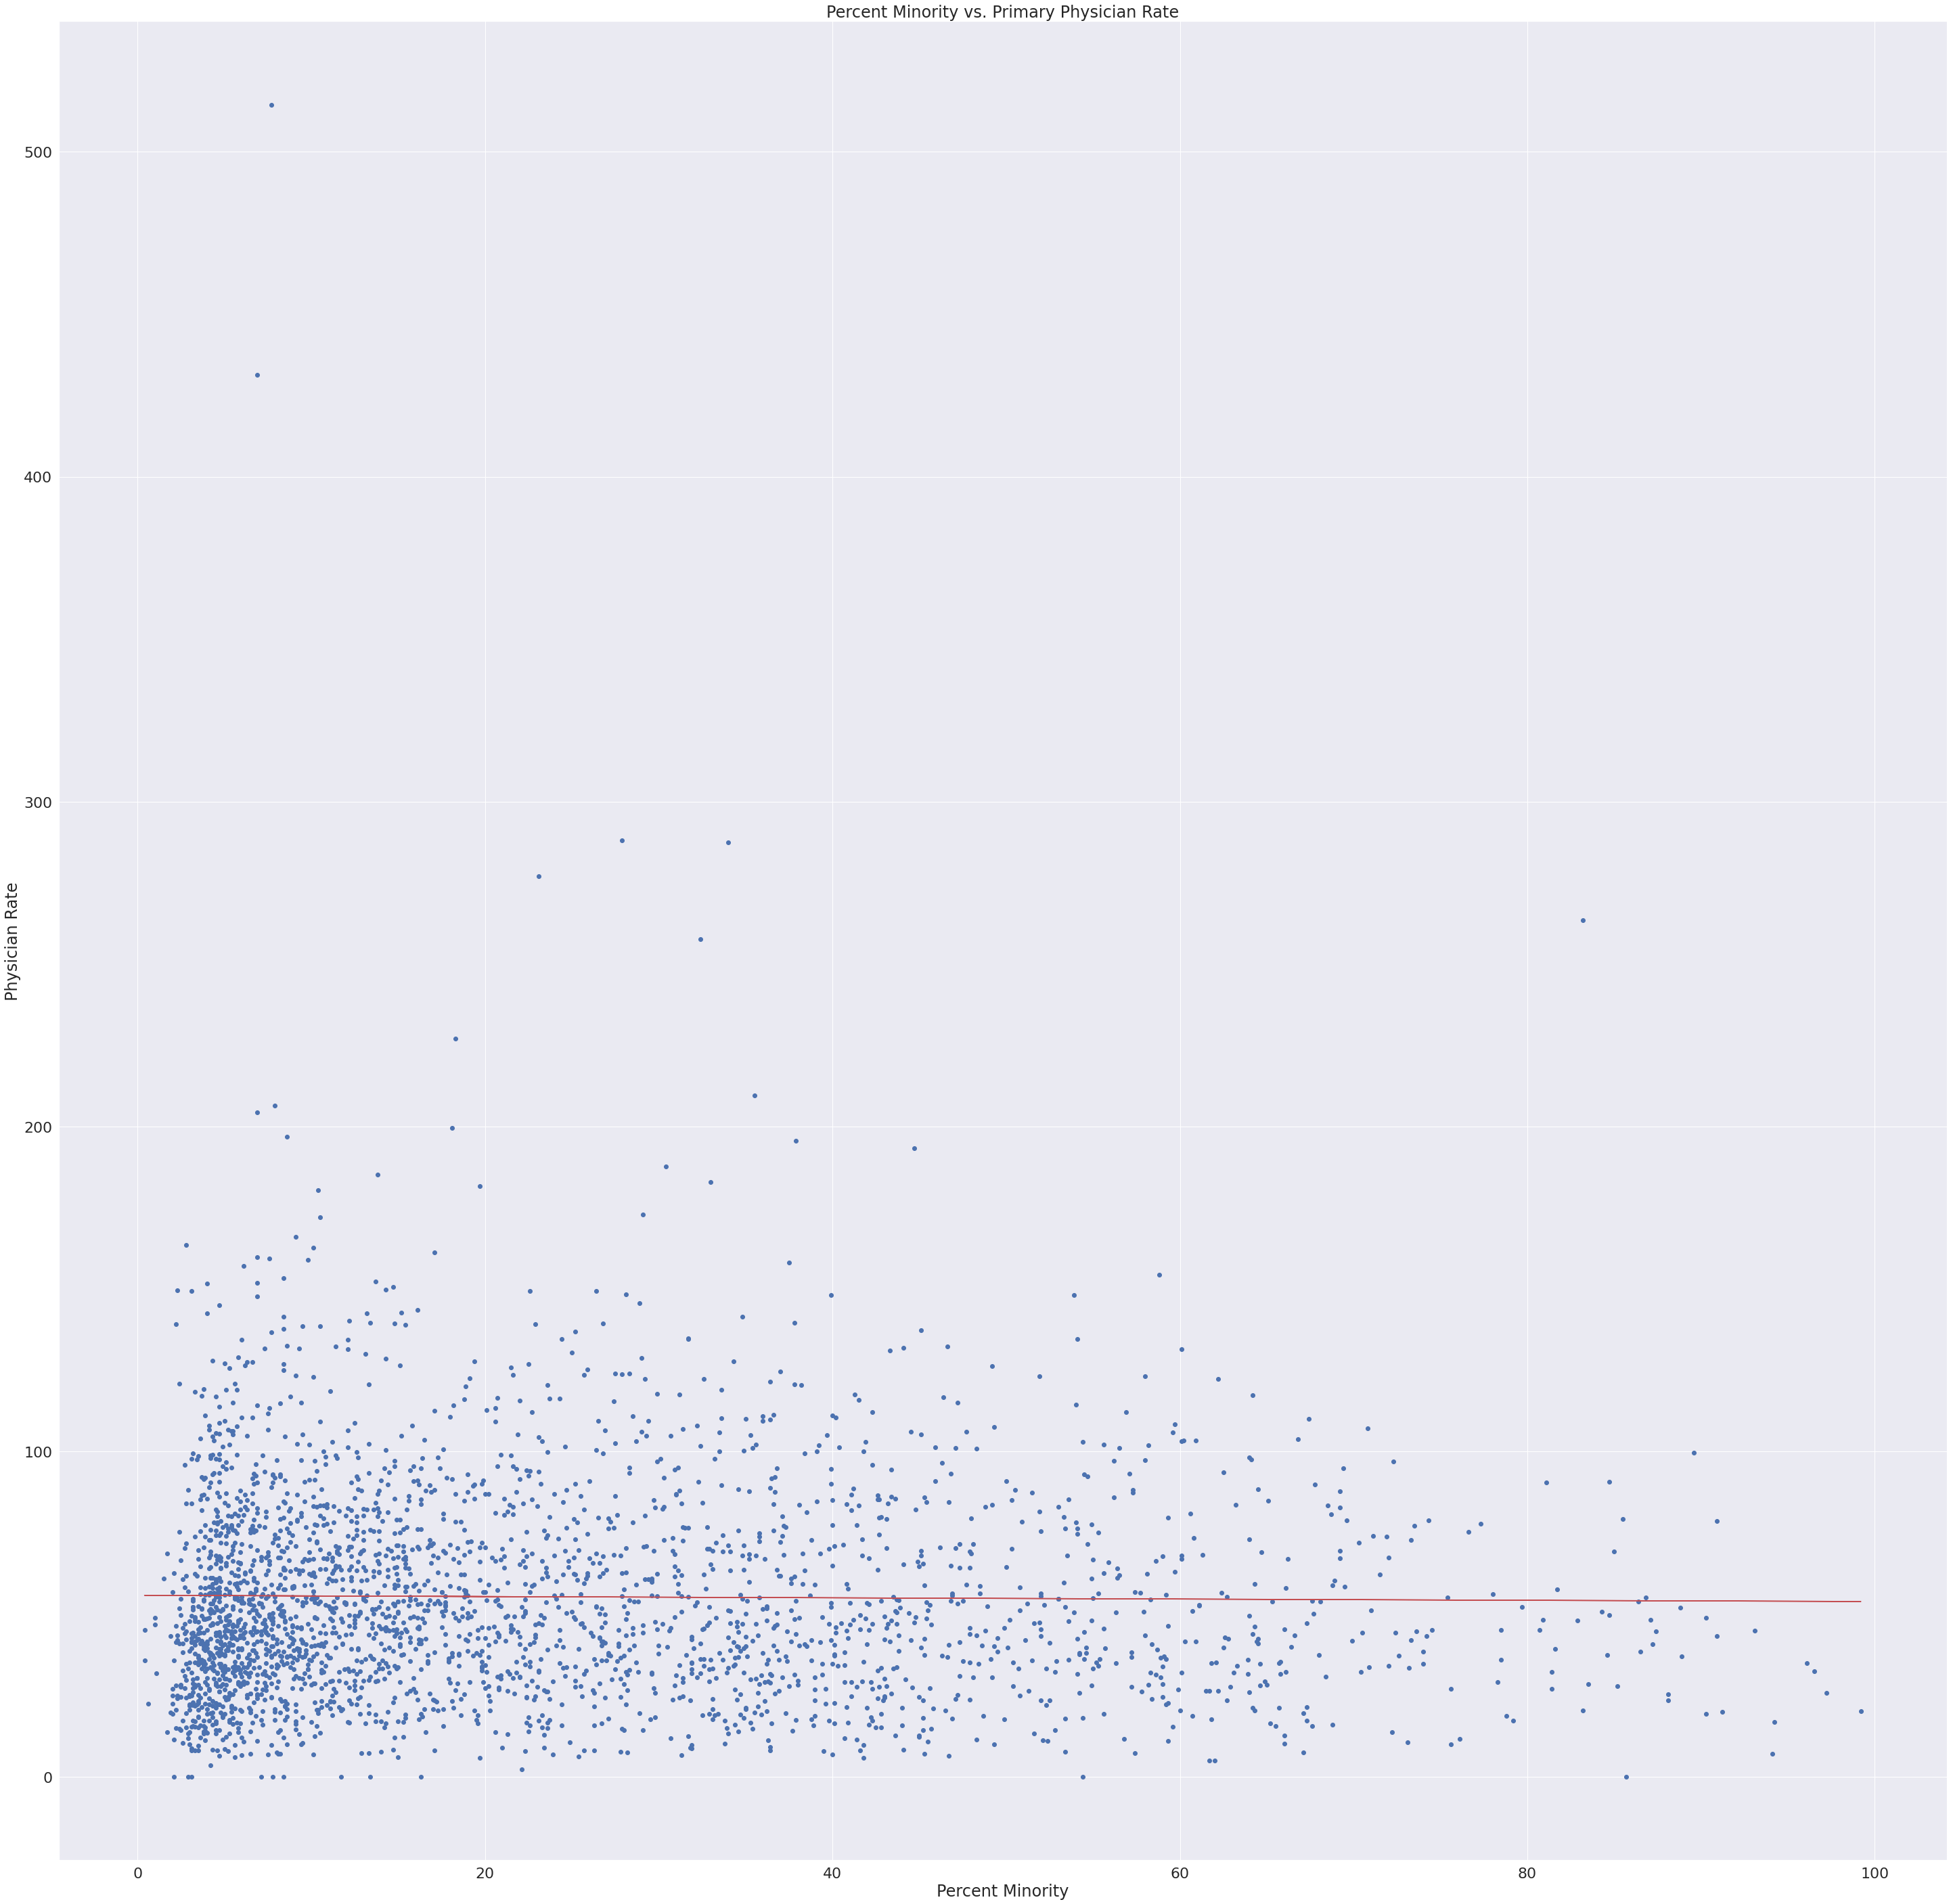

-0.019194107557957214


In [37]:
plt.scatter(race['percent_minorities'], race['primary_care_physicians_rate'])
plt.title('Percent Minority vs. Primary Physician Rate')
plt.xlabel('Percent Minority')
plt.ylabel('Physician Rate')

x = race['percent_minorities']
y = race['primary_care_physicians_rate']
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-', c = 'r')
plt.show()
print(m)

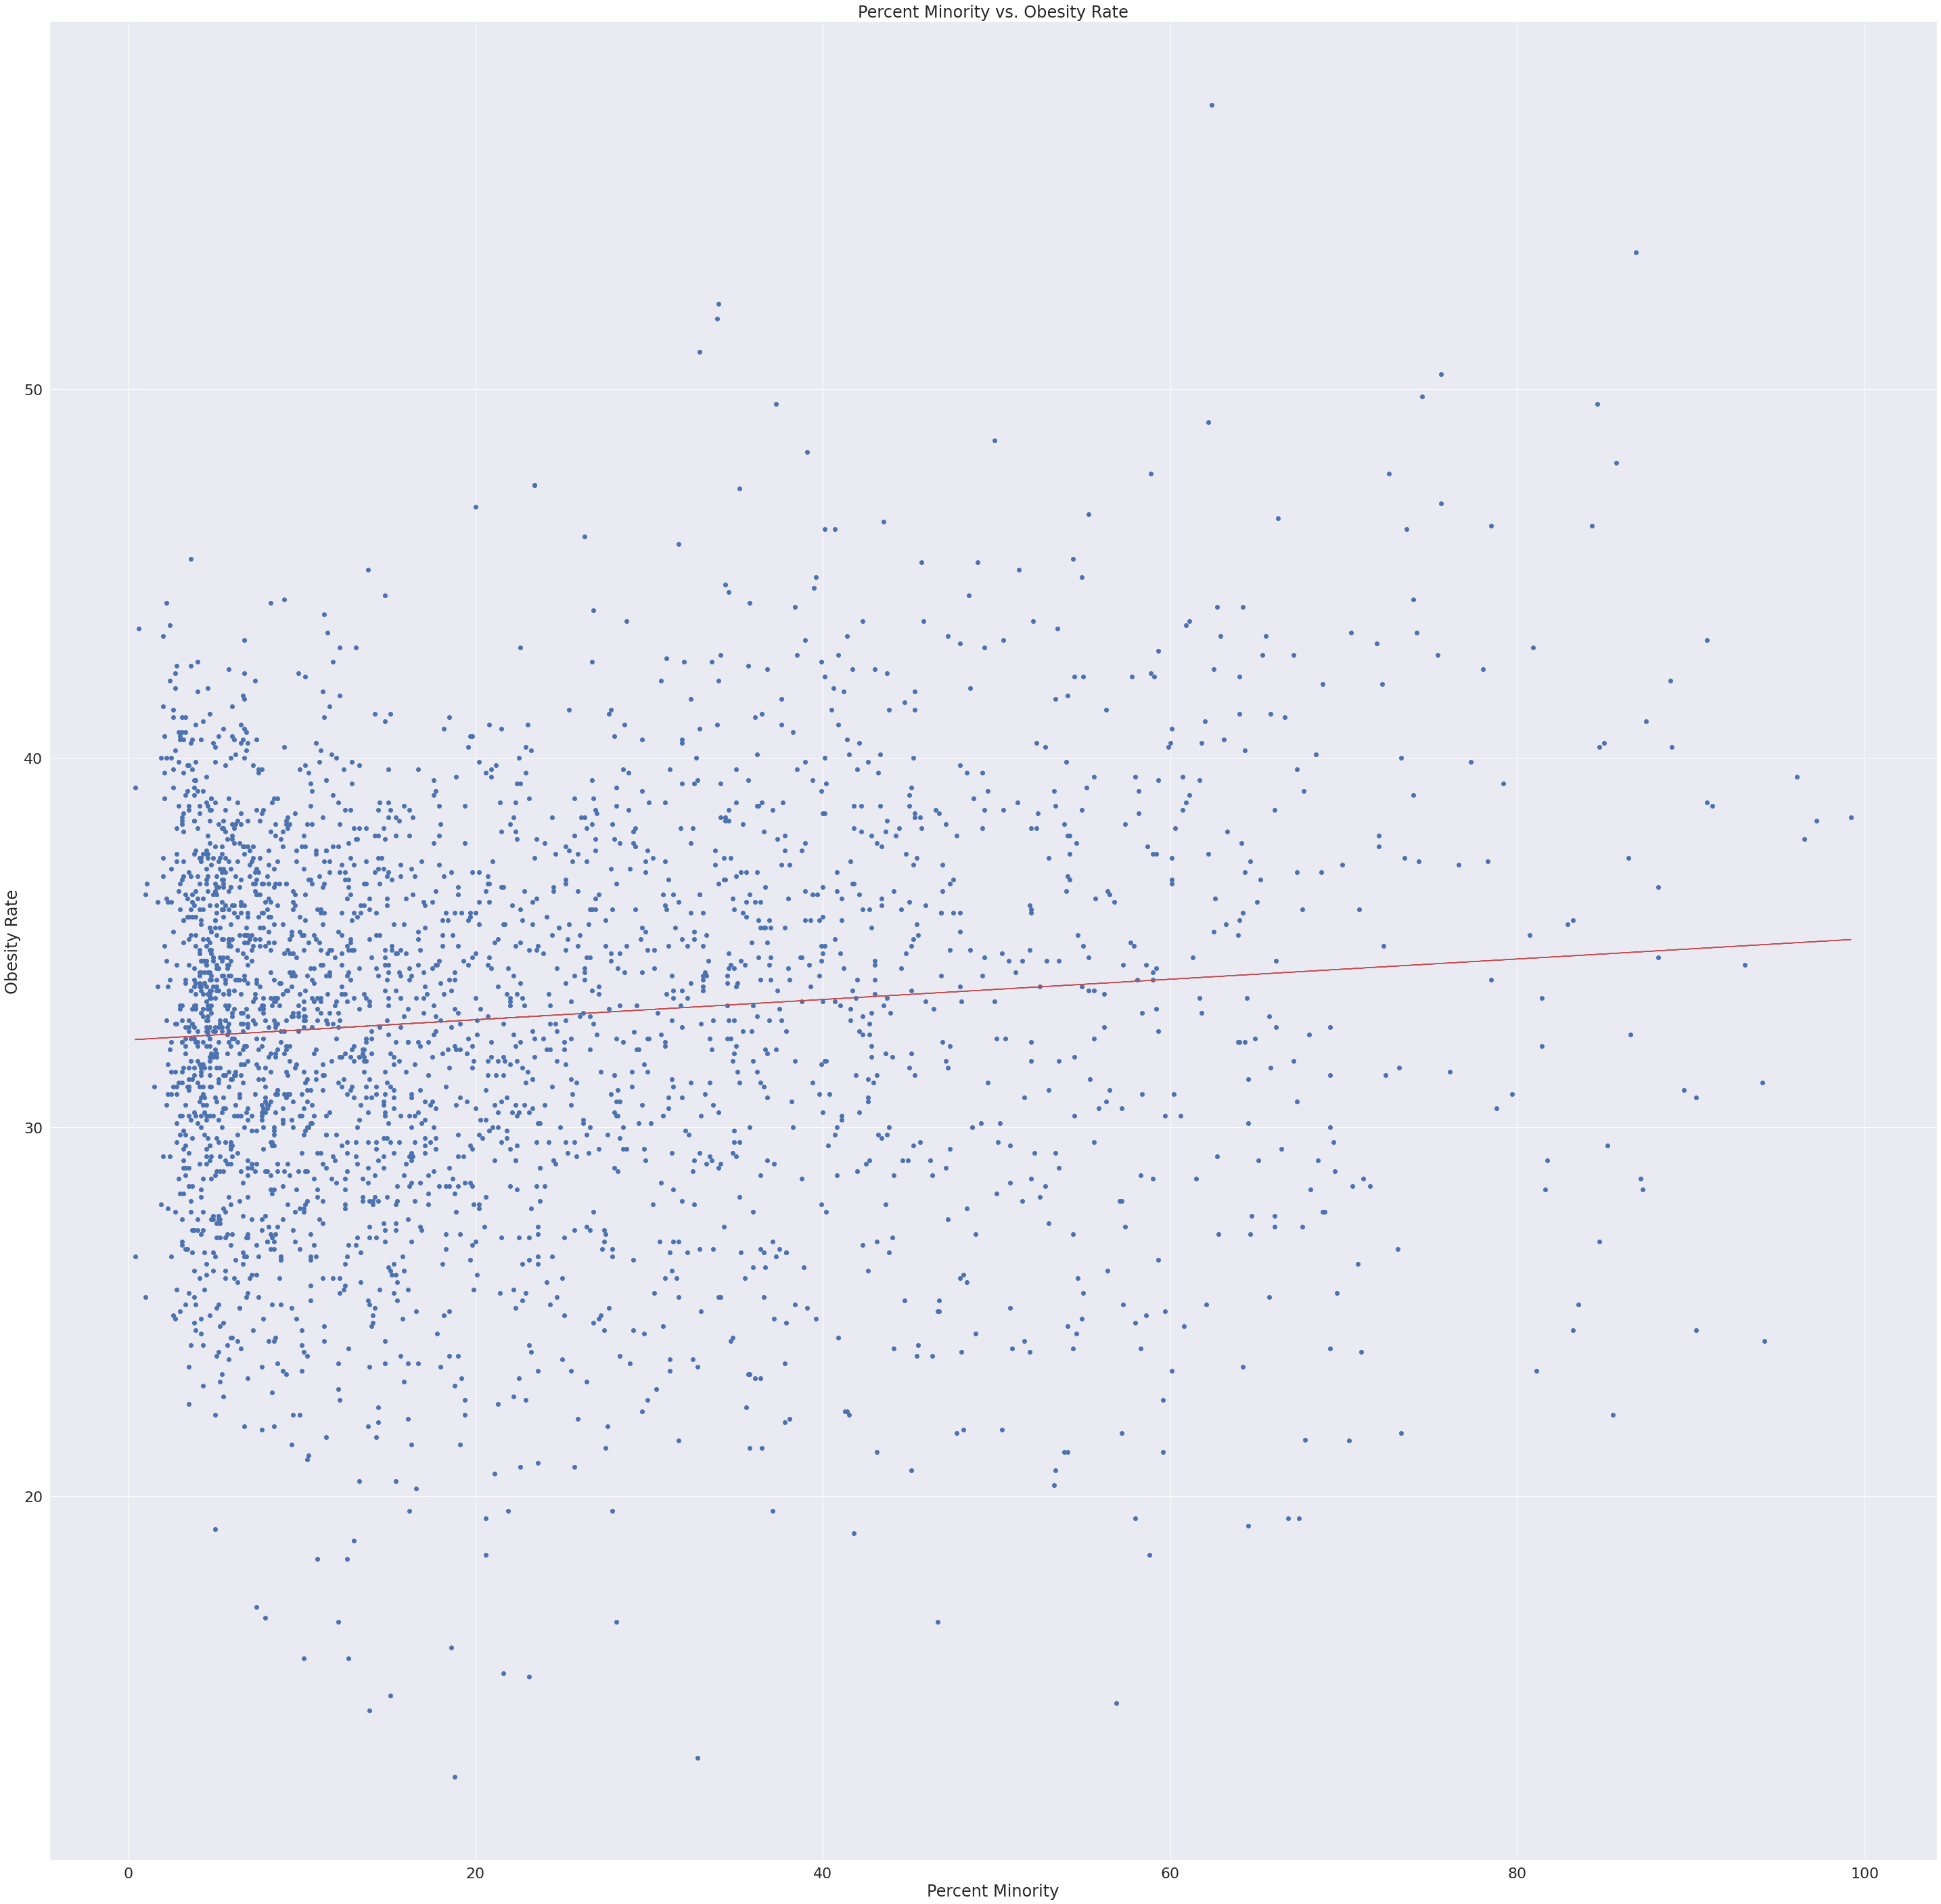

0.027435827314764787


In [38]:
plt.scatter(race['percent_minorities'], race['percent_adults_with_obesity'])
plt.title('Percent Minority vs. Obesity Rate')
plt.xlabel('Percent Minority')
plt.ylabel('Obesity Rate')
x = race['percent_minorities'].dropna()
y = race['percent_adults_with_obesity'].dropna()
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-', c = 'r')
plt.show()

print(m)

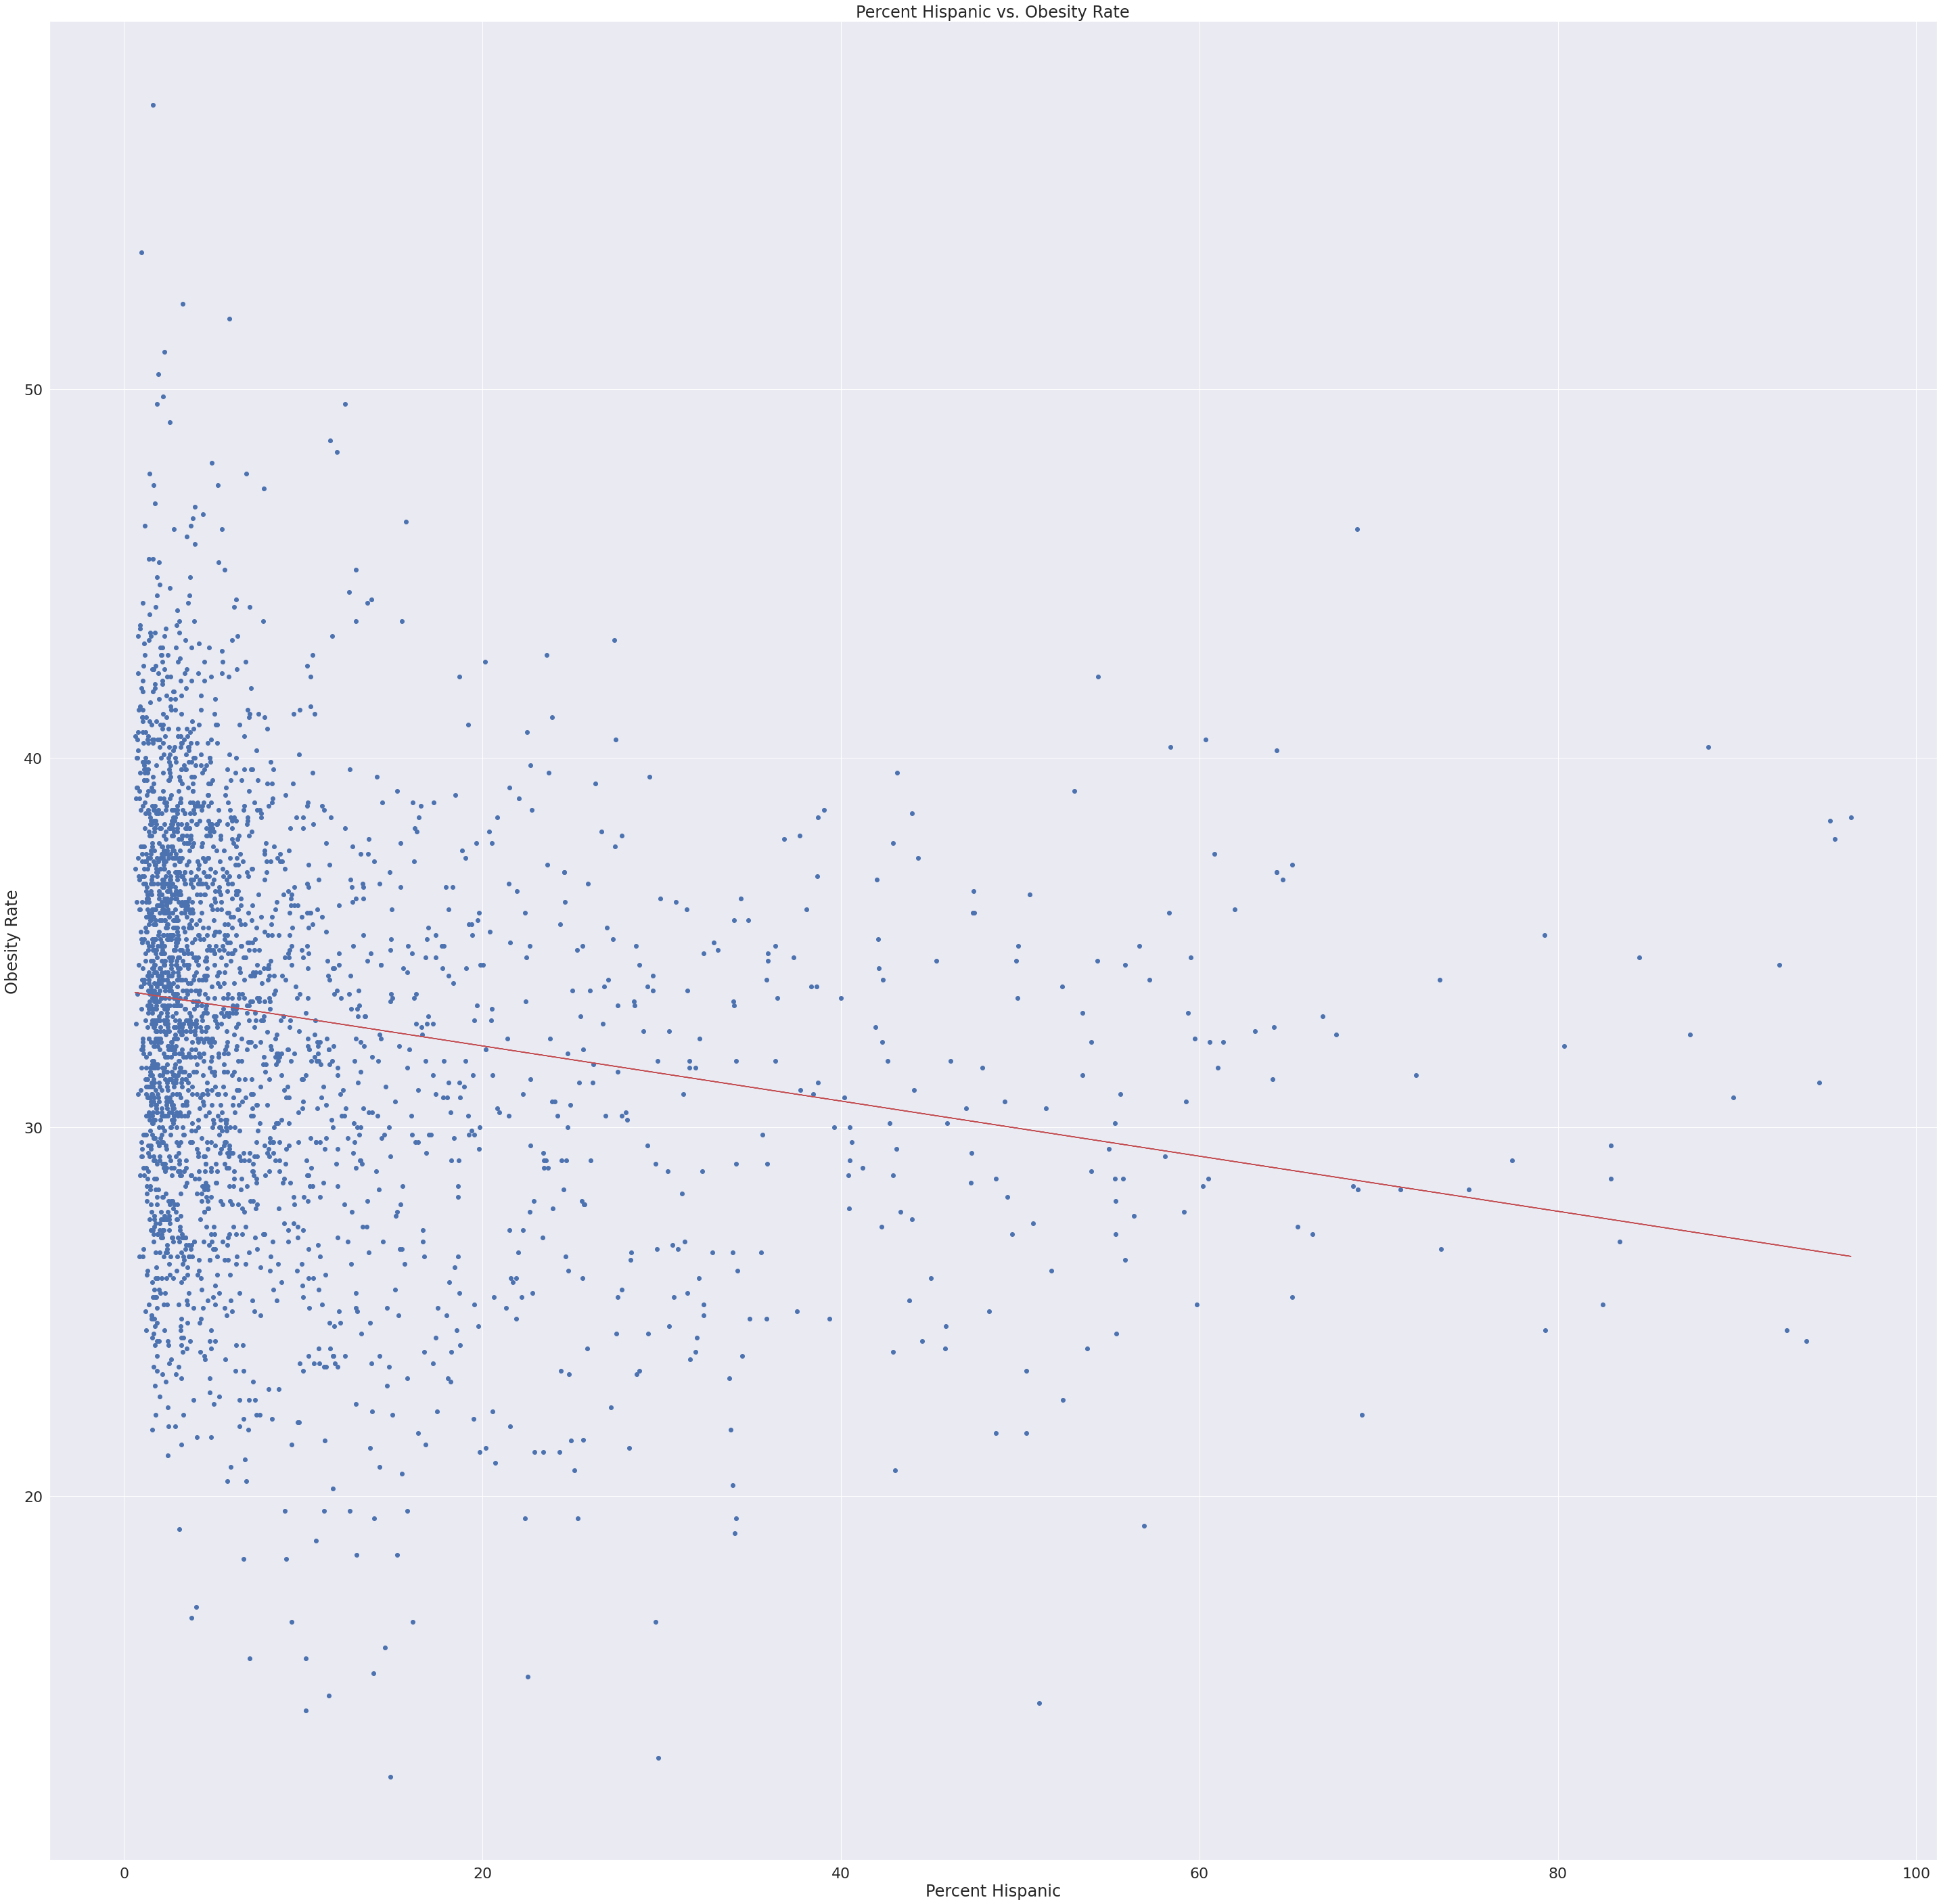

-0.07467861152415271


In [39]:
# Scatter plot of percentage of adults with obesity compared to percentage of Hispanics
plt.scatter(race['percent_hispanic'], race['percent_adults_with_obesity'])
plt.title('Percent Hispanic vs. Obesity Rate')
plt.xlabel('Percent Hispanic')
plt.ylabel('Obesity Rate')

x = race['percent_hispanic']
y = race['percent_adults_with_obesity']
b, m = polyfit(x, y, 1)

plt.plot(x, y, '.')
plt.plot(x, b + m * x, '-', c = 'r')
plt.show()

print(m)

## Notes on Race EDA

With the data that we found for race, we chose to create scatterplots in order to convey the relationship between the percent minority in the population with the cases of COVID that were identified along with the relationship between the percent minority in the population with the fatality rate of COVID. From this, we can see that there is a positive slope for the best-fit-line in both scatterplots. This means that, theoretically, the populations with a higher minority population percentage have a higher COVID cases AND have a higher COVID fatality rate. However, since there are so many outliers and the slopes are so small, it’s unlikely that the previous conclusion can be considered an accurate correlation.

We also explored the relationship of comorbidities and Physician availability with respect to the race demographics of a population. In the graphs we can see a small positive correlation between obesity and minority percent on the left and a small negative correlation between physician access and minority percent on the right.This indicates that places with higher percent minority populations are on average slightly more obese and have slightly less access to physician care. Further investigation would be needed to test if this is a valuable correlation as these values are very small.


## Multiple Regressions on Age-Adjusted Death Rate

In [40]:
# Comorbidities
outcome_1, predictors_1 = patsy.dmatrices('age_adjusted_death_rate~percent_adults_with_obesity+percent_smokers+percent_adults_with_diabetes', socio_df)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

In [41]:
print(res_1.summary())

                               OLS Regression Results                              
Dep. Variable:     age_adjusted_death_rate   R-squared:                       0.583
Model:                                 OLS   Adj. R-squared:                  0.583
Method:                      Least Squares   F-statistic:                     1432.
Date:                     Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                             18:11:31   Log-Likelihood:                -17599.
No. Observations:                     3078   AIC:                         3.521e+04
Df Residuals:                         3074   BIC:                         3.523e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

Note about comorbidities:
These results are not surprising, as they support what has been commonly reported throughout the pandemic; unhealthy people are more seriously affected by COVID-19. This support is shown by the large coefficients, which indicate how strongly a feature affects the variable, and small p-values. According to the multiple regression, the most important feature of the three is % Smokers, followed by % Adults with Diabetes, and finally % Adults with Obesity. It should make a lot of sense that smoking, which damages the lungs, increases the death rate for a disease which directly affects the lungs.

In [42]:
# socioeconomic indicators
outcome_2, predictors_2 = patsy.dmatrices('age_adjusted_death_rate~percent_uninsured+median_household_income+percent_below_poverty', socio_df)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

print(res_2.summary())

                               OLS Regression Results                              
Dep. Variable:     age_adjusted_death_rate   R-squared:                       0.539
Model:                                 OLS   Adj. R-squared:                  0.538
Method:                      Least Squares   F-statistic:                     1196.
Date:                     Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                             18:11:31   Log-Likelihood:                -17754.
No. Observations:                     3078   AIC:                         3.552e+04
Df Residuals:                         3074   BIC:                         3.554e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------


socioeconomic notes:
According to the multiple regression results, Death Rate shows a strong positive correlation with % Below Poverty, weak correlation with % Uninsured, and a strong negative correlation with Median Household Income (MHI). The coefficient for MHI supports our hypothesis, as it suggests that death rate decreases as median income increases (the values are so small due to units used). The % Below Poverty results provide similar information, showing that as more people are in poverty the death rate increases. The fact that % Uninsured shows a weak correlation can be largely explained by the struggles with treating coronavirus experienced by medical experts worldwide.

In [43]:
# how socioeconomic affects obesity
outcome_3, predictors_3 = patsy.dmatrices('percent_adults_with_obesity~percent_uninsured+median_household_income+percent_below_poverty', socio_df)
mod_3 = sm.OLS(outcome_3, predictors_3)
res_3 = mod_3.fit()
print(res_3.summary())

                                 OLS Regression Results                                
Dep. Variable:     percent_adults_with_obesity   R-squared:                       0.187
Model:                                     OLS   Adj. R-squared:                  0.186
Method:                          Least Squares   F-statistic:                     239.5
Date:                         Tue, 15 Dec 2020   Prob (F-statistic):          6.58e-140
Time:                                 18:11:32   Log-Likelihood:                -9429.7
No. Observations:                         3134   AIC:                         1.887e+04
Df Residuals:                             3130   BIC:                         1.889e+04
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

In [44]:
# how socioeconomic affects diabetes
outcome_4, predictors_4 = patsy.dmatrices('percent_adults_with_diabetes~percent_uninsured+median_household_income+percent_below_poverty', socio_df)
mod_4 = sm.OLS(outcome_4, predictors_4)
res_4 = mod_4.fit()
print(res_4.summary())

                                 OLS Regression Results                                 
Dep. Variable:     percent_adults_with_diabetes   R-squared:                       0.218
Model:                                      OLS   Adj. R-squared:                  0.217
Method:                           Least Squares   F-statistic:                     291.1
Date:                          Tue, 15 Dec 2020   Prob (F-statistic):          1.19e-166
Time:                                  18:11:33   Log-Likelihood:                -8449.5
No. Observations:                          3134   AIC:                         1.691e+04
Df Residuals:                              3130   BIC:                         1.693e+04
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------


Effect of socioeconomic status on prevalence of comorbidities:
Across every comorbidity Median Household Income (MHI) has a moderate correlation and % Below Poverty has a strong positive correlation. This supports our hypothesis as well as agreeing with what has been common belief for some time now that people with a higher socioeconomic status tend to be overall healthier. This is a crucial note for our project as it is a potential confounding factor for socioeconomic status and death rate. % Uninsured appears to have a weak to moderate negative correlation. This can likely be explained by the idea that somebody with health issues is more likely to have complications and therefore will make sure they have health insurance.

In [45]:
# accounting for socioeconomic and comorbidities
outcome_5, predictors_5 = patsy.dmatrices('age_adjusted_death_rate~percent_uninsured+median_household_income+percent_below_poverty+percent_adults_with_obesity+percent_smokers+percent_adults_with_diabetes', socio_df)
mod_5 = sm.OLS(outcome_5, predictors_5)
res_5 = mod_5.fit()
print(res_5.summary())

                               OLS Regression Results                              
Dep. Variable:     age_adjusted_death_rate   R-squared:                       0.664
Model:                                 OLS   Adj. R-squared:                  0.664
Method:                      Least Squares   F-statistic:                     1013.
Date:                     Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                             18:11:33   Log-Likelihood:                -17265.
No. Observations:                     3078   AIC:                         3.454e+04
Df Residuals:                         3071   BIC:                         3.459e+04
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------


Socioeconomic and Comorbidities together:
We see that all six indicators used above are still statistically significant when all are considered together. This suggests that the effects of both socioeconomic status and comorbidites on death rate can not be completely described by the other.

In [46]:
# race
outcome_6, predictors_6 = patsy.dmatrices('age_adjusted_death_rate~percent_non_hispanic_white+percent_minorities+percent_hispanic', race_df)
mod_6 = sm.OLS(outcome_6, predictors_6)
res_6 = mod_6.fit()
print(res_6.summary())

                               OLS Regression Results                              
Dep. Variable:     age_adjusted_death_rate   R-squared:                       0.176
Model:                                 OLS   Adj. R-squared:                  0.176
Method:                      Least Squares   F-statistic:                     219.4
Date:                     Tue, 15 Dec 2020   Prob (F-statistic):          5.58e-129
Time:                             18:11:34   Log-Likelihood:                -18646.
No. Observations:                     3078   AIC:                         3.730e+04
Df Residuals:                         3074   BIC:                         3.732e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------


Notes about race:
On the surface, it appears that these three categories are all have statistically signficant correlations with covid outcomes, but not necessarily in the way that we would think. The percent of minorities in a county as well as the percent of non-hispanic white people in a county are both positively correlated with age-adjusted death rate. There is obviously strong multicollinearity in these variables, which is something to note. Interestingly the percent of hispanic individuals has a negative correlation with age-adjusted death rate.

In [47]:
# how race affects obesity
outcome_7, predictors_7 = patsy.dmatrices('percent_adults_with_obesity~percent_non_hispanic_white+percent_minorities+percent_hispanic', race_df)
mod_7 = sm.OLS(outcome_7, predictors_7)
res_7 = mod_7.fit()
print(res_7.summary())

                                 OLS Regression Results                                
Dep. Variable:     percent_adults_with_obesity   R-squared:                       0.111
Model:                                     OLS   Adj. R-squared:                  0.110
Method:                          Least Squares   F-statistic:                     130.5
Date:                         Tue, 15 Dec 2020   Prob (F-statistic):           1.26e-79
Time:                                 18:11:34   Log-Likelihood:                -9568.9
No. Observations:                         3134   AIC:                         1.915e+04
Df Residuals:                             3130   BIC:                         1.917e+04
Df Model:                                    3                                         
Covariance Type:                     nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [48]:
# how race affects smoking
outcome_8, predictors_8 = patsy.dmatrices('percent_smokers~percent_non_hispanic_white+percent_minorities+percent_hispanic', race_df)
mod_8 = sm.OLS(outcome_8, predictors_8)
res_8 = mod_8.fit()
print(res_8.summary())

                            OLS Regression Results                            
Dep. Variable:        percent_smokers   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     292.3
Date:                Tue, 15 Dec 2020   Prob (F-statistic):          2.79e-167
Time:                        18:11:35   Log-Likelihood:                -8082.4
No. Observations:                3134   AIC:                         1.617e+04
Df Residuals:                    3130   BIC:                         1.620e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [49]:
# how race affects diabetes
outcome_9, predictors_9 = patsy.dmatrices('percent_adults_with_diabetes~percent_non_hispanic_white+percent_minorities+percent_hispanic', race_df)
mod_9 = sm.OLS(outcome_9, predictors_9)
res_9 = mod_9.fit()
print(res_9.summary())

                                 OLS Regression Results                                 
Dep. Variable:     percent_adults_with_diabetes   R-squared:                       0.101
Model:                                      OLS   Adj. R-squared:                  0.100
Method:                           Least Squares   F-statistic:                     116.8
Date:                          Tue, 15 Dec 2020   Prob (F-statistic):           1.01e-71
Time:                                  18:11:36   Log-Likelihood:                -8668.8
No. Observations:                          3134   AIC:                         1.735e+04
Df Residuals:                              3130   BIC:                         1.737e+04
Df Model:                                     3                                         
Covariance Type:                      nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

Note about Race and Comorbidity:
Some interesting things here are that the percent of minorities in a county was positively correlated with obesity, diabetes and smoking rates at the .01 level of significance. Percent hispanic was significantly negatively correlated with all three as well, which might help to explain the negative correlation with age adjusted death rate. Lastly, percentage of white people in a county was significantly correlated with diabetes and smoking but not with obesity at the .01 level of significance

In [50]:
# race + comorbidities
outcome_10, predictors_10 = patsy.dmatrices('age_adjusted_death_rate~percent_non_hispanic_white+percent_minorities+percent_hispanic+percent_adults_with_obesity+percent_smokers+percent_adults_with_diabetes', race_df)
mod_10 = sm.OLS(outcome_10, predictors_10)
res_10 = mod_10.fit()
print(res_10.summary())

                               OLS Regression Results                              
Dep. Variable:     age_adjusted_death_rate   R-squared:                       0.603
Model:                                 OLS   Adj. R-squared:                  0.602
Method:                      Least Squares   F-statistic:                     778.1
Date:                     Tue, 15 Dec 2020   Prob (F-statistic):               0.00
Time:                             18:11:37   Log-Likelihood:                -17522.
No. Observations:                     3078   AIC:                         3.506e+04
Df Residuals:                         3071   BIC:                         3.510e+04
Df Model:                                6                                         
Covariance Type:                 nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------


Race vs. Comorbidity:
This OLS regression analysis is extremely interesting to see. It is important to start by saying that there is a sign of multicollinearity, which is to be expected given how much each of these variables interact with one another. What is really interesting to see is that the p-values for all three major comorbidities are statistically significant but the p-values for the race variables are all very high which in this two-tailed distribution means that when the comorbidities are taken out of the equation, there is no meaningful relationship between race and covid outcomes.

## Principal Component Analysis

Due to the high level of multicollinearity that was present in our multiple regressions, we decided the best route would be to conduct Principal Component Analysis to calculate the explained variance by each of the comorbidities, race, and socioeconomic variables present. If what we expect to be true, which is that comorbidities are the majority force behind racial and socioeconomic disparity in covid outcomes, we should see that the most explained variance comes from the comorbidity variables

In [51]:
total_df = latest_df[['percent_adults_with_diabetes', 'percent_adults_with_obesity', 'percent_smokers',
                      'percent_hispanic', 'percent_minorities', 'percent_non_hispanic_white', 
                      'median_household_income', 'percent_uninsured', 'percent_below_poverty', 'age_adjusted_death_rate']]

In [52]:
total_df = total_df.dropna()

In [53]:
# Only lose a 100 or so observations which isn't too bad. Matrix operations are not possible with NaN's so
# We must get rid of them

In [54]:
len(total_df)

3078

We create this dataframe for the purposes of conducting Principal Component Analysis on the different variables. The reason for this is there is a lot of multicollinearity going on, and conducting PCA will allow us to weed out the variables that aren't individually explanatory of variance.

The process for conducting PCA, which we will do by hand for a specific purpose I will get into later, is calculating the covariance matrix of the standardized version of the matrix, and then computing the eigenvectors and eigenvalues of the covariance matrix. Based on the ranking them on the size of their eigenvalues, we can theoretically see which components are the most explanatory of variance.

In [55]:
## Helper function to standardize dataset

def standardize(col):
    return (col-np.mean(col))/np.std(col)

In [56]:
## While looping through dataframes is a punishable offense, it is okay to loop through columns to apply a function

for i in total_df.columns:
    total_df[i] = standardize(total_df[i])

In [57]:
np.mean(total_df['percent_adults_with_obesity'])

-1.1478945907299754e-14

In [58]:
np.std(total_df['percent_adults_with_obesity'])

1.0000000000000004

In [59]:
# Verify that the mean and std are 0 and 1 respectively

In [60]:
# Remember the order of the columns

total_df.columns

Index(['percent_adults_with_diabetes', 'percent_adults_with_obesity',
       'percent_smokers', 'percent_hispanic', 'percent_minorities',
       'percent_non_hispanic_white', 'median_household_income',
       'percent_uninsured', 'percent_below_poverty',
       'age_adjusted_death_rate'],
      dtype='object')

In [61]:
# Cast the data frame into a NP Matrix (Except last col bc this is what we want to calculate Covariance matrix on)

matrix = np.mat(total_df[total_df.columns[:-1]])

In [62]:
# Calculate the covariance matrix rowvar = False because the variables are in columns not rows

In [63]:
cov = np.cov(matrix, total_df['age_adjusted_death_rate'], rowvar=False)

In [64]:
cov

array([[ 1.00032499,  0.50679261,  0.46180229, -0.18302749,  0.08481906,
        -0.07265588, -0.46281368,  0.14257053,  0.39601493,  0.52806574],
       [ 0.50679261,  1.00032499,  0.48948818, -0.18825478,  0.09924103,
        -0.09126401, -0.42586846,  0.06586469,  0.34042363,  0.46608761],
       [ 0.46180229,  0.48948818,  1.00032499, -0.27841495,  0.12351692,
        -0.10860961, -0.60258846,  0.10206521,  0.68186806,  0.73128299],
       [-0.18302749, -0.18825478, -0.27841495,  1.00032499,  0.59689902,
        -0.60917639,  0.04077693,  0.44312231,  0.07439059, -0.12632488],
       [ 0.08481906,  0.09924103,  0.12351692,  0.59689902,  1.00032499,
        -0.99794311, -0.12530599,  0.47384319,  0.46084034,  0.2396764 ],
       [-0.07265588, -0.09126401, -0.10860961, -0.60917639, -0.99794311,
         1.00032499,  0.11082161, -0.47477667, -0.44714841, -0.22803738],
       [-0.46281368, -0.42586846, -0.60258846,  0.04077693, -0.12530599,
         0.11082161,  1.00032499, -0.3395919 

In [65]:
# Now, solve for the eigenspaces of the covariance matrix

In [66]:
eigvals, eigvecs = la.eig(cov)

In [67]:
# Calculate percent of explained variance using lambda[i]/Sum(lambda[i] from 1 to N) where lambda[i] is each 
# individual eigenvalue

In [68]:
print('Explained Variance')
print('')
for i in range(9):
    print(total_df.columns[i] + ': ' + str(np.round(100*float(eigvals[i])/float(sum(eigvals)), decimals = 2)) + '%') 

Explained Variance

percent_adults_with_diabetes: 41.57%
percent_adults_with_obesity: 26.93%
percent_smokers: 8.13%
percent_hispanic: 7.34%
percent_minorities: 0.02%
percent_non_hispanic_white: 4.88%
median_household_income: 4.2%
percent_uninsured: 1.5%
percent_below_poverty: 2.48%


As we can see, the vast majority of explained variance comes from diabetes and obesity. The other aren't necessarily insignificant (though some are), but this would seem to indicate that our hypothesis was correct, that the majority of explained variance in differing covid outcomes in racial and socioeconomic terms comes from susceptibility to comorbidities

# Ethics & Privacy

Any time that we discuss medical outcomes, there is inherently a major ethical concern. The numbers that we will be portraying graphically and analyzing are not just numbers, but lost human lives. It is very important for us to understand the gravity of what we are doing. With that being said, the aim of our project is to demonstrate how we have failed racial minorities in healthcare and how our healthcare system in general needs to do a better job of helping all people instead of just wealthy white americans. We believe that we are calling to attention an extremely pervasive issue. Additionally, the data that we will be collecting will without a doubt be devoid of any personal identifying information, due to the laws surrounding medical privacy. If somehow we were to come across data that had privacy concerns, we would immediately anonymize the data, as is standard practice.

Another major concern is bias in terms of COVID-19 severity, population density, and racial diversity. For example, major cities on the coasts might experience higher COVID-19 serverity for reasons outside of racial and socioeconomic factors, so it would not be beneficial to compare these areas with others elsewhere in the United States that might not be affected by these external factors (i.e. comparing New York with Minnesota). We will need to keep this in mind when analyzing our data and instead focus on trends within individual county/geographical area and compare these trends at a gradually greater scope (county, state, nationwide).  

# Conclusion & Discussion

Our hypothesis that comorbidities were most explanatory of differing outcomes in COVID-19 was shown to be mostly true. We found that our dataset was rather limiting in the sense that we only had access to data on a county-wide level. This meant that everything had to be looked at in the sense of descriptive statistics surrounding the variables in a county instead of delving directly into the attributes themselves. Because of this, we were forced to look at whether the proportion of minorities in a county led to that county having a higher death rate as opposed to looking at whether minorities themselves had a higher death rate.  At the same time, we did find that on their own, there was a correlation between minorities and a higher death rate, but with comorbidities such as obesity and diabetes being considered, race was no longer correlated with a difference in covid outcome.
    
When the same thing was applied to socioeconomic variables such as median income and percent in poverty, the results were much different, as all the variables were shown to have a statistically significant impact. All variables were shown to have a statistically significant correlation with a higher fatality rate from covid. A couple possible suggestions to account for these facts are 1) That areas with a lower socioeconomic status are less likely to have a robust testing system and thus only test those with more severe symptoms, which would mean undetected cases that are asymptomatic or mild would not count toward the total and by association result in a higher fatality rate among detected cases and 2) That counties with a lower socioeconomic standing have worse healthcare infrastructure and less access to effective treatments and thus more patients are dying than would otherwise. Both of these factors could possibly cause the results we are seeing, and would be interesting to look at as a continuation of our projec	

In a sense, we were able to debunk the results in the second paragraph by conducting Principal Component Analysis. We did this because we noticed that there was a substantial amount of multicollinearity, which meant that our results in the multiple regression could have been skewed. When conducting PCA, we noticed that the vast majority of the variance in age-adjusted mortality rate was due to just Obesity rate and Diabetes rate. This final result is enough to confirm that certain communities susceptibility to comorbidities is most likely the driving factor behind differences in COVID-19 outcomes.


# Team Contributions

Overview: Adam

Project Proposal: Holly + Sara

Socio EDA: Holly + Sara

Race EDA: Jacob + Ethan

Multiple Regressions: Michael + Adam

PCA: Michael + Adam

Ethics and Privacy: Sara and Holly

Conclusion: Adam